Summary about this notebook




In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% ! important; }<style>"))

In [2]:
# load packages

import matplotlib
%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt 
from matplotlib.ticker import MultipleLocator, FixedLocator
from matplotlib.gridspec import GridSpec

from astropy.timeseries import LombScargle
from astropy.table import Table,vstack, Column
import numpy as np
import os

from gatspy.periodic import LombScargleMultiband  #https://www.astroml.org/gatspy/
from kapteyn import kmpfit  #https://www.astro.rug.nl/software/kapteyn/index.html


In [3]:


def poly1(p, x):
    a0, a1 = p
    return a0+a1*x


def resd_poly1(p, data):
    x, y, yerr = data
    model = poly1(p, x)
    return (y-model)/yerr

def poly2(p, x):
    a0, a1, a2 = p
    return a0+a1*x+a2*x**2


def resd_poly2(p, data):
    x, y, yerr = data
    model = poly2(p, x)
    return (y-model)/yerr

def poly3(p, x):
    a0, a1, a2, a3 = p
    return a0+a1*x+a2*x**2+a3*x**3


def resd_poly3(p, data):
    x, y, yerr = data
    model = poly3(p, x)
    return (y-model)/yerr

def poly4(p, x):
    a0, a1, a2, a3, a4 = p
    return a0+a1*x+a2*x**2+a3*x**3+a4*x**4


def resd_poly4(p, data):
    x, y, yerr = data
    model = poly4(p, x)
    return (y-model)/yerr

def poly5(p, x):
    a0, a1, a2, a3, a4, a5 = p
    return a0+a1*x+a2*x**2+a3*x**3+a4*x**4+a5*x**5


def resd_poly5(p, data):
    x, y, yerr = data
    model = poly5(p, x)
    return (y-model)/yerr

def poly6(p, x):
    a0, a1, a2, a3, a4, a5, a6 = p
    return a0+a1*x+a2*x**2+a3*x**3+a4*x**4+a5*x**5+a6*x**6


def resd_poly6(p, data):
    x, y, yerr = data
    model = poly6(p, x)
    return (y-model)/yerr


def polyfit(x, y, yerr, polyorder):

    fitdata = [x, y, yerr]
    if polyorder not in [1, 2, 3, 4, 5,6]:
        raise ValueError("the polynomial orders options: 1, 2,3,4,5,6")
    else:
        if polyorder == 1:
            resd_poly = resd_poly1
            polymodel = poly1
            params0 = [1, 0]                
        if polyorder == 2:
            resd_poly = resd_poly2
            polymodel = poly2
            params0 = [1, 0, 0]            
        if polyorder == 3:
            resd_poly = resd_poly3
            polymodel = poly3
            params0 = [1, 0, 0, 0]
        if polyorder == 4:
            resd_poly = resd_poly4
            polymodel = poly4
            params0 = [1, 0, 0, 0, 0]
        if polyorder == 5:
            resd_poly = resd_poly5
            polymodel = poly5
            params0 = [1, 0, 0, 0, 0, 0]
        if polyorder == 6:
            resd_poly = resd_poly6
            polymodel = poly6
            params0 = [1, 0, 0, 0, 0, 0,0]
            
    fitobj = kmpfit.Fitter(residuals=resd_poly, data=fitdata)

    # print "Input fit data: "
    # print fitdata
    fitobj.fit(params0=params0)

    return fitobj

In [4]:
tmaxg_22jli = 2459700 #rough estimate
tdiscovery_22jli = 2459704.67
tlastND = 2459617.157 #last nondetection

## Light curve data preparation

### ZTF


Two sources available for ZTF photometry data: 1) https://lasair-ztf.lsst.ac.uk/objects/ZTF22aapubuy/ ; 2) https://fritz.science/source/ZTF22aapubuy

In [9]:
##Lasair (ZTF public survey)
lasair = Table.read('../data/photometry/ztf22aapubuy_P48_Lasair.txt', format='ascii')
lasair_g = lasair[lasair['flt']=='g']
lasair_r = lasair[lasair['flt']=='r']


## Fritz (private which include data not from MSIP survey )
lcs_fritz = Table.read('../data/photometry/ztf22aapubuy_P48_Fritz.csv', format='ascii.csv')
lcs_fritz = lcs_fritz[~lcs_fritz['mag'].mask]

<IPython.core.display.Javascript object>


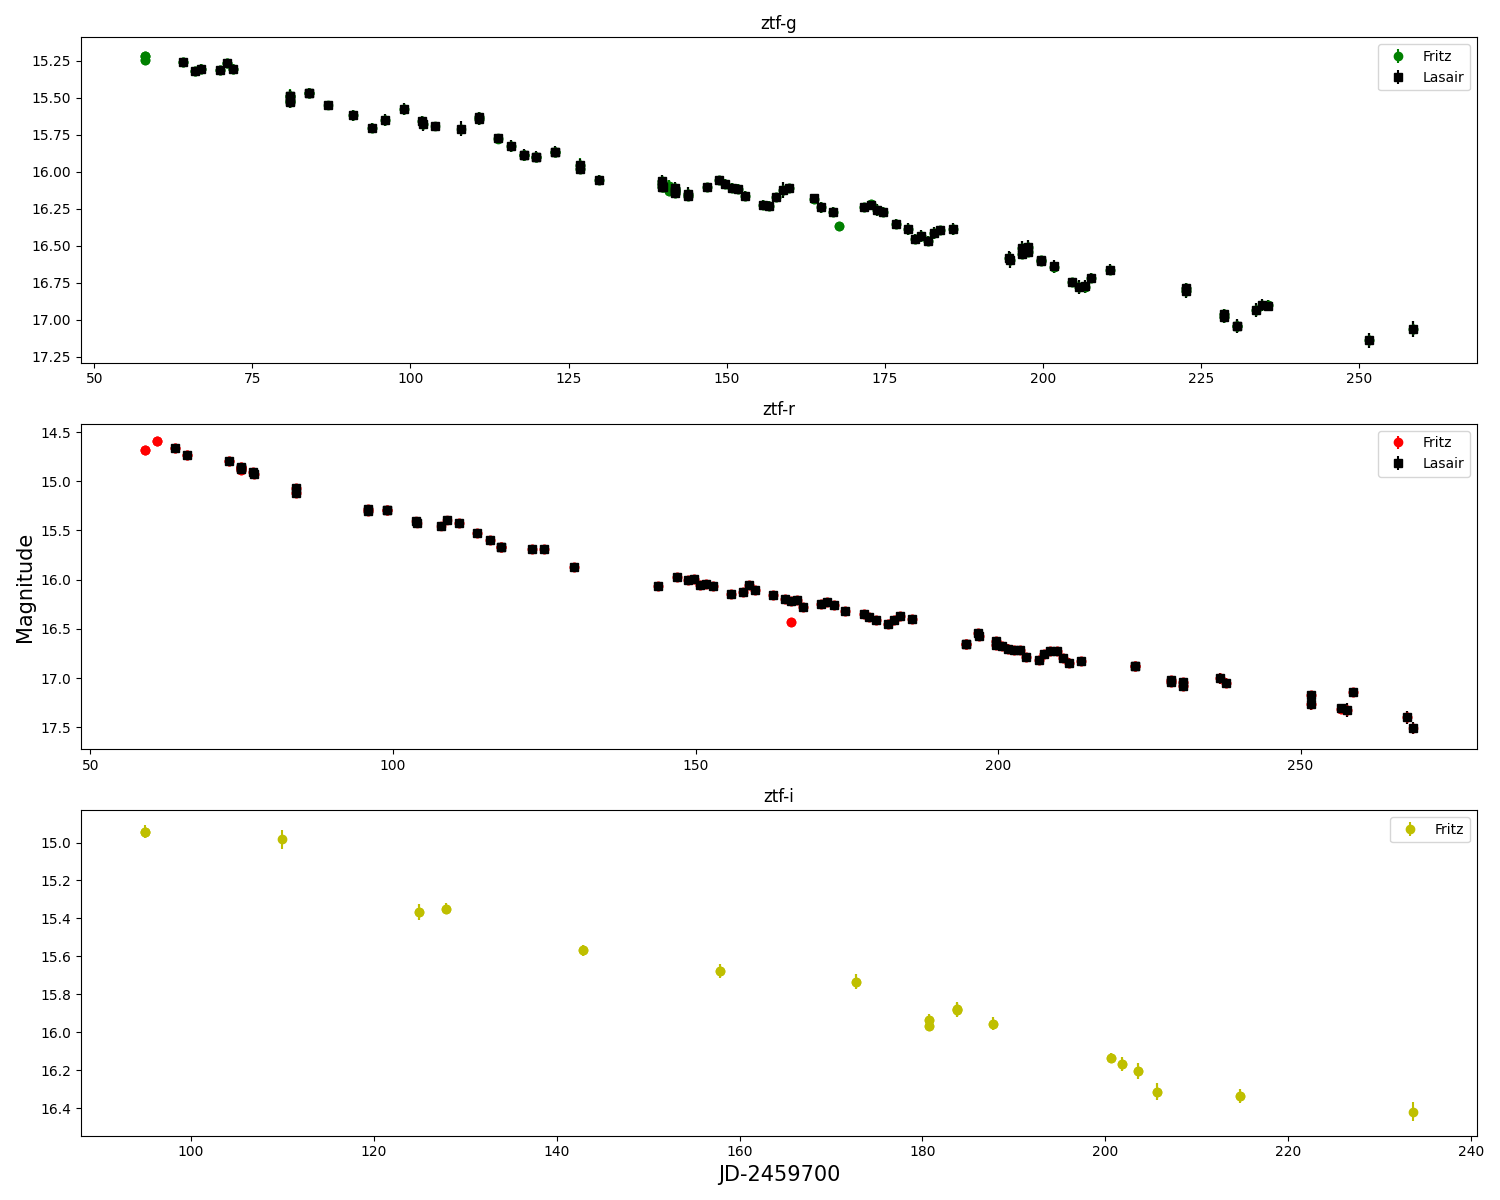

In [10]:
#compare the data set from two sources 

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15,12))
ax1.set_title('SN 2022jli LC')


glc_fritz = lcs_fritz[lcs_fritz['filter']=='ztfg']
xs = glc_fritz['mjd']+2400000.5 - tmaxg_22jli
ys = glc_fritz['mag']
yerrs = glc_fritz['magerr']
ax1.errorbar(xs, ys, yerr=yerrs, fmt='go', ms=6, label='Fritz')

ztfg = np.array([xs, ys, yerrs]).transpose()

ax1.errorbar(lasair_g['mjd']+2400000.5 - tmaxg_22jli,  lasair_g['mag'], yerr=lasair_g['emag'], fmt='ks', label='Lasair')

rlc_fritz = lcs_fritz[lcs_fritz['filter']=='ztfr']
xs = rlc_fritz['mjd']+2400000.5 - tmaxg_22jli
ys = rlc_fritz['mag']
yerrs = rlc_fritz['magerr']
ax2.errorbar(xs, ys, yerr=yerrs, fmt='ro', ms=6, label='Fritz')
ax2.errorbar(lasair_r['mjd']+2400000.5 - tmaxg_22jli,  lasair_r['mag'], yerr=lasair_r['emag'], fmt='ks', label='Lasair')

ztfr = np.array([xs, ys, yerrs]).transpose()

ilc_fritz = lcs_fritz[lcs_fritz['filter']=='ztfi']
xs = ilc_fritz['mjd']+2400000.5 - tmaxg_22jli
ys = ilc_fritz['mag']
yerrs = ilc_fritz['magerr']
ax3.errorbar(xs, ys, yerr=yerrs, fmt='yo', ms=6, label='Fritz')

ztfi = np.array([xs, ys, yerrs]).transpose()

ax3.set_xlabel('JD-%s'%np.round(tmaxg_22jli,3), fontsize=15)
ax2.set_ylabel('Magnitude', fontsize=15)

ax1.invert_yaxis()
ax2.invert_yaxis()
ax3.invert_yaxis()
ax1.set_title('ztf-g')
ax2.set_title('ztf-r')
ax3.set_title('ztf-i')

ax1.legend(loc=0)
ax2.legend(loc=0)
ax3.legend(loc=0)

plt.tight_layout()

### Post Obervatory RC32 telescope

Observer: Richard D. Post

In [11]:
##version use SDSS reference image

phot_u = Table.read('../data/photometry/sn2022jli_PO_up_SDSSref_individual_photometry_info_AP_sub.txt', format='ascii.fixed_width')
phot_u = phot_u[phot_u['drop']==0]
phot_u = phot_u[phot_u['flt']=='up']
RP_u = np.array([phot_u['obstime'].data - tmaxg_22jli, phot_u['calmag'].data, phot_u['calmagerr'].data]).transpose()

phot_g = Table.read('../data/photometry/sn2022jli_PO_gp_SDSSref_individual_photometry_info_AP_sub.txt', format='ascii.fixed_width')
phot_g = phot_g[phot_g['drop']==0]
phot_g = phot_g[phot_g['flt']=='gp']
RP_g = np.array([phot_g['obstime'].data - tmaxg_22jli, phot_g['calmag'].data, phot_g['calmagerr'].data]).transpose()

phot_r = Table.read('../data/photometry/sn2022jli_PO_rp_SDSSref_individual_photometry_info_AP_sub.txt', format='ascii.fixed_width')
phot_r = phot_r[phot_r['drop']==0]
phot_r = phot_r[phot_r['flt']=='rp']
RP_r = np.array([phot_r['obstime'].data - tmaxg_22jli, phot_r['calmag'].data, phot_r['calmagerr'].data]).transpose()

phot_i = Table.read('../data/photometry/sn2022jli_PO_ip_SDSSref_individual_photometry_info_AP_sub.txt', format='ascii.fixed_width')
phot_i = phot_i[phot_i['drop']==0]
phot_i = phot_i[phot_i['flt']=='ip']
RP_i = np.array([phot_i['obstime'].data - tmaxg_22jli, phot_i['calmag'].data, phot_i['calmagerr'].data]).transpose()


phot_z = Table.read('../data/photometry/sn2022jli_PO_zp_SDSSref_individual_photometry_info_AP_sub.txt', format='ascii.fixed_width')
phot_z = phot_z[phot_z['drop']==0]
phot_z = phot_z[phot_z['flt']=='zp']
RP_z = np.array([phot_z['obstime'].data - tmaxg_22jli, phot_z['calmag'].data, phot_z['calmagerr'].data]).transpose()

<IPython.core.display.Javascript object>


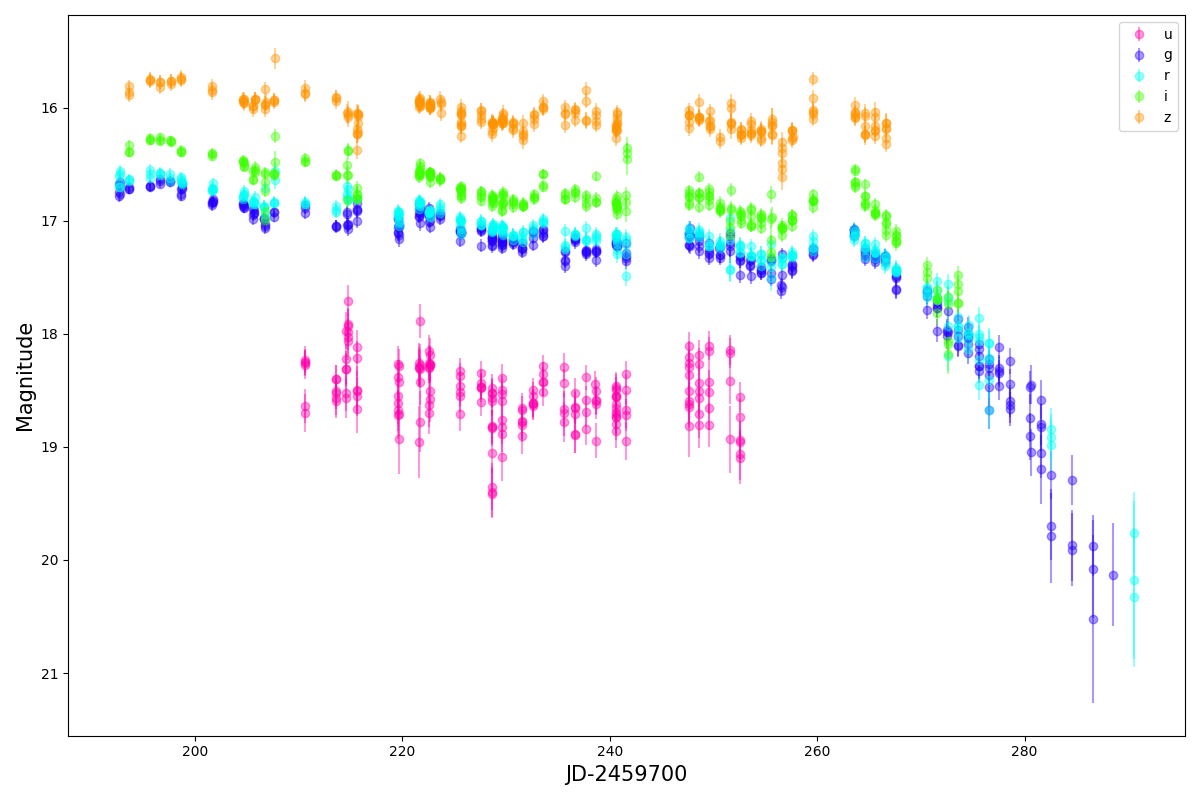

In [15]:
#show light curve from PO 

cmap = mpl.cm.hsv
Ncompare= 6
norm = mpl.colors.Normalize(vmin=0, vmax=6)

fig, ax = plt.subplots(figsize=(12,8))

ax.errorbar(RP_u[:,0], RP_u[:,1], yerr=RP_u[:,2], fmt='o', color=cmap(0.9), alpha=0.4, label='u')
ax.errorbar(RP_g[:,0], RP_g[:,1], yerr=RP_g[:,2], fmt='o', color=cmap(0.7), alpha=0.4, label='g')
ax.errorbar(RP_r[:,0], RP_r[:,1], yerr=RP_r[:,2], fmt='o', color=cmap(0.5), alpha=0.4, label='r')
ax.errorbar(RP_i[:,0], RP_i[:,1], yerr=RP_i[:,2], fmt='o', color=cmap(0.3), alpha=0.4, label='i')
ax.errorbar(RP_z[:,0], RP_z[:,1], yerr=RP_z[:,2], fmt='o', color=cmap(0.1), alpha=0.4, label='z')

ax.invert_yaxis()
ax.legend(loc=0)

ax.set_xlabel('JD-%s'%np.round(tmaxg_22jli,3), fontsize=15)
ax.set_ylabel('Magnitude', fontsize=15)

plt.tight_layout()

### P60/SEDM

g,r,i images taken but only r and i-band photometry successfully obtained 

In [16]:


p60_phot_r = Table.read('../data/photometry/sn2022jli_P60_r_external_ref_photometry_info_AP_sub.txt', format='ascii.fixed_width')
p60_phot_r = p60_phot_r[p60_phot_r['drop']==0]
p60_phot_r = p60_phot_r[p60_phot_r['flt']=='rp']
p60rp = np.array([p60_phot_r['obstime'].data -tmaxg_22jli, p60_phot_r['calmag'].data,p60_phot_r['calmagerr'].data]).transpose()


p60_phot_i = Table.read('../data/photometry/sn2022jli_P60_i_external_ref_photometry_info_AP_sub.txt', format='ascii.fixed_width')
p60_phot_i = p60_phot_i[p60_phot_i['drop']==0]
p60_phot_i = p60_phot_i[p60_phot_i['flt']=='ip']
p60ip = np.array([p60_phot_i['obstime'].data-tmaxg_22jli, p60_phot_i['calmag'].data,p60_phot_i['calmagerr'].data]).transpose()

<IPython.core.display.Javascript object>


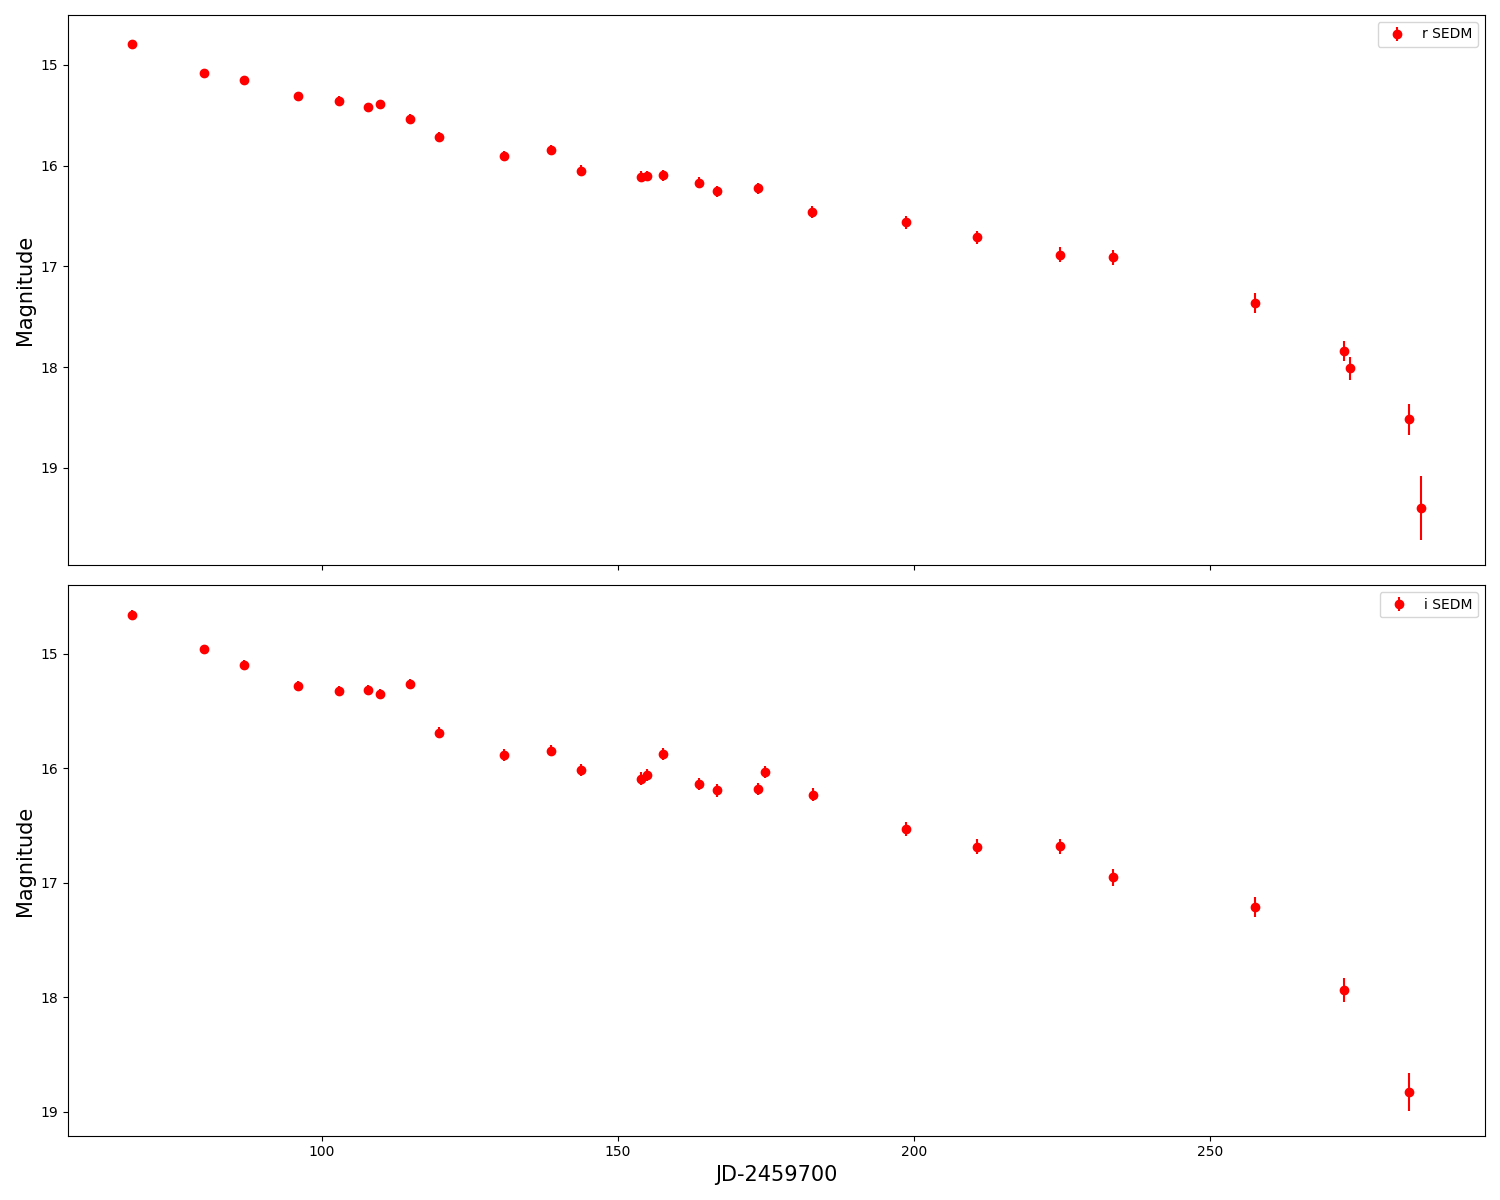

In [23]:
fig, (ax, ax2) = plt.subplots(2,1, figsize=(15,12), sharex=True)


ax.errorbar(p60rp[:,0], p60rp[:,1], yerr=p60rp[:,2], fmt='ro', label='r SEDM')
ax2.errorbar(p60ip[:,0], p60ip[:,1], yerr=p60ip[:,2], fmt='ro', label='i SEDM')


ax.invert_yaxis()
ax2.invert_yaxis()

ax.legend(loc=0)
ax2.legend(loc=0)

ax2.set_xlabel('JD-2459700', fontsize=15)
ax.set_ylabel('Magnitude', fontsize=15)
ax2.set_ylabel('Magnitude', fontsize=15)


plt.tight_layout()


#### a comparison among P48, P60 and PO RC32

find the constant offset in magnitude to bring photometry from different instruments to the same flux as ZTF P48

<IPython.core.display.Javascript object>


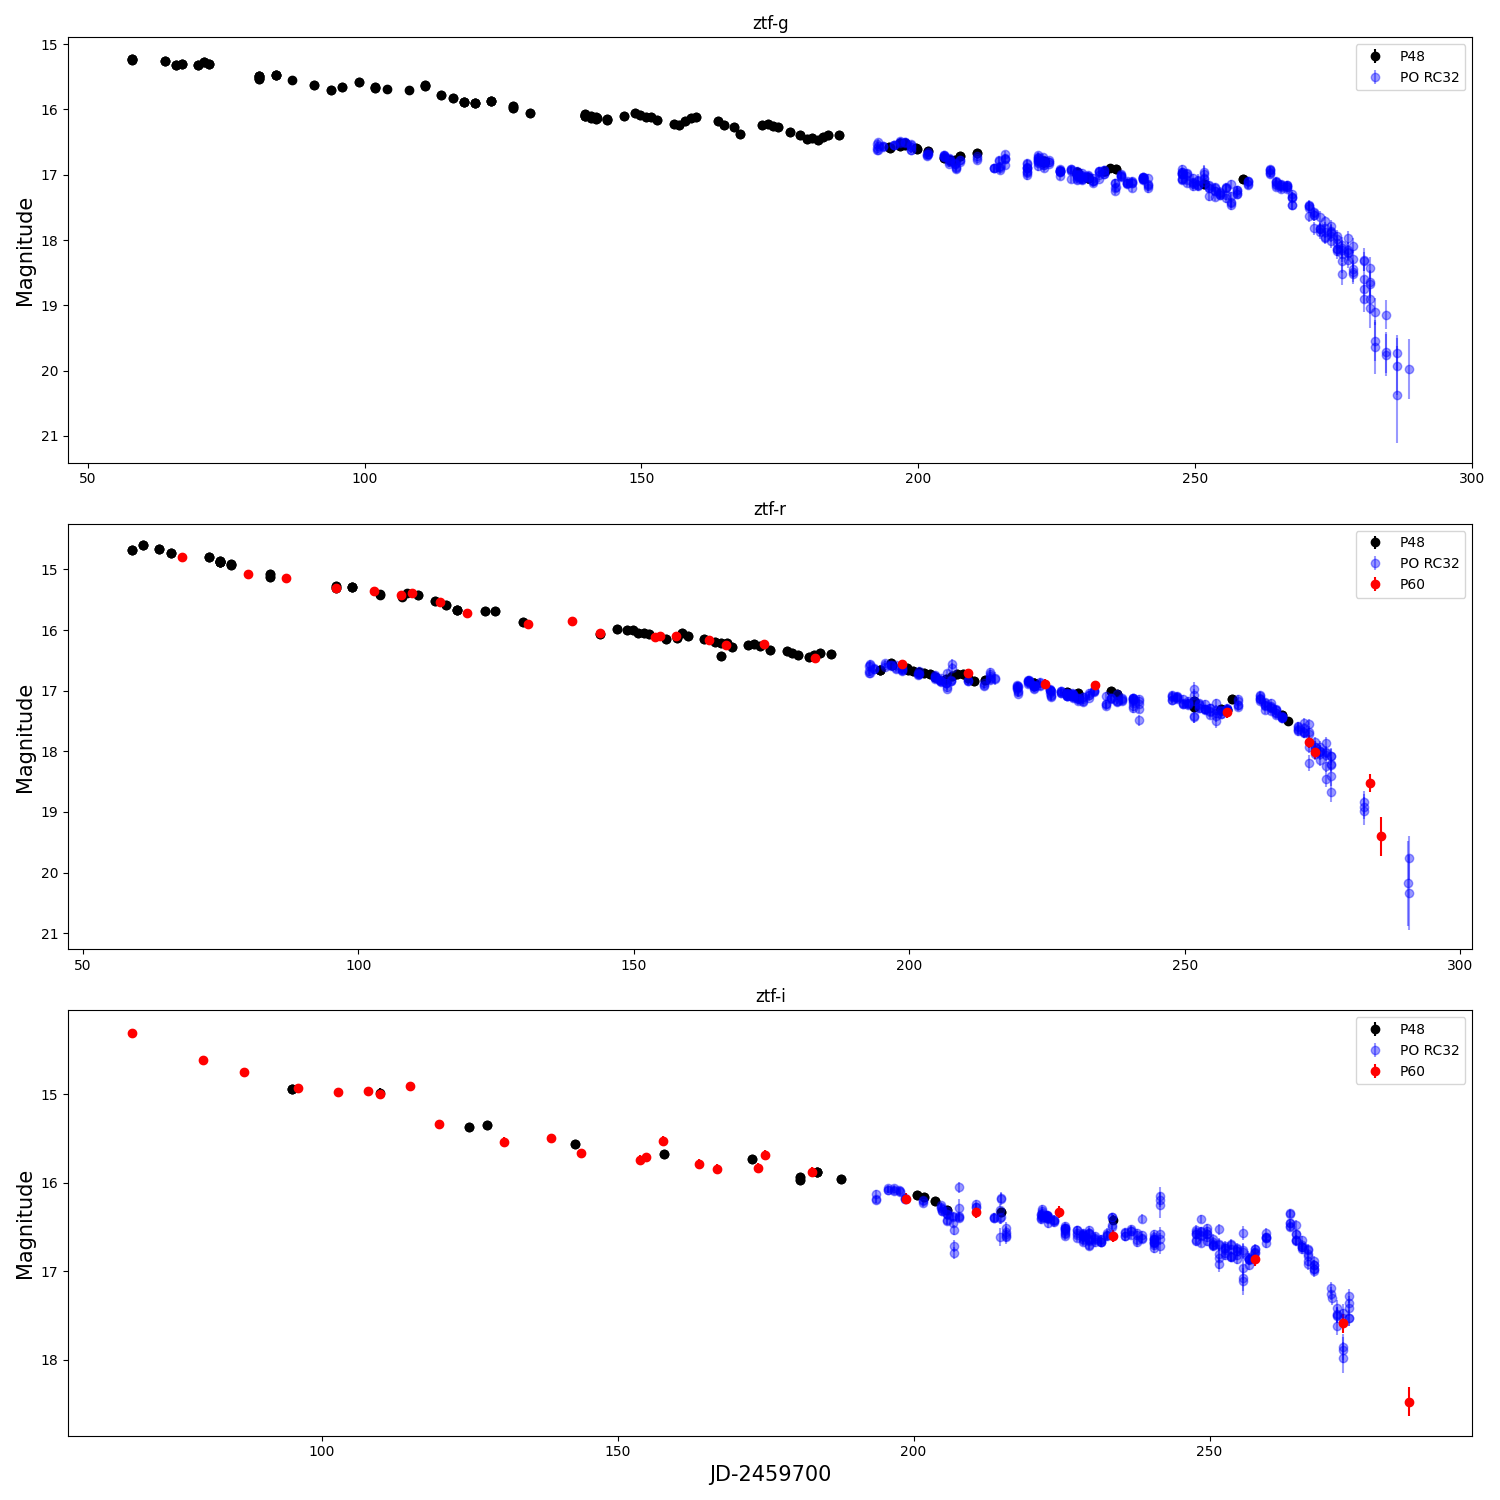

In [28]:

fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(15,15), )


#ZTF P48
ax1.errorbar(ztfg[:,0], ztfg[:,1], yerr= ztfg[:,2], fmt='ko', label='P48')
ax2.errorbar(ztfr[:,0], ztfr[:,1], yerr= ztfr[:,2], fmt='ko', label='P48')
ax3.errorbar(ztfi[:,0], ztfi[:,1], yerr= ztfi[:,2], fmt='ko', label='P48')


#PO
ax1.errorbar(RP_g[:,0], RP_g[:,1]-0.15, yerr=RP_g[:,2], fmt='bo' , alpha=0.4, label='PO RC32')
ax2.errorbar(RP_r[:,0], RP_r[:,1], yerr=RP_r[:,2], fmt='bo',  alpha=0.4, label='PO RC32')
ax3.errorbar(RP_i[:,0], RP_i[:,1]-0.2, yerr=RP_i[:,2], fmt='bo',  alpha=0.4, label='PO RC32')

#P60
ax2.errorbar(p60rp[:,0], p60rp[:,1], yerr=p60rp[:,2], fmt='ro', label='P60')
ax3.errorbar(p60ip[:,0], p60ip[:,1]-0.35, yerr=p60ip[:,2], fmt='ro', label='P60')


ax1.legend(loc=0)
ax2.legend(loc=0)
ax3.legend(loc=0)

ax1.set_title('ztf-g')
ax2.set_title('ztf-r')
ax3.set_title('ztf-i')


ax1.invert_yaxis()
ax2.invert_yaxis()
ax3.invert_yaxis()

ax3.set_xlabel('JD-%s'%np.round(tmaxg_22jli,3), fontsize=15)
ax1.set_ylabel('Magnitude', fontsize=15)
ax2.set_ylabel('Magnitude', fontsize=15)
ax3.set_ylabel('Magnitude', fontsize=15)

plt.tight_layout()

### ATLAS

extracted from https://fallingstar-data.com/forcedphot/

['##MJD', 'm', 'dm', 'uJy', 'duJy', 'F', 'err', 'chi/N', 'RA', 'Dec', 'x', 'y', 'maj', 'min', 'phi', 'apfit', 'mag5sig', 'Sky', 'Obs']


<IPython.core.display.Javascript object>


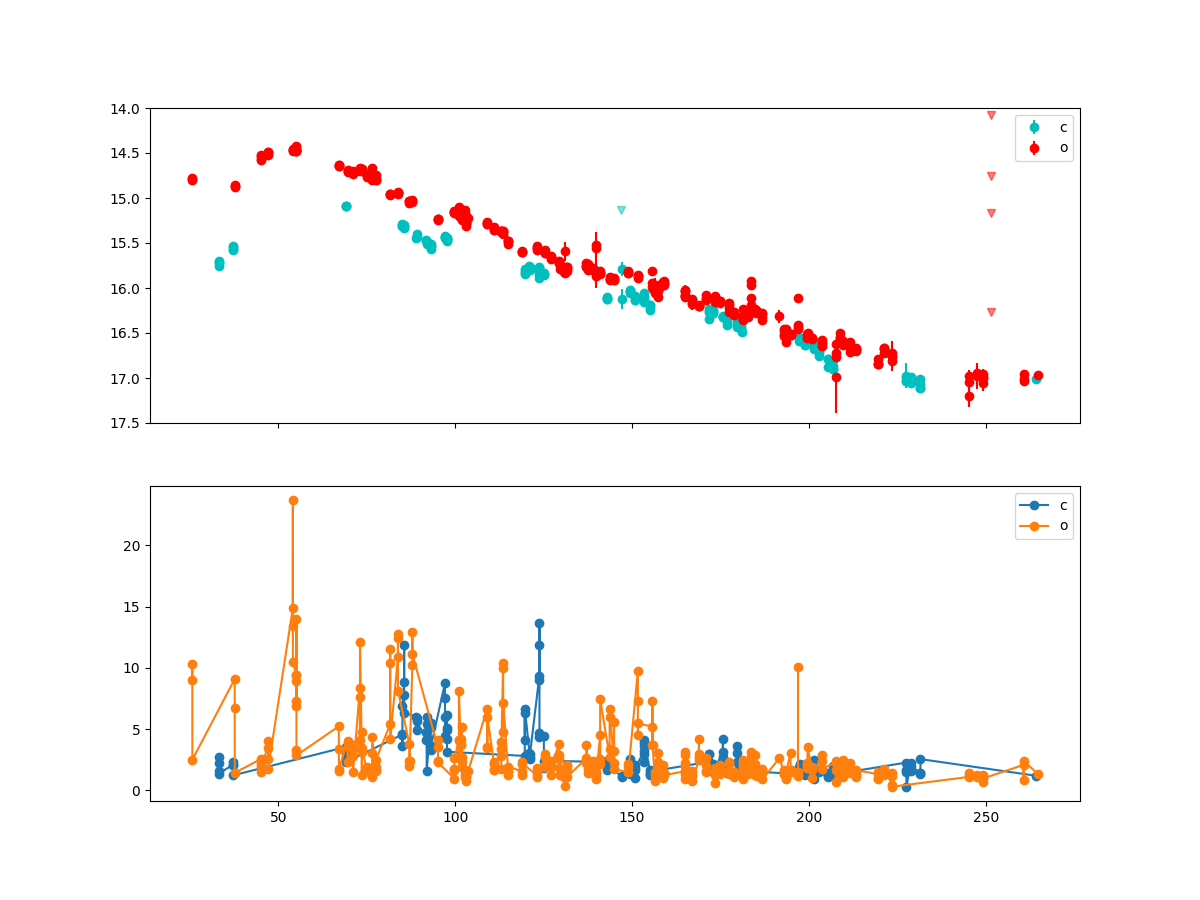

c
o


In [30]:
infile = '../data/photometry/sn2022jli_ATLAS_20230218.txt' #this is the final version extracted on 2023-02-18
snname = 'sn2022jli'

show_lcs = 1
show_upperlimit=1

data = Table.read(infile, format='ascii')
print(data.colnames)
#['##MJD', 'm', 'dm', 'uJy', 'duJy', 'F', 'err', 'chi/N', 'RA', 'Dec', 'x', 'y', 'maj', 'min', 'phi', 'apfit', 'mag5sig', 'Sky', 'Obs']


uplm_mask = np.logical_or(np.absolute(data['m'])>data['mag5sig'],data['m']==0)
#print(uplm_mask)
data['m'][uplm_mask] = data['mag5sig'][uplm_mask]
data['dm'][uplm_mask] = 99.99

#lcs = data[['##MJD','m','dm', 'F']]
lcs = data.copy()
#print(lcs)
lcs['##MJD'] = lcs['##MJD']+2400000.5
lcs['##MJD'].name = 'JD'

colors = {'c':'c', 'o':'r', 'H':'m'}
#print(np.unique(lcs['F']))


fig, (ax, ax2) =plt.subplots(2,1, figsize=(12,9), sharex=True)

for flt in np.unique(lcs['F']):
        print(flt)
        fltlc = lcs[lcs['F']==flt]
        fltlc.write('../data/photometry/%s_ATLAS-%s.txt'%(snname, flt), format='ascii.commented_header', overwrite=1)
        
        uplm_mask = fltlc['dm'] == 99.99
        ax.errorbar(fltlc['JD'][~uplm_mask]-tmaxg_22jli, fltlc['m'][~uplm_mask], yerr=fltlc['dm'][~uplm_mask], fmt=colors[flt]+'o', label=flt)
        
        ax2.plot(fltlc['JD'][~uplm_mask]-tmaxg_22jli, fltlc['chi/N'][~uplm_mask], 'o-', label=flt)
        
        if show_upperlimit:
                ax.plot(fltlc['JD'][uplm_mask]-tmaxg_22jli, fltlc['m'][uplm_mask], colors[flt]+'v', alpha=0.5)
                        
        if flt == 'c':            
            atlas_c = np.array([fltlc['JD'][~uplm_mask]-tmaxg_22jli, fltlc['m'][~uplm_mask], fltlc['dm'][~uplm_mask]]).transpose()
        else:
            atlas_o = np.array([fltlc['JD'][~uplm_mask]-tmaxg_22jli, fltlc['m'][~uplm_mask], fltlc['dm'][~uplm_mask]]).transpose()
                    
ax.set_ylim([14,17.5])
ax.invert_yaxis()
ax.legend(loc=0)
ax2.legend(loc=0)

### Libert Monard

from TNS

In [31]:
#Mr. Libert Monard (Kleinkaroo Observatory)

#2022 may 05.17:  14.22 (+/-.15) CR
#2022 may 06.16:  14.33 (+/-.05) CR
#2022 may 11.16: 14.29 (+/-.05) CR
#2022 may 22.17: 14.44 (+/-.04) CR

lcs_22jli_LM = np.array([[2459704.67, 2459705.66, 2459710.66, 2459721.67],[14.22, 14.33, 14.29, 14.44],[0.15, 0.05, 0.05, 0.04]]).transpose()
lcs_22jli_LM[:,0] = lcs_22jli_LM[:,0]-tmaxg_22jli

### Gaia

from Gaia transient alert 


In [32]:
#Gaia

lcs_22jli_gaia = Table.read('../data/photometry/sn2022jli_Gaia_LC_data.csv', format='ascii.csv')
lcs_22jli_gaia


<Table length=84>
        Date           JD(TCB)    averagemag
       str19           float64       str5   
------------------- ------------- ----------
2014-08-12 08:43:22 2456881.86345       null
2014-08-12 10:30:07 2456881.93758       null
2014-08-12 14:43:53 2456882.11381       null
2014-08-12 16:30:04 2456882.18755       null
2014-08-12 20:43:50 2456882.36377       null
2015-01-23 20:14:23 2457046.34332       null
2015-01-24 00:28:06 2457046.51951       null
2015-02-06 00:32:45 2457059.52274       null
2015-02-06 02:19:29 2457059.59686       null
2015-02-06 06:33:13 2457059.77307       null
                ...           ...        ...
2021-12-21 10:23:13 2459569.93279       null
2022-01-25 01:53:49 2459604.57904       null
2022-01-25 03:40:33 2459604.65316       null
2022-02-06 13:59:17 2459617.08284       null
2022-02-06 15:46:01 2459617.15696       null
2022-05-11 17:39:39 2459711.23587      14.61
2022-05-11 21:53:20 2459711.41204      14.60
2022-05-23 16:02:05 2459723.16811      14.85
2022-05-23 17:48:40 2459723.24213      14.86
2022-06-30 11:16:25 2459760.96973      14.67

### ASAS-SN

from ASAS-SN sky patrol service


<IPython.core.display.Javascript object>


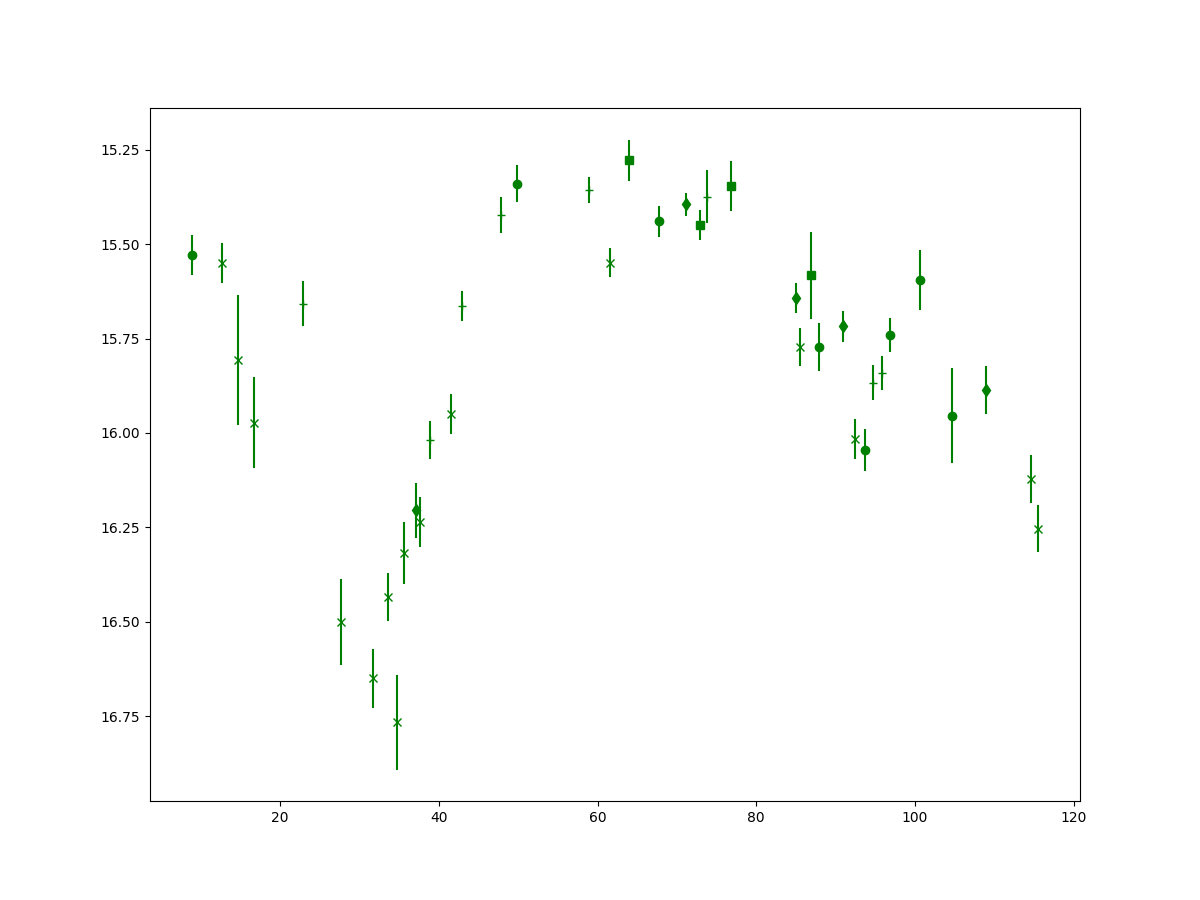

359.009354536945


In [37]:
lcs_22jli_asas = Table.read('../data/photometry/sn2022jli_ASAS-SN_g_SkyPatrol.csv', format='ascii.csv')



fig, ax = plt.subplots(figsize=(12,9))
    

#ASAS-SN    
detections = lcs_22jli_asas[lcs_22jli_asas['HJD']>2459706]
detections['mag'] = detections['mag'].astype(float)

distinguish_asas_camera = 1
if distinguish_asas_camera:  
    mask = detections['Camera']=='bD'
    ax.errorbar(detections['HJD'][mask]-tmaxg_22jli, detections['mag'][mask], yerr=detections['mag_err'][mask], fmt='gd', label='SN 2022jli g')
    mask = detections['Camera']=='bH'
    ax.errorbar(detections['HJD'][mask]-tmaxg_22jli, detections['mag'][mask], yerr=detections['mag_err'][mask], fmt='go', label='SN 2022jli g')
    mask = detections['Camera']=='bl'
    ax.errorbar(detections['HJD'][mask]-tmaxg_22jli, detections['mag'][mask], yerr=detections['mag_err'][mask], fmt='g+', label='SN 2022jli g')
    mask = detections['Camera']=='bt'
    ax.errorbar(detections['HJD'][mask]-tmaxg_22jli, detections['mag'][mask], yerr=detections['mag_err'][mask], fmt='gs', label='SN 2022jli g')
    mask = detections['Camera']=='bp'
    ax.errorbar(detections['HJD'][mask]-tmaxg_22jli, detections['mag'][mask], yerr=detections['mag_err'][mask], fmt='gx', label='SN 2022jli g')
else:
    ax.errorbar(detections['HJD']-tmaxg_22jli, detections['mag'], yerr=detections['mag_err'], fmt='gx', label='ASAS-SN g')

    
    
fs = 10**(detections['mag']/(-2.5))*3.631e9
deltaf = 0.2*np.mean(fs)
print(deltaf)
deltams = -2.5*np.log10(1+deltaf/fs)
detections['mag'] = detections['mag']+deltams #this is to correct the difference between ZTF and ASAS-SN g-band data by adding brightness dependent offsets in magnitude 


asas_g = np.array([detections['HJD']-tmaxg_22jli, detections['mag'], detections['mag_err']]).transpose()
    
    
ax.invert_yaxis()

<IPython.core.display.Javascript object>


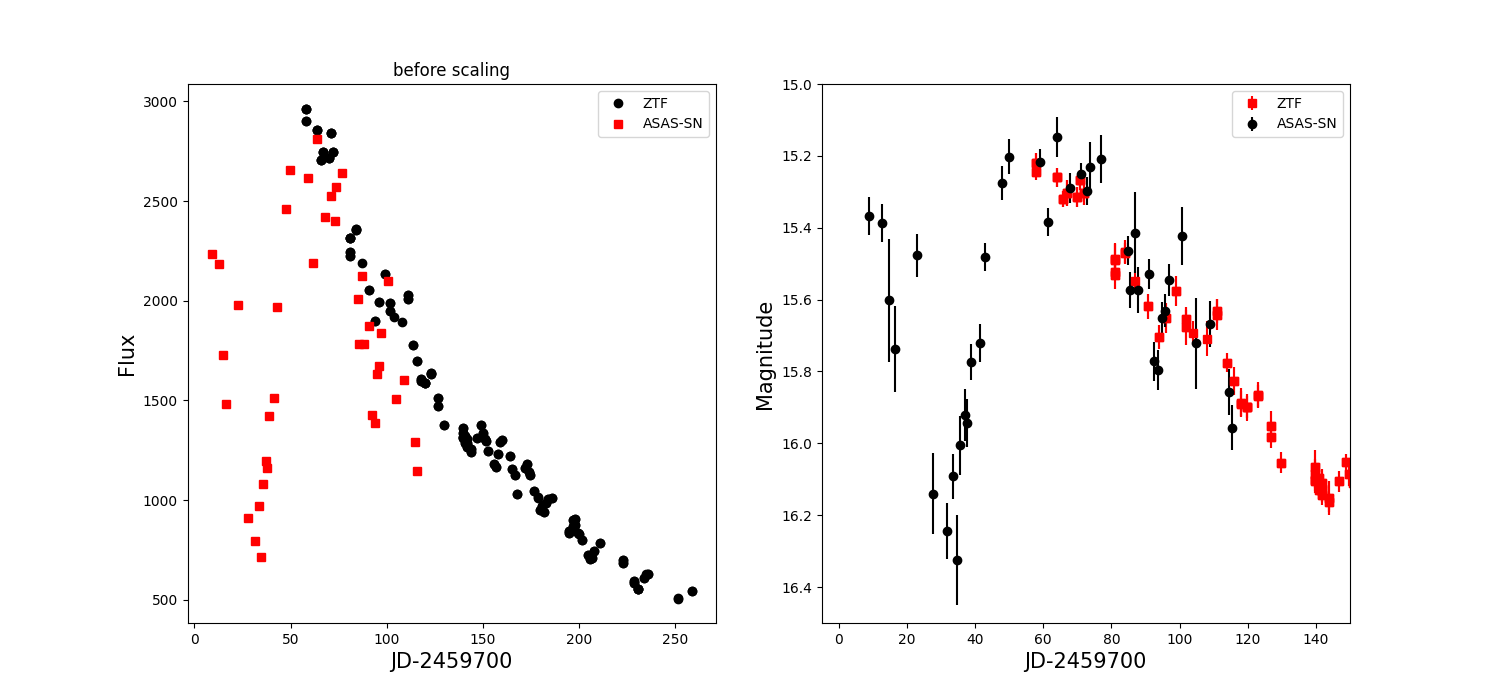

Text(0, 0.5, 'Magnitude')

In [40]:

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,7))

detections = lcs_22jli_asas[lcs_22jli_asas['HJD']>2459706]
detections['mag'] = detections['mag'].astype(float)
fs_asas = 10**(detections['mag']/(-2.5))*3.631e9 
fs_ztf =  10**(ztfg[:,1]/(-2.5))*3.631e9
ax1.plot(ztfg[:,0], fs_ztf, 'ko', label='ZTF')
ax1.plot(detections['HJD']-tmaxg_22jli, fs_asas, 'rs', label='ASAS-SN')

ax2.errorbar(ztfg[:,0], ztfg[:,1], yerr=ztfg[:,2], fmt='rs', label='ZTF')
ax2.errorbar(asas_g[:,0], asas_g[:,1], yerr=asas_g[:,2], fmt='ko', label='ASAS-SN')

ax2.set_xlim([-5, 150])
ax2.set_ylim([15, 16.5])
ax2.invert_yaxis()

ax1.legend(loc=0)
ax2.legend(loc=0)

ax1.set_title('before scaling')
ax1.set_xlabel('JD-%s'%np.round(tmaxg_22jli,3), fontsize=15)
ax2.set_xlabel('JD-%s'%np.round(tmaxg_22jli,3), fontsize=15)
ax1.set_ylabel('Flux', fontsize=15)
ax2.set_ylabel('Magnitude', fontsize=15)

### Mephisto

<IPython.core.display.Javascript object>


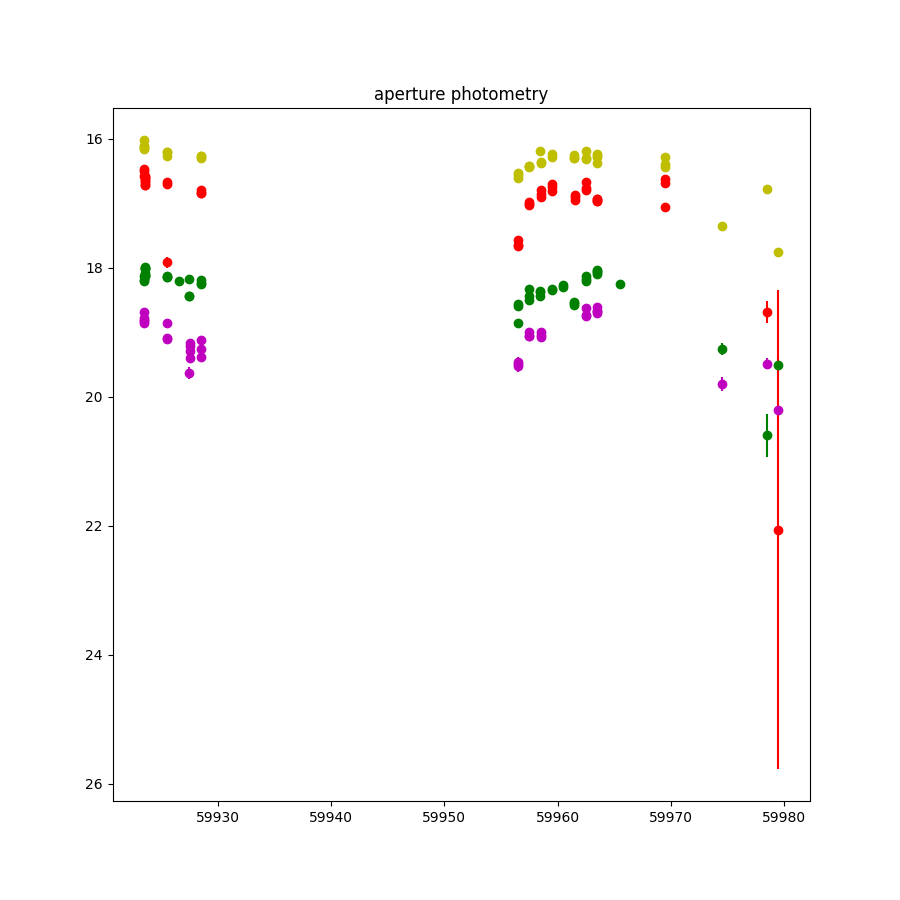

<ipython-input-44-383dcb729014>:26: RuntimeWarning: invalid value encountered in log10
  ax.errorbar(meph_z['mjd_obs'], -2.5*np.log10(meph_z['flux_aper']+zref)+ meph_z['mag_zeropoint'], yerr=1.0857*np.sqrt(e_zref**2+meph_z['flux_aper_err']**2)/(meph_z['flux_aper']+zref), fmt='ro')


<IPython.core.display.Javascript object>


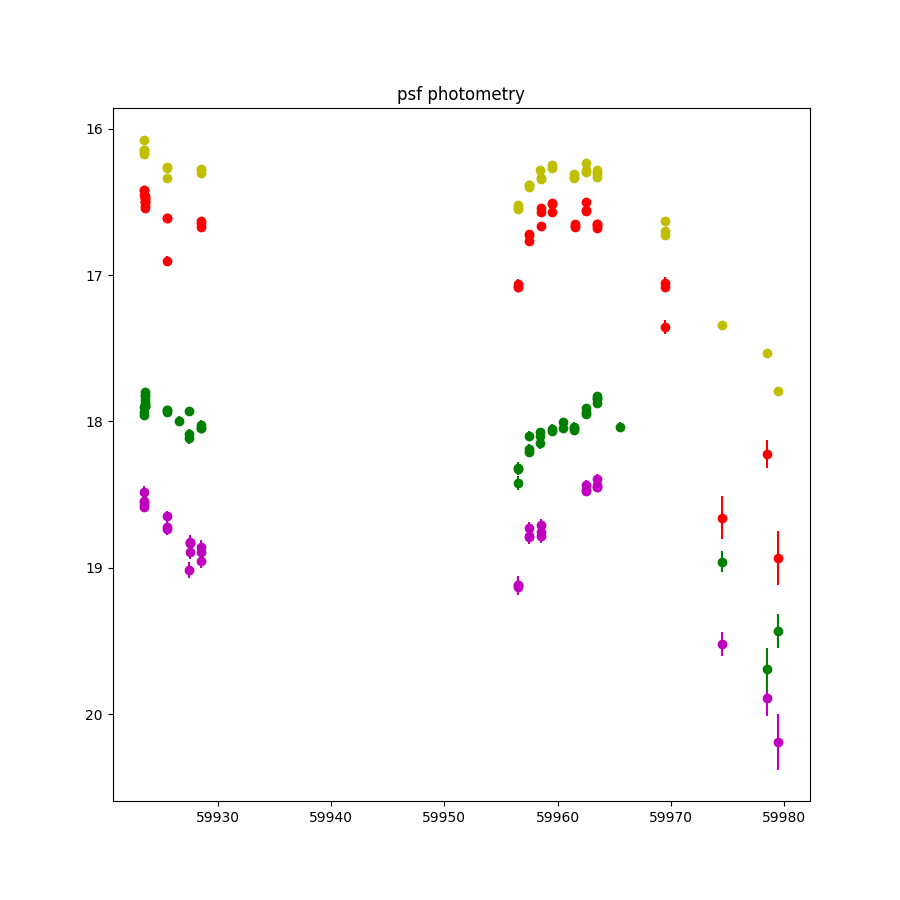

In [44]:
meph_u = Table.read('../data/photometry/sn2022jli_Mephisto_u_lightCurve.cat', format='ascii')
meph_v = Table.read('../data/photometry/sn2022jli_Mephisto_v_lightCurve.cat', format='ascii')
meph_i = Table.read('../data/photometry/sn2022jli_Mephisto_i_lightCurve.cat', format='ascii')
meph_z = Table.read('../data/photometry/sn2022jli_Mephisto_z_lightCurve.cat', format='ascii')

uref = 27.15
e_uref = 3.74

vref = 46.08
e_vref = 4.52

iref = 221.63
e_iref = 4.49

zref = 29.15
e_zref = 5.22


## aperture photometry

fig, ax = plt.subplots(figsize=(9,9))

ax.errorbar(meph_u['mjd_obs'], -2.5*np.log10(meph_u['flux_aper']+uref)+ meph_u['mag_zeropoint'], yerr=1.0857*np.sqrt(e_uref**2+meph_u['flux_aper_err']**2)/(meph_u['flux_aper']+uref), fmt='mo')
ax.errorbar(meph_v['mjd_obs'], -2.5*np.log10(meph_v['flux_aper']+vref)+ meph_v['mag_zeropoint'], yerr=1.0857*np.sqrt(e_vref**2+meph_v['flux_aper_err']**2)/(meph_v['flux_aper']+vref), fmt='go')
ax.errorbar(meph_i['mjd_obs'], -2.5*np.log10(meph_i['flux_aper']+iref)+ meph_i['mag_zeropoint'], yerr=1.0857*np.sqrt(e_iref**2+meph_i['flux_aper_err']**2)/(meph_i['flux_aper']+iref), fmt='yo')
ax.errorbar(meph_z['mjd_obs'], -2.5*np.log10(meph_z['flux_aper']+zref)+ meph_z['mag_zeropoint'], yerr=1.0857*np.sqrt(e_zref**2+meph_z['flux_aper_err']**2)/(meph_z['flux_aper']+zref), fmt='ro')

ax.invert_yaxis()
ax.set_title('aperture photometry')


## PSF photometry


fig, ax = plt.subplots(figsize=(9,9))

ax.errorbar(meph_u['mjd_obs'], -2.5*np.log10(meph_u['flux_psf']+uref)+ meph_u['mag_zeropoint'], yerr=1.0857*np.sqrt(e_uref**2+meph_u['flux_psf_err']**2)/(meph_u['flux_psf']+uref), fmt='mo')
ax.errorbar(meph_v['mjd_obs'], -2.5*np.log10(meph_v['flux_psf']+vref)+ meph_v['mag_zeropoint'], yerr=1.0857*np.sqrt(e_vref**2+meph_v['flux_psf_err']**2)/(meph_v['flux_psf']+vref), fmt='go')
ax.errorbar(meph_i['mjd_obs'], -2.5*np.log10(meph_i['flux_psf']+iref)+ meph_i['mag_zeropoint'], yerr=1.0857*np.sqrt(e_iref**2+meph_i['flux_psf_err']**2)/(meph_i['flux_psf']+iref), fmt='yo')
ax.errorbar(meph_z['mjd_obs'], -2.5*np.log10(meph_z['flux_psf']+zref)+ meph_z['mag_zeropoint'], yerr=1.0857*np.sqrt(e_zref**2+meph_z['flux_psf_err']**2)/(meph_z['flux_psf']+zref), fmt='ro')
ax.invert_yaxis()
ax.set_title('psf photometry')


## get the photometry table 

meph_u = np.array([meph_u['mjd_obs']+2400000.5-tmaxg_22jli, -2.5*np.log10(meph_u['flux_psf']+uref)+ meph_u['mag_zeropoint'], 1.0857*np.sqrt(e_uref**2+meph_u['flux_psf_err']**2)/(meph_u['flux_psf']+uref)]).transpose()
meph_v = np.array([meph_v['mjd_obs']+2400000.5-tmaxg_22jli, -2.5*np.log10(meph_v['flux_psf']+vref)+ meph_v['mag_zeropoint'], 1.0857*np.sqrt(e_vref**2+meph_v['flux_psf_err']**2)/(meph_v['flux_psf']+vref)]).transpose()
meph_i = np.array([meph_i['mjd_obs']+2400000.5-tmaxg_22jli, -2.5*np.log10(meph_i['flux_psf']+iref)+ meph_i['mag_zeropoint'], 1.0857*np.sqrt(e_iref**2+meph_i['flux_psf_err']**2)/(meph_i['flux_psf']+iref)]).transpose()
meph_z = np.array([meph_z['mjd_obs']+2400000.5-tmaxg_22jli, -2.5*np.log10(meph_z['flux_psf']+zref)+ meph_z['mag_zeropoint'], 1.0857*np.sqrt(e_zref**2+meph_z['flux_psf_err']**2)/(meph_z['flux_psf']+zref)]).transpose()

meph_u_table = Table(meph_u, names=['epoch', 'mag', 'emag'])
meph_u_table.add_column(Column(['u']*len(meph_u_table), name='flt'))
meph_v_table = Table(meph_v, names=['epoch', 'mag', 'emag'])
meph_v_table.add_column(Column(['v']*len(meph_v_table), name='flt'))
meph_i_table = Table(meph_i, names=['epoch', 'mag', 'emag'])
meph_i_table.add_column(Column(['i']*len(meph_i_table), name='flt'))
meph_z_table = Table(meph_z, names=['epoch', 'mag', 'emag'])
meph_z_table.add_column(Column(['z']*len(meph_z_table), name='flt'))


meph_table = vstack([meph_u_table, meph_v_table, meph_i_table, meph_z_table])
meph_table.sort('epoch')



meph_table.write('../data/photometry/sn2022jli_photometry_mephisto.tex', format='ascii.aastex', overwrite=True)

## Get the light curve table

In [46]:
jds = []
epochs = []
mags_str = []
mags = []
magerrs = []
sources = []
filters = []


data_list   = [asas_g,     atlas_c, atlas_o, p60rp, p60ip, ztfg, ztfr,  ztfi,  meph_u,  meph_v, meph_i, meph_z, RP_u, RP_g, RP_r, RP_i, RP_z]
source_list = ['ASAS-SN', 'ATLAS', 'ATLAS', 'P60', 'P60', 'ZTF', 'ZTF', 'ZTF', 'Mephisto', 'Mephisto', 'Mephisto', 'Mephisto', 'PO', 'PO', 'PO','PO', 'PO']
filter_list = ['g', 'c', 'o', 'r', 'i', 'g','r','i', 'u', 'v', 'i', 'z', 'u', 'g', 'r', 'i', 'z']


for data, source, flt in zip(data_list, source_list, filter_list):
    for epoch, mag, magerr in data:
        jd = epoch+tmaxg_22jli
        if epoch <10:
            nljust = 6
        elif epoch<100:
            nljust = 7
        else:
            nljust = 8
        epoch = str(np.round(epoch, 4)).ljust(nljust, '0')
        mag_str = '%s$\pm$%s'%(str(np.round(mag, 3)).ljust(6, '0'), str(np.round(magerr ,3)).ljust(5, '0'))
        #print(epoch, mag)
        jds.append(np.round(jd, 5))
        epochs.append(epoch)
        mags_str.append(mag_str)
        mags.append(np.round(mag, 3))
        magerrs.append(np.round(magerr, 3))
        sources.append(source)
        filters.append(flt)

    
sn2022jli_phot_table = Table([jds, epochs, mags_str, sources, filters], names=['jd', 'epoch', 'mag', 'source', 'filter'])
sn2022jli_phot_table.sort('jd')

sn2022jli_phot_table_latex = sn2022jli_phot_table[['epoch', 'mag', 'source','filter']]
sn2022jli_phot_table_latex.write('../data/photometry/sn2022jli_photometry_data.tex', format='ascii.latex', overwrite=True)

## Light curve plot

### load spec info

In [48]:
import pickle

specfile = '/Users/chenping/SNeData/Ping_collections/SNe_spectra/2022jli.20230330.p'
with open(specfile, 'rb') as fp:
    specs_22jli = pickle.load(fp)

spectable = specs_22jli['spectable']
spectable.sort('phase')


#FIRE spectra 
jd_fire1 = 2459817.823958333
jd_fire2 =  2459928.559699074

#TNS public spectra
jd_psh = 2459710.64375
jd_efosc = 2459723.917025463

print(spectable.colnames)

['specname', 'phase', 'bump_phase', 'date', 'jd', 'specfile', 'telescope', 'instrument', 'exptime']


### show the light curves

<IPython.core.display.Javascript object>


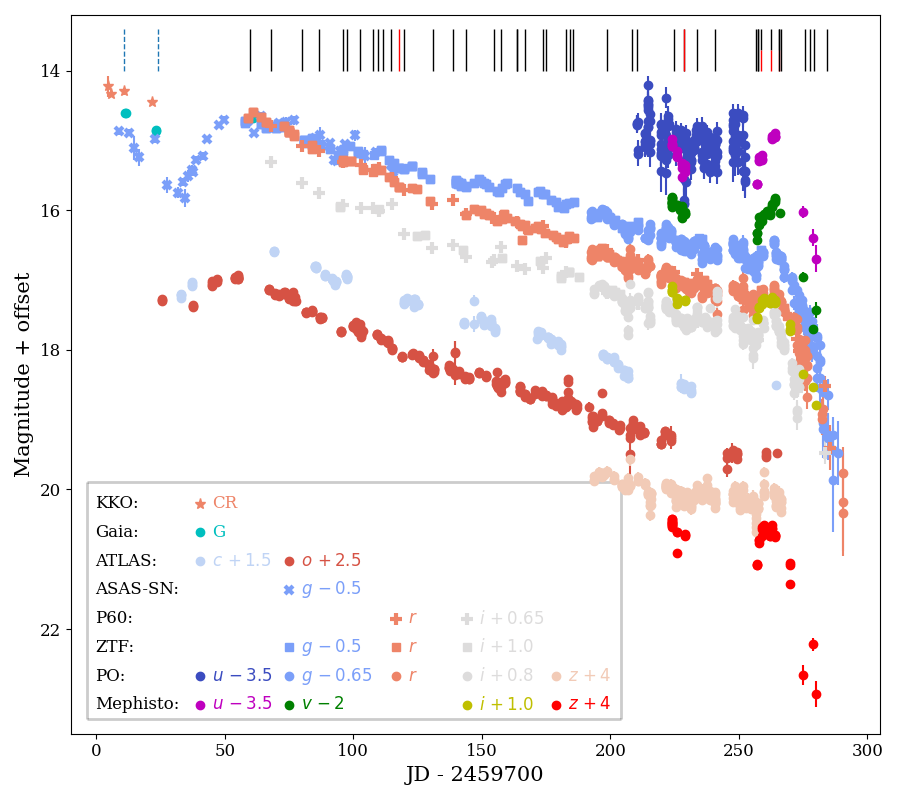

In [49]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'serif'


cmap = mpl.cm.coolwarm
Nflt  = 7
norm = mpl.colors.Normalize(vmin=0, vmax=Nflt)


fig, ax = plt.subplots(1,1, figsize=(9,8))

# u band
u_color= cmap(0.)
u_offset = -3.5
ax.errorbar(RP_u[:,0], RP_u[:,1]+u_offset, yerr=RP_u[:,2], fmt='o', color=u_color, label='u')

# g band
g_color= cmap(0.2)
g_offset = -0.5
RP_g_offset = -0.15
ax.errorbar(RP_g[:,0],  RP_g[:,1]+g_offset+RP_g_offset, yerr=RP_g[:,2], fmt='o', color=g_color, label='g')
ax.errorbar(ztfg[:,0],  ztfg[:,1]+g_offset, yerr=ztfg[:,2], fmt='s', color=g_color)
ax.errorbar(asas_g[:,0], asas_g[:,1]+g_offset, yerr=asas_g[:,2], fmt='x', color=g_color, mew=3, label='ASAS-SN g') #ASAS-SN  

# r band
r_color= cmap(0.8)
r_offset = 0
RP_r_offset = 0
ax.errorbar(RP_r[:,0], RP_r[:,1], yerr=RP_r[:,2], fmt='o', color=r_color, label='r')
ax.errorbar(ztfr[:,0], ztfr[:,1], yerr=ztfr[:,2], fmt='s', color=r_color)
ax.errorbar(p60rp[:,0], p60rp[:,1], yerr=p60rp[:,2], fmt='+', mew=3, ms=8, color=r_color)

# Libert Monard  
cr_color= cmap(0.8)
ax.errorbar(lcs_22jli_LM[:,0], lcs_22jli_LM[:,1]+r_offset, yerr=lcs_22jli_LM[:,2], fmt='*', ms=8, color=cr_color, label='CR (Libert Monard)')

# i band
i_color= cmap(0.5)
i_offset = 1.
RP_i_offset = -0.2
P60_i_offset = -0.35
ax.errorbar(RP_i[:,0],  RP_i[:,1] +i_offset+RP_i_offset, yerr=RP_i[:,2], fmt='o', color=i_color, label='i')
ax.errorbar(ztfi[:,0],  ztfi[:,1] +i_offset, yerr=ztfi[:,2], fmt='s', color=i_color)
ax.errorbar(p60ip[:,0], p60ip[:,1]+i_offset+P60_i_offset, yerr=p60ip[:,2], fmt='+', mew=3,ms=8, color=i_color)


c_color= cmap(0.4)
c_offset = 1.5
ax.errorbar(atlas_c[:,0], atlas_c[:,1]+c_offset, yerr=atlas_c[:,2], fmt='o', color=c_color, label='ATLAS-c')


o_color= cmap(0.9)
o_offset = 2.5
ax.errorbar(atlas_o[:,0], atlas_o[:,1]+o_offset, yerr=atlas_o[:,2], fmt='o', color=o_color, label='ATLAS-o')


z_color= cmap(0.6)
z_offset = 4
ax.errorbar(RP_z[:,0], RP_z[:,1]+z_offset, yerr=RP_z[:,2], fmt='o', color=z_color, label='z')



#Gaia
show_gaia = 1
if show_gaia:
    detections = lcs_22jli_gaia[lcs_22jli_gaia['JD(TCB)']>2459618]
    detections['averagemag'] = detections['averagemag'].astype(float)
    nondetections = lcs_22jli_gaia[(lcs_22jli_gaia['JD(TCB)']<2459618)*(lcs_22jli_gaia['JD(TCB)']>2459600)]
    ax.plot(detections['JD(TCB)']-tmaxg_22jli, detections['averagemag'], 'co', label='Gaia G')
    ax.plot(nondetections['JD(TCB)']-tmaxg_22jli, np.ones(len(nondetections['JD(TCB)']))*20, 'cv', alpha=0.2)


#mephitos
show_meph = 1
if show_meph:
    ax.errorbar(meph_u[:,0], meph_u[:,1]+u_offset, yerr=meph_u[:,2], fmt='mo', label='Mephisto-u')
    v_offset = -2
    ax.errorbar(meph_v[:,0], meph_v[:,1]+v_offset, yerr=meph_v[:,2], fmt='go', label='Mephisto-v')

    ax.errorbar(meph_i[:,0], meph_i[:,1]+i_offset, yerr=meph_i[:,2], fmt='yo', label='Mephisto-i')
    ax.errorbar(meph_z[:,0], meph_z[:,1]+z_offset, yerr=meph_z[:,2], fmt='ro', label='Mephisto-z')


    
#add the legend
left = 0.03


mephisto_y = 0.04
ax.text(left, mephisto_y, 'Mephisto:', transform=ax.transAxes, fontsize=12, va='center')
for x, y, color, flt, fltoffset in zip(0.16+0.11*np.array([0,1,3,4]),[mephisto_y, mephisto_y, mephisto_y, mephisto_y], ['m','g','y','r'], ['u','v','i','z'], [u_offset, v_offset, i_offset, z_offset]):
    ax.plot(x,y, 'o', color=color, transform=ax.transAxes  )
    if fltoffset>0:
        fltoffset_str = '+'+str(fltoffset)
    elif fltoffset ==0:
        fltoffset_str = ''
    else:
        fltoffset_str = str(fltoffset)
    ax.text(x+0.015, y, r'$%s\,%s$'%(flt, fltoffset_str), color=color, transform=ax.transAxes, va='center', fontsize=12)


po_y = 0.08
ax.text(left, po_y, 'PO:', transform=ax.transAxes, fontsize=12, va='center')
for x, y, color, flt, fltoffset in zip(0.16+0.11*np.array([0,1,2.2,3,4]),[po_y, po_y, po_y, po_y, po_y], [u_color,g_color,r_color,i_color,z_color], ['u','g','r','i','z'], [u_offset, g_offset+RP_g_offset, r_offset+RP_r_offset, i_offset+RP_i_offset, z_offset]):
    ax.plot(x,y, 'o', color=color, transform=ax.transAxes  )
    if fltoffset>0:
        fltoffset_str = '+'+str(fltoffset)
    elif fltoffset ==0:
        fltoffset_str = ''
    else:
        fltoffset_str = str(fltoffset)
    ax.text(x+0.015, y, r'$%s\,%s$'%(flt, fltoffset_str),  color=color, transform=ax.transAxes, va='center', fontsize=12)



ztf_y = 0.12
ax.text(left, ztf_y, 'ZTF:', transform=ax.transAxes, fontsize=12, va='center')
for x, y, color, flt, fltoffset in zip(0.16+0.11*np.array([1,2.2,3]),[ztf_y, ztf_y, ztf_y], [g_color,r_color,i_color], ['g','r','i'], [g_offset, r_offset, i_offset]):
    ax.plot(x,y, 's', color=color, transform=ax.transAxes  )
    if fltoffset>0:
        fltoffset_str = '+'+str(fltoffset)
    elif fltoffset ==0:
        fltoffset_str = ''
    else:
        fltoffset_str = str(fltoffset)
    ax.text(x+0.015, y, r'$%s\,%s$'%(flt, fltoffset_str), color=color, transform=ax.transAxes, va='center', fontsize=12)

p60_y = 0.16
ax.text(left, p60_y, 'P60:', transform=ax.transAxes, fontsize=12, va='center')
for x, y, color, flt, fltoffset in zip(0.16+0.11*np.array([2.2,3]),[p60_y, p60_y], [r_color,i_color], ['r','i'], [r_offset, i_offset+P60_i_offset]):
    ax.plot(x,y, '+', mew=3, ms=8, color=color, transform=ax.transAxes  )
    if fltoffset>0:
        fltoffset_str = '+'+str(fltoffset)
    elif fltoffset ==0:
        fltoffset_str = ''
    else:
        fltoffset_str = str(fltoffset)
    ax.text(x+0.015, y, r'$%s\,%s$'%(flt, fltoffset_str), color=color, transform=ax.transAxes, va='center', fontsize=12)

# asas_
asas_y = 0.2
ax.text(left, asas_y, 'ASAS-SN:', transform=ax.transAxes, fontsize=12, va='center')
x = 0.16+1*0.11
ax.plot(x, asas_y, 'x', mew=3,  color=g_color, transform=ax.transAxes  )
fltoffset_str = str(g_offset)
flt = 'g'
ax.text(x+0.015, asas_y, r'$%s\,%s$'%(flt, fltoffset_str), color=g_color, transform=ax.transAxes, va='center', fontsize=12)
    
atlas_y = 0.24
ax.text(left, atlas_y, 'ATLAS:', transform=ax.transAxes, fontsize=12, va='center')
for x, y, color, flt, fltoffset in zip(0.16+0.11*np.array([0,1]),[atlas_y, atlas_y], [c_color,o_color], ['c','o'], [c_offset, o_offset]):
    ax.plot(x,y, 'o', color=color, transform=ax.transAxes  )
    if fltoffset>0:
        fltoffset_str = '+'+str(fltoffset)
    elif fltoffset ==0:
        fltoffset_str = ''
    else:
        fltoffset_str = str(fltoffset)    
    ax.text(x+0.015, y, r'$%s\,%s$'%(flt, fltoffset_str), color=color, transform=ax.transAxes, va='center', fontsize=12)    
    
gaia_y = 0.28
ax.text(left, gaia_y, 'Gaia:', transform=ax.transAxes, fontsize=12, va='center')
x = 0.16
ax.plot(x, gaia_y, 'o',  color='c', transform=ax.transAxes  )

ax.text(x+0.015, gaia_y, 'G', color='c', transform=ax.transAxes, va='center', fontsize=12)


#KKO  Mr. Libert Monard (Kleinkaroo Observatory)
kko_y = 0.32
ax.text(left, kko_y, 'KKO:', transform=ax.transAxes, fontsize=12, va='center')
x = 0.16
ax.plot(x, kko_y, '*', mew=1, ms=8,  color=cr_color, transform=ax.transAxes  )
ax.text(x+0.015, kko_y, 'CR', color=cr_color, transform=ax.transAxes, va='center', fontsize=12)
    
    
ax.vlines([0.02, 0.68], ymin=0.02, ymax=0.35, transform=ax.transAxes, alpha=0.2, color='k', lw=2)  #the boundary of the legend area
ax.hlines([0.02, 0.35], xmin=0.02, xmax=0.68, transform=ax.transAxes, alpha=0.2, color='k', lw=2)



#show the spectra epochs
for jd, instrument in spectable[['jd', 'instrument']]:
    if instrument == 'XSHOOTER':
        ax.vlines(jd-tmaxg_22jli, ymin=13.4, ymax=13.7, colors='k', lw=1)
        ax.vlines(jd-tmaxg_22jli, ymin=13.7, ymax=14.0, colors='r', lw=1)
    else:
        ax.vlines(jd-tmaxg_22jli, ymin=13.4, ymax=14.0, colors='k', lw=1)

ax.vlines([jd_fire1-tmaxg_22jli, jd_fire2-tmaxg_22jli], ymin=13.4, ymax=14.0, colors='r', lw=1)
ax.vlines([jd_psh-tmaxg_22jli, jd_efosc-tmaxg_22jli], ymin=13.4, ymax=14.0, linestyles='dashed', lw=1)    
    
#ax.legend(loc=8)
ax.set_ylim([13.2, 23.5])
ax.set_xlim([-10,305])

ax.invert_yaxis()
ax.tick_params(labelsize=12)
ax.set_ylabel('Magnitude + offset', fontsize=15)
ax.set_xlabel('JD - %s'%tmaxg_22jli, fontsize=15)

plt.tight_layout()

plt.savefig('../plots/sn2022jli_lcs_all.pdf')

### prepare the data for periodicity analysis

do the polymonial fit and subtract the "baseline"

<IPython.core.display.Javascript object>


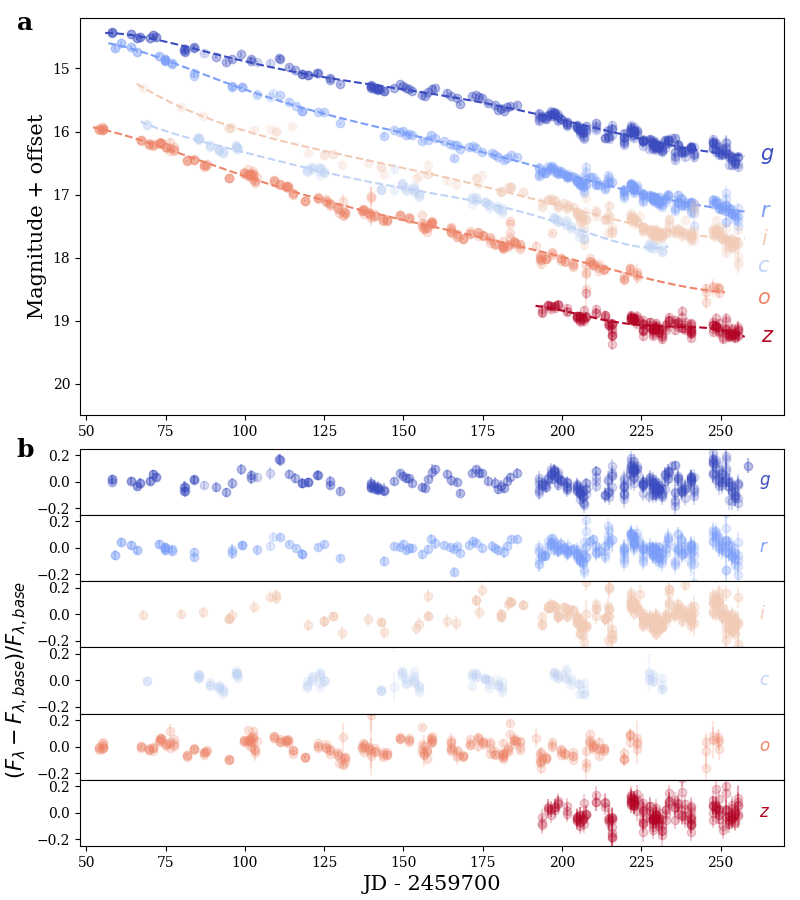

[16.131330259665518, 0.007581065641108063, 1.7518607995767404e-05, 8.552616266485728e-07, -4.64876188348236e-09, -6.67347659062638e-11, 3.575706526319623e-13]
[16.02463584529301, 0.01172887586435954, 4.030455389783236e-07, 7.726687629557629e-07, -5.542092546338324e-09, -6.174289482451153e-11, 4.171097998472618e-13]
[[9.49197801e+01 1.49460001e+01 2.78200004e-02]
 [9.49197801e+01 1.49459745e+01 2.78203599e-02]
 [9.49339931e+01 1.49429984e+01 3.47295329e-02]
 ...
 [2.57620558e+02 1.68580000e+01 8.70000000e-02]
 [2.72609671e+02 1.75860000e+01 1.08000000e-01]
 [2.83617828e+02 1.84750000e+01 1.64000000e-01]]
[15.577213755753876, 0.010932131780859649, 1.862059193887399e-05, 4.1920248412443735e-07, -5.9305685772888605e-09]
[16.09806010098434, 0.008958568202426263, -3.251852032458047e-05, 1.2503237217566343e-06, 1.8880884919813636e-08, -1.1796692861384592e-10, -2.2561511616321923e-12]
[15.902872926527145, 0.01146249693532015, -2.4248916054074405e-05, 6.510989153826987e-07, 6.668881787740837e-1

Text(-0.09, 0.45, 'b')

In [54]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'serif'

cmap = mpl.cm.coolwarm
Nflt  = 7
norm = mpl.colors.Normalize(vmin=0, vmax=Nflt)


Pfold = 12.4

fig = plt.figure(figsize=(8,9))
gs0 = GridSpec(25, 1, figure=fig, hspace=0.0, wspace=0, left=0.1, right=0.98, bottom=0.06, top=0.98)

ax = fig.add_subplot(gs0[0:12, 0])

ax2 = fig.add_subplot(gs0[13:15, 0])
ax3 = fig.add_subplot(gs0[15:17, 0], sharex=ax2, sharey=ax2)
ax4 = fig.add_subplot(gs0[17:19, 0], sharex=ax2, sharey=ax2)
ax5 = fig.add_subplot(gs0[19:21, 0], sharex=ax2, sharey=ax2)
ax6 = fig.add_subplot(gs0[21:23, 0], sharex=ax2, sharey=ax2)
ax7 = fig.add_subplot(gs0[23:25, 0])


#### g
xs = np.append(ztfg[:,0], RP_g[:,0]) 
ys = np.append(ztfg[:,1], RP_g[:,1]+RP_g_offset)
yerrs = np.append(ztfg[:,2], RP_g[:,2])

mask = xs<256
xs  = xs[mask]
xs = xs - 150
ys  = ys[mask]
yerrs  = yerrs[mask]
#print(xs)

xmin = np.min(xs)-2
xmax = np.max(xs)+2

polyorder = 6
polyfunc = poly6    
    
fitobj = polyfit(xs, ys, yerrs, polyorder)
xsmodel = np.linspace(xmin, xmax, 1000)
ys_fit = polyfunc(fitobj.params, xsmodel)
print(fitobj.params)


ax.errorbar(xs+150, ys+g_offset, yerr=yerrs, fmt='o', color=g_color, alpha=0.2)
ax.plot(xsmodel+150, ys_fit+g_offset, '--', color=g_color, label="g-band polynomial baseline")
ax.text(np.max(xsmodel+150)+5, np.max(ys_fit+g_offset), r'$g$', ha='left', va='center', fontsize=15, color=g_color)

#ax2.errorbar(xs+150, 10**((ys-polyfunc(fitobj.params, xs))/(-2.5))-1, yerr=yerrs, fmt='ro')

delta_g = np.array([xs+150, 10**((ys-polyfunc(fitobj.params, xs))/(-2.5))-1, yerrs]).transpose()

ax2.errorbar(ztfg[:,0], 10**((ztfg[:,1]-polyfunc(fitobj.params, ztfg[:,0]-150))/(-2.5))-1, yerr=ztfg[:,2], fmt='o', color=g_color, alpha=0.2)

mask = RP_g[:,0]<256
ax2.errorbar(RP_g[mask,0], 10**((RP_g[mask,1]+RP_g_offset-polyfunc(fitobj.params, RP_g[mask,0]-150))/(-2.5))-1, yerr=RP_g[mask,2], fmt='o', color=g_color, alpha=0.2)
#ax2.errorbar(xs+150, ys-polyfunc(fitobj.params, xs), yerr=yerrs, fmt='go')



########## r

xs = np.append(ztfr[:,0], RP_r[:,0])
ys = np.append(ztfr[:,1], RP_r[:,1]+RP_r_offset)
yerrs = np.append(ztfr[:,2], RP_r[:,2])

mask = xs<256
xs  = xs[mask]
xs = xs - 150
ys  = ys[mask]
yerrs  = yerrs[mask]
#print(xs)

xmin = np.min(xs)-2
xmax = np.max(xs)+2

polyorder = 6
polyfunc = poly6    
    
fitobj = polyfit(xs, ys, yerrs, polyorder)
xsmodel = np.linspace(xmin, xmax, 1000)
ys_fit = polyfunc(fitobj.params, xsmodel)
print(fitobj.params)

#r_offset = r_offset-1

ax.plot(xsmodel+150, ys_fit+r_offset, '--', color=r_color, label="r-band polynomial baseline")
ax.text(np.max(xsmodel+150)+5, np.max(ys_fit+r_offset), r'$r$', ha='left', va='center', fontsize=15, color=r_color)

delta_r = np.array([xs+150, 10**((ys-polyfunc(fitobj.params, xs))/(-2.5))-1, yerrs]).transpose()
#ax2.errorbar(xs+150, 10**((ys-polyfunc(fitobj.params, xs))/(-2.5))-1, yerr=yerrs, fmt='ro')

ax.errorbar(xs+150, ys+r_offset, yerr=yerrs, fmt='o', color=r_color, alpha=0.2)
mask = ztfr[:,0]<256
ax3.errorbar(ztfr[mask,0], 10**((ztfr[mask,1]-polyfunc(fitobj.params, ztfr[mask,0]-150))/(-2.5))-1 , yerr=ztfr[mask,2], fmt='o', color=r_color, alpha=0.2)
mask = RP_r[:,0]<256
ax3.errorbar(RP_r[mask,0], 10**((RP_r[mask,1]+RP_r_offset-polyfunc(fitobj.params, RP_r[mask,0]-150))/(-2.5))-1, yerr=RP_r[mask,2], fmt='o', color=r_color, alpha=0.2)



### i

RP_i_temp = RP_i.copy()
p60ip_temp = p60ip.copy()

RP_i_temp[:,1] = RP_i[:,1] + RP_i_offset
p60ip_temp[:,1] = p60ip[:,1] + P60_i_offset
lc_i = np.vstack([ztfi, RP_i_temp, p60ip_temp])


print(lc_i)

lc_i = lc_i[np.argsort(lc_i[:,0]),:]


xs = lc_i[:,0]
ys = lc_i[:,1]
yerrs = lc_i[:,2]



mask = (xs<256)*(xs>50)
xs  = xs[mask]
xs = xs - 150
ys  = ys[mask]
yerrs  = yerrs[mask]
#print(xs)

xmin = np.min(xs)-2
xmax = np.max(xs)+2

polyorder = 4
polyfunc = poly4
  
    
fitobj = polyfit(xs, ys, yerrs, polyorder)
xsmodel = np.linspace(xmin, xmax, 1000)
ys_fit = polyfunc(fitobj.params, xsmodel)
print(fitobj.params)

ax.plot(xsmodel+150, ys_fit+i_offset, '--', color=i_color, label="i-band polynomial baseline")
ax.text(np.max(xsmodel+150)+5, np.max(ys_fit+i_offset), r'$i$', ha='left', va='center', fontsize=15, color=i_color)

delta_i = np.array([xs+150, 10**((ys-polyfunc(fitobj.params, xs))/(-2.5))-1, yerrs]).transpose()


ax.errorbar(xs+150, ys+i_offset, yerr=yerrs, fmt='o', color=i_color, alpha=0.2)
ax4.errorbar(xs+150, 10**((ys-polyfunc(fitobj.params, xs))/(-2.5))-1 , yerr=yerrs, fmt='o', color=i_color, alpha=0.4)




#### atlas-c

xs = atlas_c[:,0]
ys = atlas_c[:,1]
yerrs = atlas_c[:,2]

mask = (xs<256)*(xs>50)
xs  = xs[mask]
xs = xs - 150
ys  = ys[mask]
yerrs  = yerrs[mask]
#print(xs)

xmin = np.min(xs)-2
xmax = np.max(xs)+2

polyorder = 6
polyfunc = poly6    
    
fitobj = polyfit(xs, ys, yerrs, polyorder)
xsmodel = np.linspace(xmin, xmax, 1000) 
ys_fit = polyfunc(fitobj.params, xsmodel)
print(fitobj.params)

ax.plot(xsmodel+150, ys_fit+c_offset, '--', color=c_color, label="c-band polynomial baseline")
ax.text(np.max(xsmodel+150)+5+20+3, np.max(ys_fit+c_offset)+0.3, r'$c$', ha='left', va='center', fontsize=15, color=c_color)

ax.errorbar(xs+150, ys+c_offset, yerr=yerrs, fmt='o', color=c_color, alpha=0.2)

ax5.errorbar(xs+150, 10**((ys-polyfunc(fitobj.params, xs))/(-2.5))-1 , yerr=yerrs, fmt='o', color=c_color, alpha=0.2)

delta_c = np.array([xs+150, 10**((ys-polyfunc(fitobj.params, xs))/(-2.5))-1, yerrs]).transpose()




#### o

xs = atlas_o[:,0]
ys = atlas_o[:,1]
yerrs = atlas_o[:,2]

mask = (xs<256)*(xs>50)
xs  = xs[mask]
xs = xs - 150
ys  = ys[mask]
yerrs  = yerrs[mask]
#print(xs)

xmin = np.min(xs)-2
xmax = np.max(xs)+2

polyorder = 5
if polyorder ==2:
    polyfunc = poly2
elif polyorder == 1:
    polyfunc = poly1
elif polyorder == 3:
    polyfunc = poly3
elif polyorder == 4:
    polyfunc = poly4
elif polyorder == 5:
    polyfunc = poly5    
elif polyorder == 6:
    polyfunc = poly6    
    
fitobj = polyfit(xs, ys, yerrs, polyorder)
xsmodel = np.linspace(xmin, xmax, 1000) 
ys_fit = polyfunc(fitobj.params, xsmodel)
print(fitobj.params)

#o_offset = o_offset-2

ax.plot(xsmodel+150, ys_fit+o_offset, '--', color=o_color, label="o-band polynomial baseline")
ax.text(np.max(xsmodel+150)+5+5, np.max(ys_fit+o_offset)+0.1, r'$o$', ha='left', va='center', fontsize=15, color=o_color)

ax.errorbar(xs+150, ys+o_offset, yerr=yerrs, fmt='o', color=o_color, alpha=0.2)

ax6.errorbar(xs+150, 10**((ys-polyfunc(fitobj.params, xs))/(-2.5))-1 , yerr=yerrs, fmt='o', color=o_color, alpha=0.2)

delta_o = np.array([xs+150, 10**((ys-polyfunc(fitobj.params, xs))/(-2.5))-1, yerrs]).transpose()



##### z

xs = RP_z[:,0]
ys = RP_z[:,1]
yerrs = RP_z[:,2]

mask = (xs<256)*(xs>50)
xs  = xs[mask]
xs = xs - 150
ys  = ys[mask]
yerrs  = yerrs[mask]
#print(xs)

xmin = np.min(xs)-2
xmax = np.max(xs)+2

polyorder = 4
if polyorder ==2:
    polyfunc = poly2
elif polyorder == 1:
    polyfunc = poly1
elif polyorder == 3:
    polyfunc = poly3
elif polyorder == 4:
    polyfunc = poly4
elif polyorder == 5:
    polyfunc = poly5    
elif polyorder == 6:
    polyfunc = poly6    
    
fitobj = polyfit(xs, ys, yerrs, polyorder)
xsmodel = np.linspace(xmin, xmax, 1000)
ys_fit = polyfunc(fitobj.params, xsmodel)
print(fitobj.params)

ax.plot(xsmodel+150, ys_fit+z_offset, '--', color=z_color, label="i-band polynomial baseline")
ax.text(np.max(xsmodel+150)+5, np.max(ys_fit+z_offset), r'$z$', ha='left', va='center', fontsize=15, color=z_color)

ax.errorbar(xs+150, ys+z_offset, yerr=yerrs, fmt='o', color=z_color, alpha=0.2)


delta_z = np.array([xs+150, 10**((ys-polyfunc(fitobj.params, xs))/(-2.5))-1, yerrs]).transpose()

ax7.errorbar(xs+150, 10**((ys-polyfunc(fitobj.params, xs))/(-2.5))-1 , yerr=yerrs, fmt='o', color=z_color, alpha=0.2)




ax2.text(262, 0, r'$g$', fontsize=12, va='center', color=g_color)
ax3.text(262, 0, r'$r$', fontsize=12, va='center', color=r_color)
ax4.text(262, 0, r'$i$', fontsize=12, va='center', color=i_color)
ax5.text(262, 0, r'$c$', fontsize=12, va='center', color=c_color)
ax6.text(262, 0, r'$o$', fontsize=12, va='center', color=o_color)
ax7.text(262, 0, r'$z$', fontsize=12, va='center', color=z_color)

ax.set_ylim([14.2,20.5])
ax.set_xlim([48,270])
ax2.set_xlim([48, 270])
ax7.set_xlim([48, 270])
ax2.set_ylim([-0.25, 0.25])
ax7.set_ylim([-0.25, 0.25])

ax2.yaxis.set_major_locator(MultipleLocator(0.2))
ax7.yaxis.set_major_locator(MultipleLocator(0.2))

ax2.set_xticklabels([])


ax.invert_yaxis()

ax.set_ylabel('Magnitude + offset', fontsize=15)
#ax5.set_ylabel(r'$\Delta$ F$_\lambda$/F$_\lambda$', fontsize=15)
ax5.set_ylabel(r'$(F_\lambda-F_{\lambda, base})/F_{\lambda, base}$', fontsize=15)

ax7.set_xlabel('JD - 2459700', fontsize=15)


ax.set_title('a', fontsize=18, loc='left', pad=20, x=-0.09, y=0.9, fontweight='bold')
ax2.set_title('b', fontsize=18, loc='left', pad=20, x=-0.09, y=0.45, fontweight='bold')

#plt.tight_layout()


## periodogram

### individual band periodicity 

with all bands in one plot

<IPython.core.display.Javascript object>


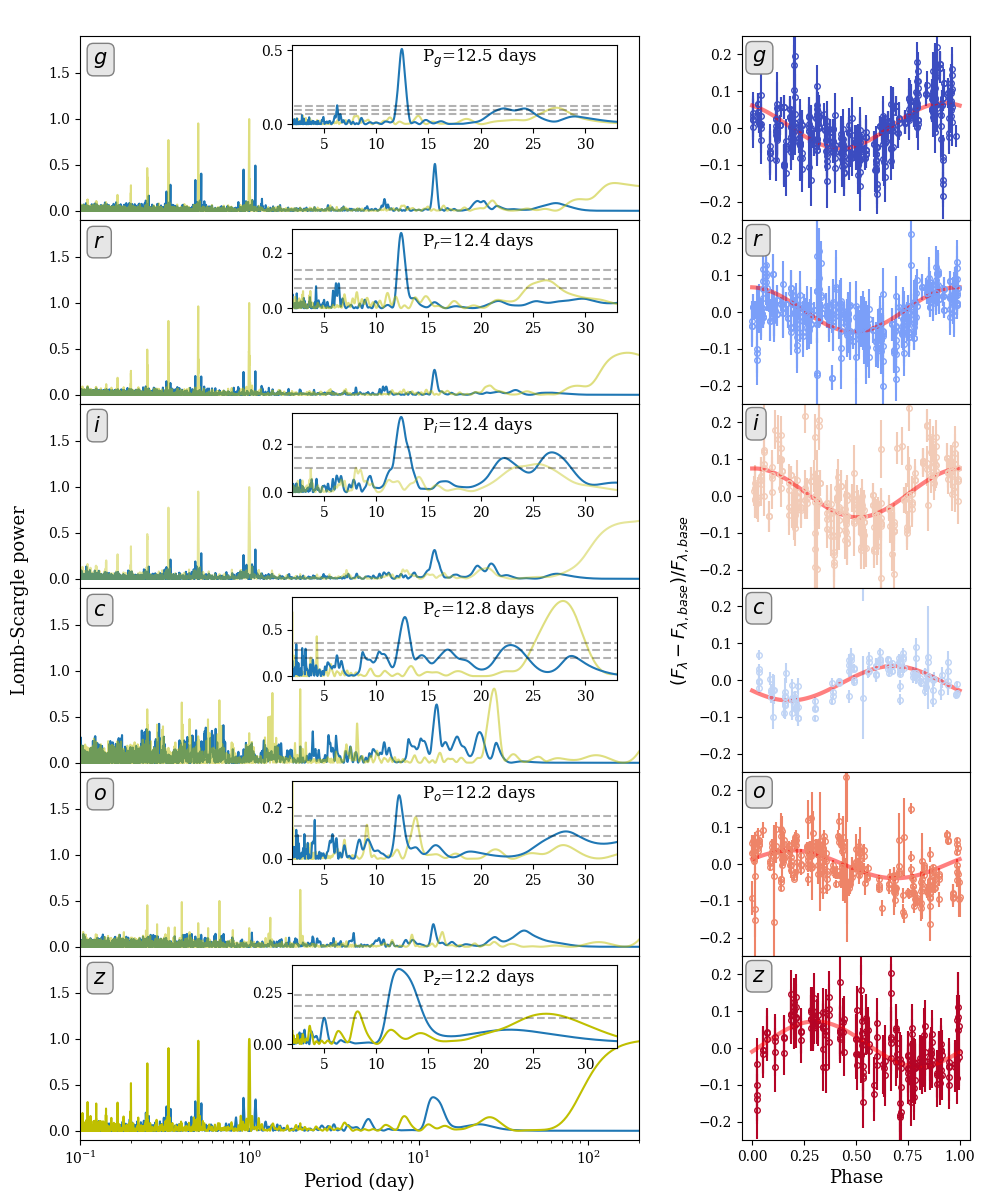

g band
[0.06730862 0.09695673 0.12544661]
g band period: 12.45364927242529
g model parameters:
[ 0.00442342 -0.02773912  0.05483407]
r band
[0.07358738 0.10609811 0.13722987]
r band period: 12.388102828071297
r model parameters:
[-0.00320357  0.00503544  0.03453815]
i band
[0.09934685 0.14416132 0.18640576]
i band period: 12.395381235392053
i model parameters:
[0.00475922 0.00393168 0.06627949]
c band
[0.19436853 0.27883456 0.35382143]
c band period: 12.750583358343796
c model parameters:
[-0.00989316 -0.04248514 -0.01998592]
o band
[0.08718983 0.12666169 0.16412665]
o band period: 12.200429521430172
o model parameters:
[-0.00216071  0.03521648  0.01398225]
z band
[0.12884819 0.18573748 0.23848887]
z band period: 12.174797734495332
z model parameters:
[ 0.00769856  0.05808009 -0.02042786]


In [57]:


fig = plt.figure(figsize=(10,12))
gs0 = GridSpec(6, 3, figure=fig, hspace=0.0, wspace=0.45, left=0.08, right=0.97, bottom=0.05, top=0.97)


### -------- g
print('g band')

gt = delta_g[:,0]
gfp = delta_g[:,1]
gfperr= delta_g[:,2]

glc_ls = LombScargle(gt, gfp, gfperr, nterms=1)
g_frequency, g_power = glc_ls.autopower(minimum_frequency=0.005, maximum_frequency=10, samples_per_peak=100, method='auto')
g_win = LombScargle(gt, np.ones_like(gfp), center_data=False, fit_mean=False)
g_frequency2, g_w_power = g_win.autopower(minimum_frequency=0.005, maximum_frequency=10, samples_per_peak=100)


probabilities = [1e-3, 1e-6, 1e-9]
g_power_levels = glc_ls.false_alarm_level(probabilities)

print(g_power_levels)

g_best_frequency = g_frequency[np.argmax(g_power)]
g_period = 1.0/g_best_frequency
print('g band period:', g_period)


ax = fig.add_subplot(gs0[0, 0:2])
ax.plot(1/g_frequency, g_power, '-')
ax.plot(1/g_frequency2, g_w_power, 'y-', alpha=0.5)

ax.set_xlim([0.1, 2e2])
ax.set_ylim([1e-2, 2e3])
ax.set_ylim([-1e-1, 1.9])
ax.text(0.12, 1.6, r'$g$', fontsize=15, color='k', bbox=dict(boxstyle="round", ec=(0.5, 0.5, 0.5), fc=(0.9, 0.9, 0.9),))
ax.set_xscale('log')
ax.set_xticks([])


axins = ax.inset_axes([0.38,0.5, 0.58,0.45])
mask = (g_frequency<0.5)*(g_frequency>0.03)
axins.plot(1/g_frequency2[mask], g_w_power[mask], 'y-', alpha=0.5)
axins.plot(1/g_frequency[mask], g_power[mask], '-')
axins.hlines(g_power_levels, xmin=0, xmax=50, linestyles='dashed', colors='k', alpha=0.3)
axins.set_xlim([2, 33])
axins.text(0.4, 0.8, r'P$_g$=%s days'%str(np.round(g_period, 1)), color='k', fontsize=12, transform=axins.transAxes)

ax2 = fig.add_subplot(gs0[0, 2])
ax2.errorbar(np.mod(gt, g_period)/g_period, gfp, yerr=gfperr, fmt='o', color=g_color, ms=4, mfc='none')
ax2.set_ylim([-0.25, 0.25])
ax2.text(0, 0.18, r'$g$', fontsize=15, color='k', bbox=dict(boxstyle="round", ec=(0.5, 0.5, 0.5), fc=(0.9, 0.9, 0.9),))
ax2.set_xticks([])

print('g model parameters:')
print(glc_ls.model_parameters(g_best_frequency))
t_fit = np.linspace(0, g_period, 100)
y_fit = glc_ls.model(t_fit, g_best_frequency)
ax2.plot(t_fit/g_period, y_fit, 'r', alpha=0.5, lw=3)



###--------------------- r
print('r band')
rt = delta_r[:,0]
rfp = delta_r[:,1]
rfperr= delta_r[:,2]

rlc_ls = LombScargle(rt, rfp, rfperr, nterms=1)
r_frequency, r_power = rlc_ls.autopower(minimum_frequency=0.005, maximum_frequency=10, samples_per_peak=100, method='auto')
r_win = LombScargle(rt, np.ones_like(rfp), center_data=False, fit_mean=False)
r_frequency2, r_w_power = r_win.autopower(minimum_frequency=0.005, maximum_frequency=10, samples_per_peak=100)


probabilities = [1e-3, 1e-6, 1e-9]
r_power_levels = rlc_ls.false_alarm_level(probabilities)
print(r_power_levels)

r_best_frequency = r_frequency[np.argmax(r_power)]
r_period = 1.0/r_best_frequency
print('r band period:', r_period)


ax = fig.add_subplot(gs0[1, 0:2])
ax.plot(1/r_frequency, r_power, '-')
ax.plot(1/r_frequency2, r_w_power, 'y-', alpha=0.5)

ax.set_xlim([0.1, 2e2])
ax.set_ylim([-1e-1, 1.9])
ax.text(0.12, 1.6, r'$r$', fontsize=15, color='k', bbox=dict(boxstyle="round", ec=(0.5, 0.5, 0.5), fc=(0.9, 0.9, 0.9),))

ax.set_xscale('log')
ax.set_xticks([])

axins = ax.inset_axes([0.38,0.5, 0.58,0.45])
mask = (r_frequency<0.5)*(r_frequency>0.03)
axins.plot(1/r_frequency[mask], r_power[mask], '-')
axins.plot(1/r_frequency2[mask], r_w_power[mask], 'y-', alpha=0.5)
axins.hlines(r_power_levels, xmin=0, xmax=50, linestyles='dashed', colors='k', alpha=0.3)
axins.set_xlim([2, 33])
axins.text(0.4, 0.8, r'P$_r$=%s days'%str(np.round(r_period, 1)), color='k', fontsize=12, transform=axins.transAxes)


ax2 = fig.add_subplot(gs0[1, 2])
ax2.errorbar(np.mod(rt, r_period)/r_period, rfp, yerr=rfperr, fmt='o', color=r_color, ms=4, mfc='none')
ax2.set_ylim([-0.25, 0.25])
ax2.text(0, 0.18, r'$r$', fontsize=15, color='k', bbox=dict(boxstyle="round", ec=(0.5, 0.5, 0.5), fc=(0.9, 0.9, 0.9),))
ax2.set_xticks([])

print('r model parameters:')
print(rlc_ls.model_parameters(r_best_frequency))
t_fit = np.linspace(0, r_period, 100)
y_fit = glc_ls.model(t_fit, r_best_frequency)
ax2.plot(t_fit/r_period, y_fit, 'r', alpha=0.5, lw=3)


#### ------------------ i 
print('i band')
it = delta_i[:,0]
ifp = delta_i[:,1]
ifperr= delta_i[:,2]

ilc_ls = LombScargle(it, ifp, ifperr, nterms=1)
i_frequency, i_power = ilc_ls.autopower(minimum_frequency=0.005, maximum_frequency=10, samples_per_peak=100, method='auto')
i_win = LombScargle(it, np.ones_like(ifp), center_data=False, fit_mean=False)
i_frequency2, i_w_power = i_win.autopower(minimum_frequency=0.005, maximum_frequency=10, samples_per_peak=100)

probabilities = [1e-3, 1e-6, 1e-9]
i_power_levels = ilc_ls.false_alarm_level(probabilities)
print(i_power_levels)

mask = (i_frequency<0.5)*(i_frequency>0.02)

i_best_frequency = i_frequency[mask][np.argmax(i_power[mask])]
i_period = 1.0/i_best_frequency
print('i band period:', i_period)

ax = fig.add_subplot(gs0[2, 0:2])
ax.plot(1/i_frequency, i_power, '-')
ax.plot(1/i_frequency2, i_w_power, 'y-', alpha=0.4)

ax.set_xlim([0.1, 2e2])
ax.set_ylim([-1e-1, 1.9])
ax.text(0.12, 1.6, r'$i$', fontsize=15, color='k', bbox=dict(boxstyle="round", ec=(0.5, 0.5, 0.5), fc=(0.9, 0.9, 0.9),))

ax.set_xscale('log')
ax.set_xticks([])

axins = ax.inset_axes([0.38,0.5, 0.58,0.45])
mask = (i_frequency<0.5)*(i_frequency>0.03)
axins.plot(1/i_frequency[mask], i_power[mask], '-')
axins.plot(1/i_frequency2[mask], i_w_power[mask], 'y-', alpha=0.4)
axins.hlines(i_power_levels, xmin=0, xmax=50, linestyles='dashed', colors='k', alpha=0.3)
axins.set_xlim([2, 33])
axins.text(0.4, 0.8, r'P$_i$=%s days'%str(np.round(i_period, 1)), color='k', fontsize=12, transform=axins.transAxes)


ax2 = fig.add_subplot(gs0[2, 2])
ax2.errorbar(np.mod(it, i_period)/i_period, ifp, yerr=ifperr, fmt='o', color=i_color, ms=4, mfc='none')
ax2.set_ylim([-0.25, 0.25])
ax2.text(0, 0.18, r'$i$', fontsize=15, color='k', bbox=dict(boxstyle="round", ec=(0.5, 0.5, 0.5), fc=(0.9, 0.9, 0.9),))
ax2.set_xticks([])


print('i model parameters:')
print(ilc_ls.model_parameters(i_best_frequency))
t_fit = np.linspace(0, i_period, 100)
y_fit = ilc_ls.model(t_fit, i_best_frequency)
ax2.plot(t_fit/i_period, y_fit, 'r', alpha=0.5, lw=3)


####### --------------- c
print('c band')
ct = delta_c[:,0]
cfp = delta_c[:,1]
cfperr= delta_c[:,2]


clc_ls = LombScargle(ct, cfp, cfperr, nterms=1)
c_frequency, c_power = clc_ls.autopower(minimum_frequency=0.005, maximum_frequency=10, samples_per_peak=100, method='auto')
c_win = LombScargle(ct, np.ones_like(cfp), center_data=False, fit_mean=False)
c_frequency2, c_w_power = c_win.autopower(minimum_frequency=0.005, maximum_frequency=10, samples_per_peak=100, method='scipy')


probabilities = [1e-3, 1e-6, 1e-9]
c_power_levels = clc_ls.false_alarm_level(probabilities)
print(c_power_levels)

c_best_frequency = c_frequency[np.argmax(c_power)]
c_period = 1.0/c_best_frequency
print('c band period:', c_period)

ax = fig.add_subplot(gs0[3, 0:2])
ax.plot(1/c_frequency, c_power, '-')
ax.plot(1/c_frequency2, c_w_power, 'y-', alpha=0.5)


ax.set_xlim([0.1, 2e2])
ax.set_ylim([-1e-1, 1.9])
ax.text(0.12, 1.6, r'$c$', fontsize=15, color='k', bbox=dict(boxstyle="round", ec=(0.5, 0.5, 0.5), fc=(0.9, 0.9, 0.9),))
ax.set_xscale('log')
ax.set_xticks([])

axins = ax.inset_axes([0.38,0.5, 0.58,0.45])
mask = (c_frequency<0.5)*(c_frequency>0.03)
axins.plot(1/c_frequency2[mask], c_w_power[mask], 'y-', alpha=0.5)
axins.plot(1/c_frequency[mask], c_power[mask], '-')
axins.hlines(c_power_levels, xmin=0, xmax=50, linestyles='dashed', colors='k', alpha=0.3)
axins.set_xlim([2, 33])
axins.text(0.4, 0.8, r'P$_c$=%s days'%str(np.round(c_period, 1)), color='k', fontsize=12, transform=axins.transAxes)


ax2 = fig.add_subplot(gs0[3, 2])
ax2.errorbar(np.mod(ct, c_period)/c_period, cfp, yerr=cfperr, fmt='o', color=c_color, ms=4, mfc='none')
ax2.set_ylim([-0.25, 0.25])
ax2.text(0, 0.18, r'$c$', fontsize=15, color='k', bbox=dict(boxstyle="round", ec=(0.5, 0.5, 0.5), fc=(0.9, 0.9, 0.9),))
ax2.set_xticks([])


print('c model parameters:')
print(clc_ls.model_parameters(c_best_frequency))
t_fit = np.linspace(0, c_period, 100)
y_fit = clc_ls.model(t_fit, c_best_frequency)
ax2.plot(t_fit/c_period, y_fit, 'r', alpha=0.5, lw=3)


####### ---------- o
print('o band')
ot = delta_o[:,0]
ofp = delta_o[:,1]
ofperr= delta_o[:,2]


olc_ls = LombScargle(ot, ofp, ofperr, nterms=1)
o_frequency, o_power = olc_ls.autopower(minimum_frequency=0.005, maximum_frequency=10, samples_per_peak=100, method='auto')
o_win = LombScargle(ot, np.ones_like(ofp), center_data=False, fit_mean=False)
o_frequency2, o_w_power = o_win.autopower(minimum_frequency=0.005, maximum_frequency=10, samples_per_peak=100)


probabilities = [1e-3, 1e-6, 1e-9]
o_power_levels = olc_ls.false_alarm_level(probabilities)
print(o_power_levels)

o_best_frequency = o_frequency[np.argmax(o_power)]
o_period = 1.0/o_best_frequency
print('o band period:', o_period)

ax = fig.add_subplot(gs0[4, 0:2])
ax.plot(1/o_frequency, o_power, '-')
ax.plot(1/o_frequency2, o_w_power, 'y-', alpha=0.5)

ax.set_xlim([0.1, 2e2])
ax.set_ylim([-1e-1, 1.9])
ax.text(0.12, 1.6, r'$o$', fontsize=15, color='k', bbox=dict(boxstyle="round", ec=(0.5, 0.5, 0.5), fc=(0.9, 0.9, 0.9),))
ax.set_xscale('log')
ax.set_xticks([])

axins = ax.inset_axes([0.38,0.5, 0.58,0.45])
mask = (o_frequency<0.5)*(o_frequency>0.03)
axins.plot(1/o_frequency2[mask], o_w_power[mask], 'y-', alpha=0.5)
axins.plot(1/o_frequency[mask], o_power[mask], '-')
axins.set_ylim([-0.02, 0.3])
axins.hlines(o_power_levels, xmin=0, xmax=50, linestyles='dashed', colors='k', alpha=0.3)
axins.set_xlim([2, 33])
axins.text(0.4, 0.8, r'P$_o$=%s days'%str(np.round(o_period, 1)), color='k', fontsize=12, transform=axins.transAxes)


ax2 = fig.add_subplot(gs0[4, 2])
ax2.errorbar(np.mod(ot, o_period)/o_period, ofp, yerr=ofperr, fmt='o', color=o_color, ms=4, mfc='none')
ax2.set_ylim([-0.25, 0.25])
ax2.text(0, 0.18, r'$o$', fontsize=15, color='k', bbox=dict(boxstyle="round", ec=(0.5, 0.5, 0.5), fc=(0.9, 0.9, 0.9),))
ax2.set_xticks([])

print('o model parameters:')
print(olc_ls.model_parameters(o_best_frequency))
t_fit = np.linspace(0, o_period, 100)
y_fit = olc_ls.model(t_fit, o_best_frequency)
ax2.plot(t_fit/o_period, y_fit, 'r', alpha=0.5, lw=3)



#############------------ z
print('z band')

zt = delta_z[:,0]
zfp = delta_z[:,1]
zfperr= delta_z[:,2]

zlc_ls = LombScargle(zt, zfp, zfperr)
z_frequency, z_power = zlc_ls.autopower(minimum_frequency=0.005, maximum_frequency=10, samples_per_peak=100)
z_win = LombScargle(zt, np.ones_like(zfp), center_data=False, fit_mean=False)
z_frequency2, z_w_power = z_win.autopower(minimum_frequency=0.005, maximum_frequency=10, samples_per_peak=100)

probabilities = [1e-3, 1e-6, 1e-9]
z_power_levels = zlc_ls.false_alarm_level(probabilities) 
print(z_power_levels)

z_best_frequency = z_frequency[np.argmax(z_power)]
z_period = 1.0/z_best_frequency
print('z band period:', z_period)


ax = fig.add_subplot(gs0[5, 0:2])
ax.plot(1/z_frequency, z_power, '-')
ax.plot(1/z_frequency2, z_w_power, 'y-')

ax.set_xlim([0.1, 2e2])
ax.set_ylim([-1e-1, 1.9])
ax.set_xticks([])
ax.text(0.12, 1.6, r'$z$', fontsize=15, color='k', bbox=dict(boxstyle="round", ec=(0.5, 0.5, 0.5), fc=(0.9, 0.9, 0.9),))

ax.set_xscale('log')
#ax.set_yscale('log')

axins = ax.inset_axes([0.38,0.5, 0.58,0.45])
mask = (z_frequency<0.5)*(z_frequency>0.03)
axins.plot(1/z_frequency[mask], z_power[mask], '-')
axins.plot(1/z_frequency2[mask], z_w_power[mask], 'y-')
axins.hlines(z_power_levels, xmin=0, xmax=50, linestyles='dashed', colors='k', alpha=0.3)
axins.set_xlim([2, 33])
axins.text(0.4, 0.8, r'P$_z$=%s days'%str(np.round(z_period, 1)), color='k', fontsize=12, transform=axins.transAxes)


ax2 = fig.add_subplot(gs0[5, 2])
ax2.errorbar(np.mod(zt, z_period)/z_period, zfp, yerr=zfperr, fmt='o', color=z_color, ms=4, mfc='none')
ax2.set_ylim([-0.25, 0.25])
ax2.text(0, 0.18, r'$z$', fontsize=15, color='k', bbox=dict(boxstyle="round", ec=(0.5, 0.5, 0.5), fc=(0.9, 0.9, 0.9),))

print('z model parameters:')
print(zlc_ls.model_parameters(z_best_frequency))
t_fit = np.linspace(0, z_period, 100)
y_fit = zlc_ls.model(t_fit, z_best_frequency)
ax2.plot(t_fit/z_period, y_fit, 'r', alpha=0.5, lw=3)



fig.text(0.02, 0.5, 'Lomb-Scargle power', fontsize=13, va='center', ha='center', rotation='vertical')
#fig.text(0.68, 0.5, r'$\Delta$ F$_\lambda$/F$_\lambda$', fontsize=13, va='center', ha='center', rotation='vertical')
fig.text(0.68, 0.5, r'$(F_\lambda-F_{\lambda, base})/F_{\lambda, base}$', fontsize=13, va='center', ha='center', rotation='vertical')
ax.set_xlabel('Period (day)', fontsize=13)
ax2.set_xlabel('Phase', fontsize=13)

plt.savefig('../plots/sn2022jli_periodogram_individual_band.pdf')

### multi-band periodicty

In [58]:
#prepare input data

delta_mag = np.vstack([delta_g,  delta_r, delta_i, delta_c, delta_o, delta_z])

Ng = len(delta_g)
Nr = len(delta_r)
Ni = len(delta_i)
Nc = len(delta_c)
No = len(delta_o)
Nz = len(delta_z)
flts  = np.hstack([np.array(['g']*Ng), np.array(['r']*Nr), np.array(['i']*Ni), np.array(['c']*Nc), np.array(['o']*No), np.array(['z']*Nz)])

#print(delta_mag)
#print(flts)

#### Nterm_base =1, Nterm_band = 0


<IPython.core.display.Javascript object>


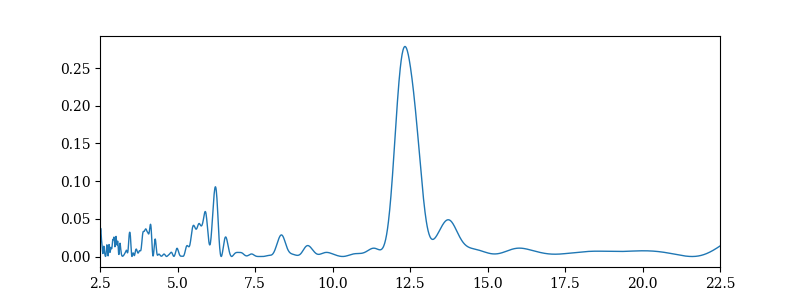

<IPython.core.display.Javascript object>


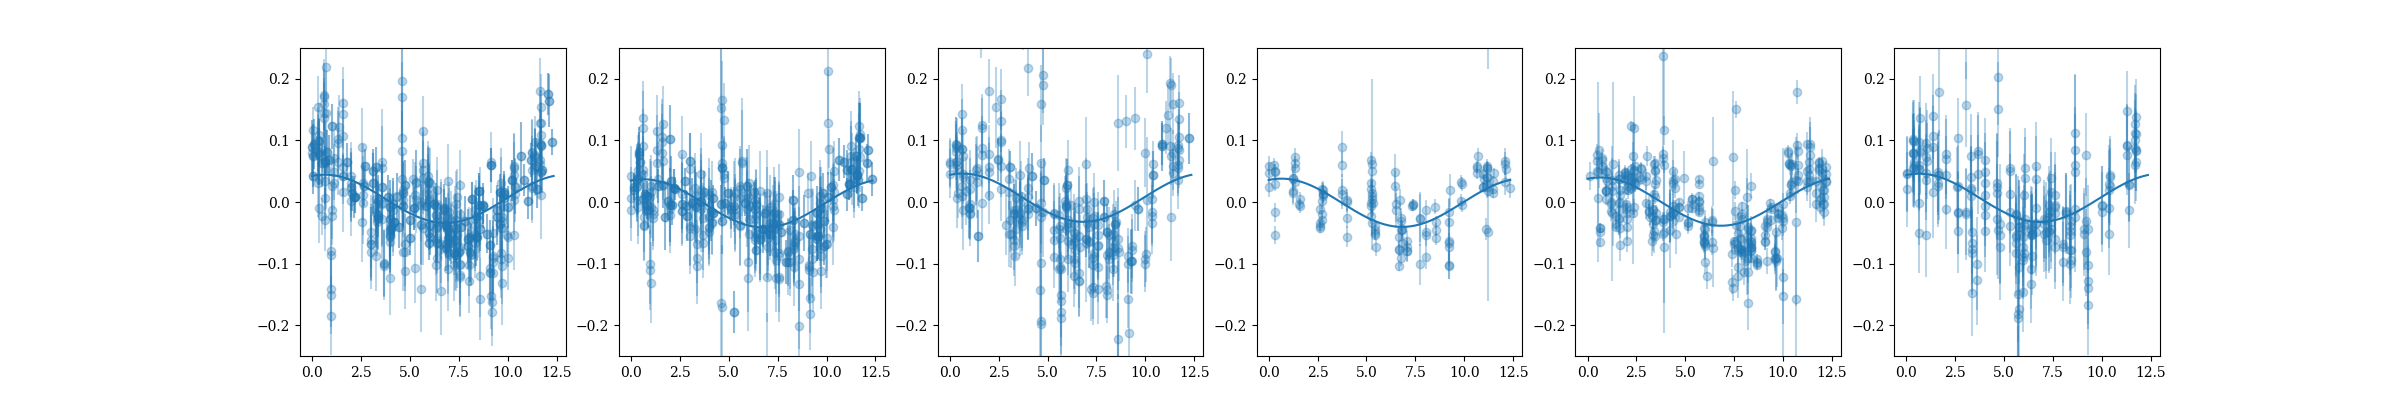

In [105]:

model = LombScargleMultiband(Nterms_base=1, Nterms_band=0)
model.fit(delta_mag[:,0], delta_mag[:,1], delta_mag[:,2], flts)

period_prior = 12.5
periods = np.linspace(period_prior - 10, period_prior + 10, 2000)
power = model.periodogram(periods)
fig, ax = plt.subplots(figsize=(8,3))
ax.plot(periods, power, lw=1)
ax.set_xlim(periods[0], periods[-1]);



delta_flts = {'g':delta_g, 'r': delta_r, 'i': delta_i, 'c': delta_c, 'o': delta_o, 'z': delta_z}

period = 12.35
fig, axes = plt.subplots(1,6, figsize=(24,4)) #(axg, axr, axi, axc, axo, axz)
tfit = np.linspace(0, period, 1000)

for i, flt in enumerate(['g', 'r', 'i', 'c', 'o', 'z']):
    ax = axes[i]
    delta_fltdata = delta_flts[flt]
    eb = ax.errorbar(delta_fltdata[:,0]%period, delta_fltdata[:,1], yerr=delta_fltdata[:,2], fmt='o', alpha=0.3, label=flt)
    yfit = model.predict(tfit, flt, period=period)
    ax.plot(tfit, yfit, color=eb[0].get_color())
    ax.set_ylim([-0.25, 0.25])

#### Nterms_base =4, Nterms_band = 2

In [59]:

delta_mag = np.vstack([delta_g,  delta_r, delta_i, delta_c, delta_o, delta_z]) #

#np.savetxt('./periodicty/periodogram_input.txt', delta_mag)

tshift = -8 - 12.4*3
delta_mag[:,0] = delta_mag[:,0] + tshift

Ng = len(delta_g)
Nr = len(delta_r)
Ni = len(delta_i)
Nc = len(delta_c)
No = len(delta_o)
Nz = len(delta_z)
print(Ng, Nr, Ni, Nc, No, Nz)
flts  = np.hstack([np.array(['g']*Ng), np.array(['r']*Nr), np.array(['i']*Ni), np.array(['c']*Nc), np.array(['o']*No), np.array(['z']*Nz)])

#select part of the data
tcut = 310
flts = flts[delta_mag[:,0]<tcut]
delta_mag = delta_mag[delta_mag[:,0]<tcut,:]

model = LombScargleMultiband(optimizer=None, Nterms_base=4, Nterms_band=2, reg_base=0.05, reg_band=1e-4)  #optimizer not specified, the LinearScanOptimizer will be used
model.fit(delta_mag[:,0], delta_mag[:,1], delta_mag[:,2], flts)


443 401 282 132 325 214


In [114]:
model.optimizer.period_range = (10, 15)
out = model.find_best_periods(n_periods=3)
print(out)

Finding optimal frequency:
 - Estimated peak width = 0.0312
 - Using 5 steps per peak; omega_step = 0.00624
 - User-specified period range:  10 to 15
 - Computing periods at 35 steps
Zooming-in on 6 candidate peaks:
 - Computing periods at 1200 steps
[12.37338748 11.83008141 13.22951776]


In [111]:
##get the reference JD of the bump peak

rise_fraction = 0.24
rise_time = period*rise_fraction
print('rise time:', rise_time)

#get the refence JD of the bump peak
bump_peak_refjd = tmaxg_22jli+150-tshift+period*2+period*0.24
print('refence JD of the bump peak:', bump_peak_refjd)

rise time: 2.976
refence JD of the bump peak: 2459922.976


### generate an emperical bump model


In [63]:
from PyAstronomy import funcFit as fuf
import emcee


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [64]:
def corner_plot(mcmcdbfile, parslist=None):
    '''
        create the corner plot
        '''
    import os
    import corner

    if not os.path.exists(mcmcdbfile):
        raise ValueError("MCMC process database file %s not available" % self.param['mcmcdbfile'])
    ta = fuf.TraceAnalysis(mcmcdbfile)
    #burnnum = int(self.param['mcmcburnnum'])
    thin = 1
    ta.setBurn(0)
    ta.setThin(thin)
    if parslist is None:
        parslist = ta.availableParameters()
    data = np.array([ta[par] for par in parslist]).transpose()
    figure = corner.corner(data, bins=20, show_titles=False, quantiles=[0.16, 0.5, 0.84], levels=[0.393, 0.865, 0.989], labels=parslist)  # the adoption of levels is not well understood...to check
    figure.show()

In [277]:
np.savetxt('./undulation_profile/delta_g.txt', delta_g)

In [65]:
def construct_emperical_bump_model(x, P, rise, height, xshift, yshift, win_sigma, tbin=0.1):
    #decline = P - rise
    #height = 1
    
    Ncycle = 3
    tbin = 0.1
    Npoint = int(P/tbin)*Ncycle
    ts = np.linspace(0, Ncycle*P,  Npoint)   
    sig = np.zeros_like(ts)
    sig0 = np.append(ts[ts<rise]*height/rise, -height/(P-rise)*(ts[(ts>rise)*(ts<P)]-P))
    for i in range(Ncycle):
        sig[(ts>=i*P)*(ts<=(i+1)*P)] = sig0

    
    win = signal.windows.gaussian(int(P/tbin), np.absolute(win_sigma)/tbin)
    filtered = signal.convolve(sig, win, mode='same') / sum(win)
    
    filteredtemp = filtered[(ts>(P-3))*(ts< (P+3) )]
    tstemp = ts[(ts>(P-3))*(ts< (P+3) )]
    t1 = tstemp[filteredtemp == np.min(filteredtemp)]
    filteredtemp = filtered[(ts>(2*P-3))*(ts< (2*P+3) )]
    tstemp = ts[(ts>(2*P-3))*(ts< (2*P+3) )]
    t2 = tstemp[filteredtemp == np.min(filteredtemp)]
    
    sigfiltered = filtered[(ts>= (t1+xshift) )*(ts< (t2+xshift) )]
        
    
    model = interp1d( np.linspace(0, P, len(sigfiltered)), sigfiltered + yshift, kind='linear' )
    result = model(x)
    
    return result



def calculate_chi2(p, data):
    x, y, yerr = data
    P  = 12.37
    rise, height, xshift, yshift, sigma = p
    model = construct_emperical_bump_model(x, P, rise, height, xshift, yshift, sigma)
    chi2 = np.sum( (y-model)**2/yerr**2 )
    return chi2



class OneDFit2(fuf.OneDFit):
    def __init__(self, parlist):
        fuf.OneDFit.__init__(self, parlist)

    def evaluate(self, x):

        P = 12.37
        rise = self['rise']
        height = self['height']
        yshift = self['yshift']
        xshift = self['xshift']
        #tau = self['tau']    
        y = construct_emperical_bump_model(x, P, rise, height, xshift, yshift, win_sigma=0.2, tbin=0.1)
            
        return y
    

####  g band 

Lowest deviance set:  {'rise': 3.233574475169335, 'height': 0.14593098496009152, 'xshift': 4.336663125291842, 'yshift': -0.06551993918918837}
  at chain index:  221864
Set of mean values:  {'rise': 3.1857012613814475, 'height': 0.14564124661289027, 'xshift': 4.311176995846026, 'yshift': -0.06558017933486698}
Set of median values:  {'rise': 3.1857012613814475, 'height': 0.14564124661289027, 'xshift': 4.311176995846026, 'yshift': -0.06558017933486698}
rise uncertainty: (2.9924988468729268, 3.3046259312754707) 0.16026854048972974
---------------------------------
Parameters for Component: unnamed
---------------------------------
Parameter:   rise  , [  rise], value:      3.23357, free: False, restricted: False, related: False
Parameter: height  , [height], value:     0.145931, free: False, restricted: False, related: False
Parameter: xshift  , [xshift], value:      4.33666, free: False, restricted: False, related: False
Parameter: yshift  , [yshift], value:   -0.0655199, free: False, res

<IPython.core.display.Javascript object>


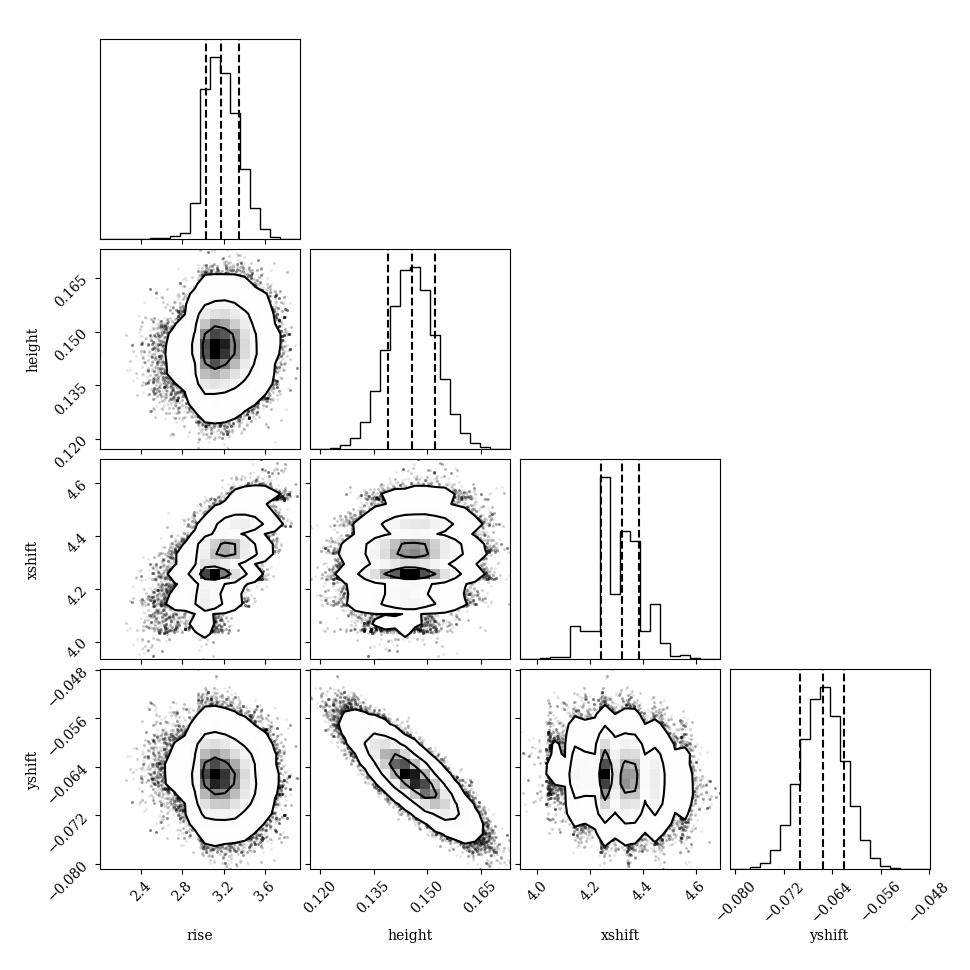

<IPython.core.display.Javascript object>


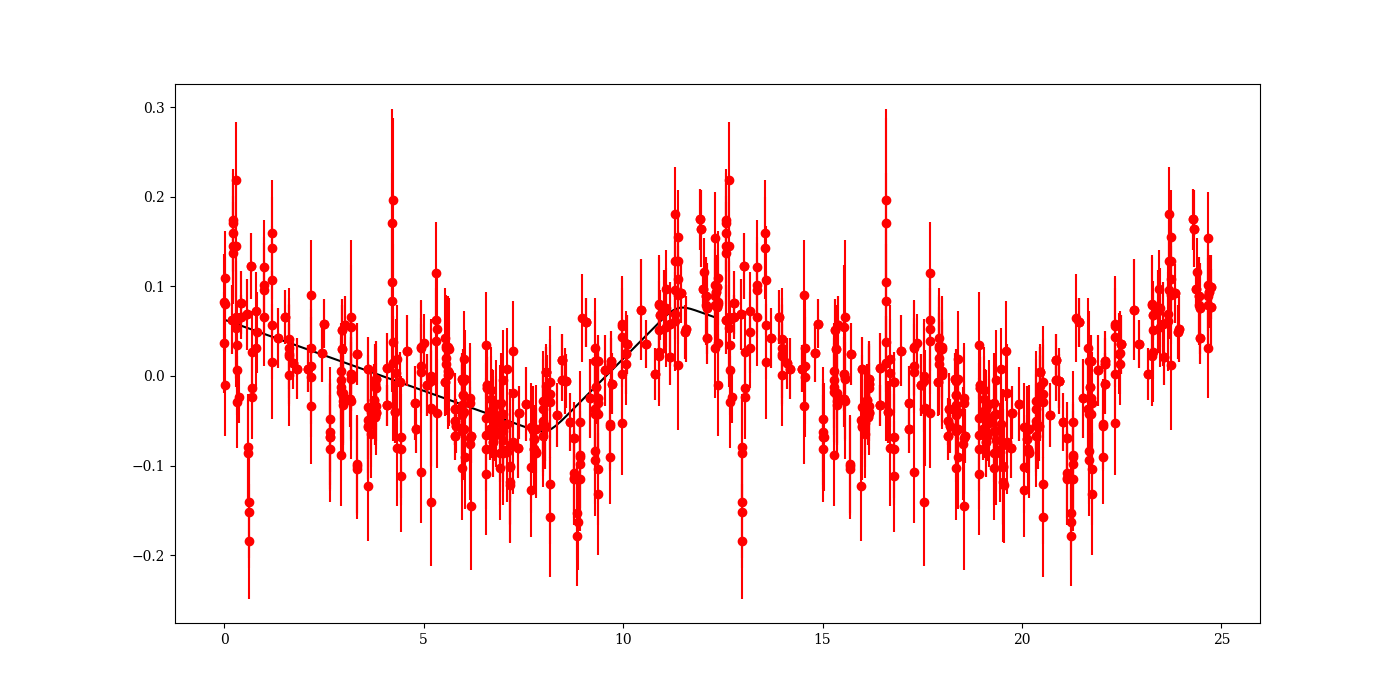

chi2 best fit: 504.6462392427109


<IPython.core.display.Javascript object>


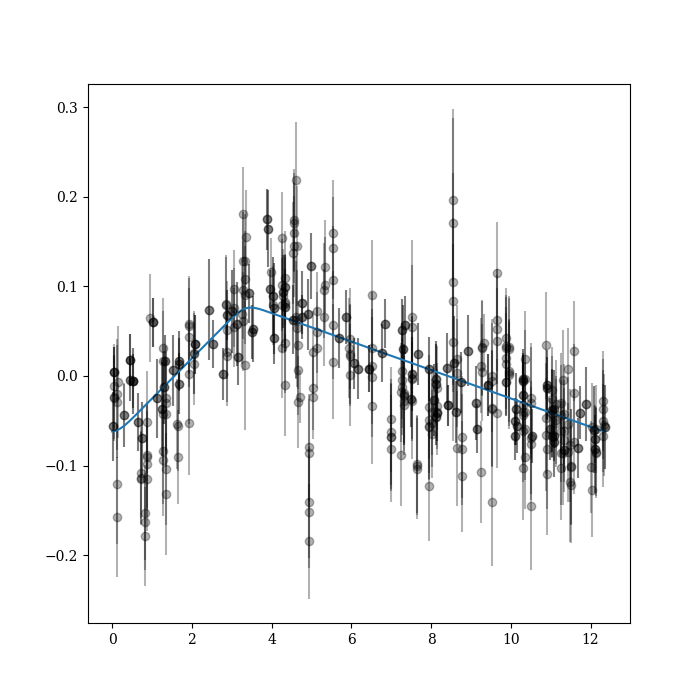

The rise phase duration: 
[3.48100503]


In [77]:

dbfile = "../calculation_output/undulation_profile_emcee/g_undulation_profile_mcmc_fitret_tmp.emcee"
refit = 0
show_corner_plot = 1
show_deviance = 0

parlist = ['rise', 'height', 'xshift', 'yshift']
params0 = {'rise': 2.5, 'height':0.15, 'xshift':4, 'yshift':-0.06}
fminfit = OneDFit2(parlist)


period = 12.37

xs = delta_g[:,0]   #obsJD - 2459700    
ys = delta_g[:,1]
yerrs = delta_g[:,2]
phases = (xs%period)/period

xfit = phases*period
yfit = ys
yerrfit = yerrs


for i,parname in enumerate(parlist):
    fminfit[parname] = params0[parname]


if (not os.path.exists(dbfile)) or refit:
    if os.path.exists(dbfile):
        os.remove(dbfile)

    priors = {}

    parname = 'rise'
    #prior = fuf.FuFPrior("limuniform", lower= -0.5, upper=-0.1) 
    prior = fuf.FuFPrior("gaussian", sig= 0.5, mu=params0[parname])
    priors[parname] = prior

    parname = 'height'
    #prior = fuf.FuFPrior("limuniform", lower= 0.1, upper=0.2) 
    prior = fuf.FuFPrior("gaussian", sig= 0.1, mu=params0[parname])
    priors[parname] = prior

    parname = 'xshift'
    #prior = fuf.FuFPrior("limuniform", lower= 0.5, upper=0.9) 
    prior = fuf.FuFPrior("gaussian", sig= 0.1, mu=params0[parname])
    priors[parname] = prior

    parname = 'yshift'
    #prior = fuf.FuFPrior("limuniform", lower= 0.5, upper=0.9) 
    prior = fuf.FuFPrior("gaussian", sig= 0.1, mu=params0[parname])
    priors[parname] = prior

    sampleArgs = {"iters": 50000, "burn": 10000}

    fminfit.thaw(parlist)
    X0 = fminfit.freeParameters()
    print("starting point for sampling:", X0)

    out = fminfit.fitEMCEE(xfit, yfit, yerr=yerrfit, sampleArgs=sampleArgs, priors=priors, dbfile=dbfile)


ta = fuf.TraceAnalysis(dbfile)
ta.setBurn(10000)


lds, index = ta.parameterSet(prescription="lowestDev")
print("Lowest deviance set: ", lds)
print("  at chain index: ", index)
means = ta.parameterSet(prescription="mean")
print("Set of mean values: ", means)
medians = ta.parameterSet(prescription="median")
print("Set of median values: ", means)


err_rise = ta.hpd('rise', cred=0.68)
err2_rise = ta.std('rise')
print('rise uncertainty:', err_rise, err2_rise)


### get the parameters with lowest deviance
for parname in parlist:
    fminfit[parname] = lds[parname]
    
fminfit.parameterSummary()

# corner plot
if show_corner_plot:
    corner_plot(dbfile)

# show the best-fit model
fig, ax = plt.subplots(figsize=(14,7))
P =12.37
xtemp = np.linspace(0, P, 200)
ax.plot(xtemp, fminfit.evaluate(xtemp), 'k')
ax.errorbar(phases*P, ys, yerr=yerrs, fmt='ro')
ax.errorbar(phases*P+P, ys, yerr=yerrs, fmt='ro')


#calculate chi2min
g2_params_lowestDEV = [lds['rise'], lds['height'],  lds['xshift'],  lds['yshift'], 0.2] 
fitdata = [xfit, yfit, yerrfit]
chi2min = calculate_chi2(g2_params_lowestDEV, fitdata)
print("chi2 best fit:", chi2min)

# deviance chain plot
if show_deviance:
    fig, ax = plt.subplots(figsize=(10,6))
    ax.plot(ta['deviance'])


## show the data and best-fit model in one period between two minima 
fig, ax = plt.subplots(figsize=(7,7))
xs = delta_g[:,0]   #obsJD - 2459700    
ys = delta_g[:,1]
yerrs = delta_g[:,2]
g_xshift = g2_params_lowestDEV[2]
ax.errorbar( (xs+g_xshift)%period , ys, yerr=yerrs, fmt='ko', alpha=0.3)
xs_model = np.linspace(0, P, 200)
ys_model = construct_emperical_bump_model(xs_model, P, g2_params_lowestDEV[0], g2_params_lowestDEV[1], 0, g2_params_lowestDEV[3], g2_params_lowestDEV[4], tbin=0.1)
print('The rise phase duration: ')
print(xs_model[ys_model==np.max(ys_model)] - xs_model[ys_model==np.min(ys_model)])
ax.plot(xs_model, ys_model)

#### r band 

Lowest deviance set:  {'rise': 2.069590330123978, 'height': 0.10947599116728748, 'xshift': 3.931099385104289, 'yshift': -0.058286353684059}
  at chain index:  167573
Set of mean values:  {'rise': 2.1378933018591595, 'height': 0.10986770118895883, 'xshift': 3.9184246850014057, 'yshift': -0.05864341798295049}
Set of median values:  {'rise': 2.1378933018591595, 'height': 0.10986770118895883, 'xshift': 3.9184246850014057, 'yshift': -0.05864341798295049}
rise uncertainty: (1.9077928403779565, 2.3596021807113896) 0.2268559965076543
---------------------------------
Parameters for Component: unnamed
---------------------------------
Parameter:   rise  , [  rise], value:      2.06959, free: False, restricted: False, related: False
Parameter: height  , [height], value:     0.109476, free: False, restricted: False, related: False
Parameter: xshift  , [xshift], value:       3.9311, free: False, restricted: False, related: False
Parameter: yshift  , [yshift], value:   -0.0582864, free: False, rest

<IPython.core.display.Javascript object>


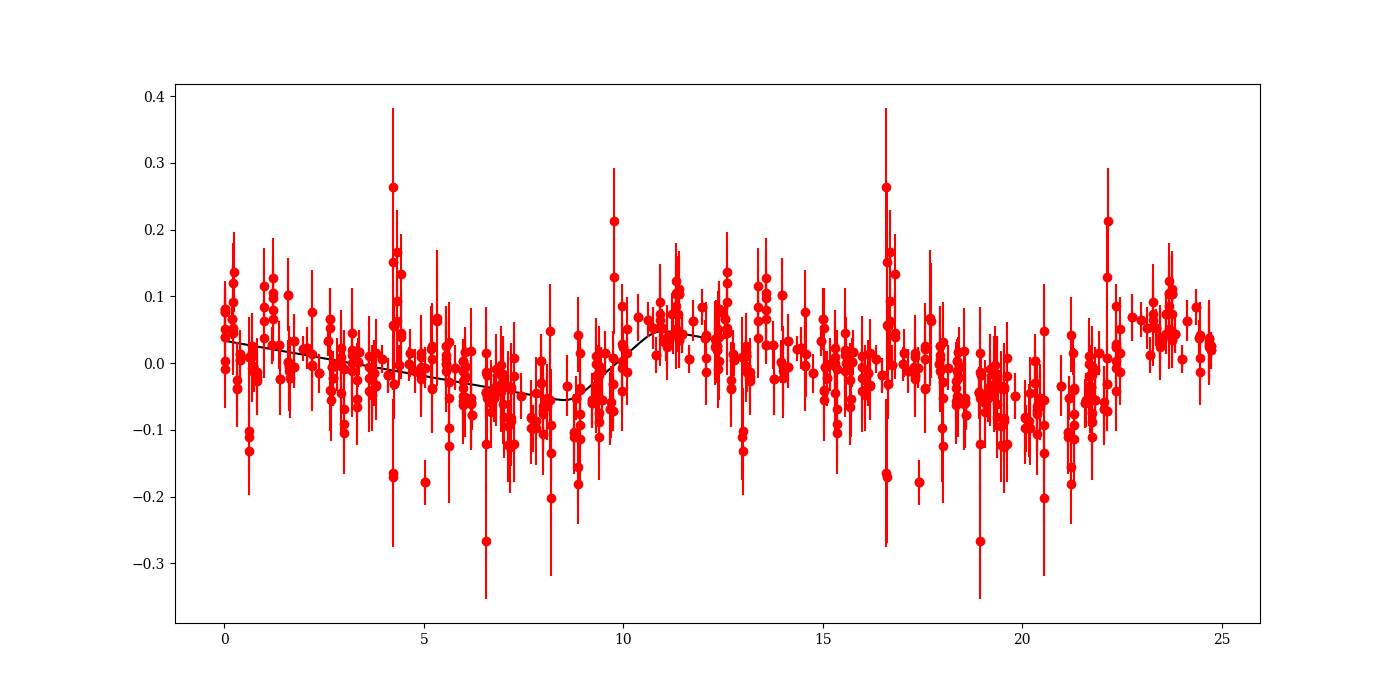

chi2 best fit: 367.56446857940637


<IPython.core.display.Javascript object>


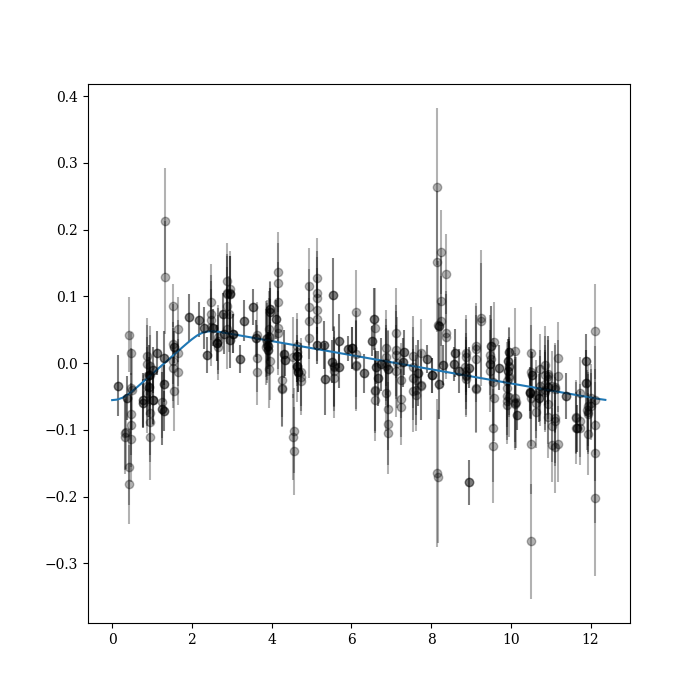

The rise phase duration: 
[2.4989899]


In [78]:

dbfile = "../calculation_output/undulation_profile_emcee/r_undulation_profile_mcmc_fitret_tmp.emcee"
refit = 0
show_corner_plot = 0
show_deviance = 0

parlist = ['rise', 'height', 'xshift', 'yshift']
params0 = {'rise': 2.5, 'height':0.15, 'xshift':4, 'yshift':-0.06}
fminfit = OneDFit2(parlist)


period = 12.37

xs = delta_r[:,0]   #obsJD - 2459700    
ys = delta_r[:,1]
yerrs = delta_r[:,2]
phases = (xs%period)/period

xfit = phases*period
yfit = ys
yerrfit = yerrs


for i,parname in enumerate(parlist):
    fminfit[parname] = params0[parname]


if (not os.path.exists(dbfile)) or refit:
    if os.path.exists(dbfile):
        os.remove(dbfile)

    priors = {}

    parname = 'rise'
    #prior = fuf.FuFPrior("limuniform", lower= -0.5, upper=-0.1) 
    prior = fuf.FuFPrior("gaussian", sig= 0.5, mu=params0[parname])
    priors[parname] = prior

    parname = 'height'
    #prior = fuf.FuFPrior("limuniform", lower= 0.1, upper=0.2) 
    prior = fuf.FuFPrior("gaussian", sig= 0.1, mu=params0[parname])
    priors[parname] = prior

    parname = 'xshift'
    #prior = fuf.FuFPrior("limuniform", lower= 0.5, upper=0.9) 
    prior = fuf.FuFPrior("gaussian", sig= 0.1, mu=params0[parname])
    priors[parname] = prior

    parname = 'yshift'
    #prior = fuf.FuFPrior("limuniform", lower= 0.5, upper=0.9) 
    prior = fuf.FuFPrior("gaussian", sig= 0.1, mu=params0[parname])
    priors[parname] = prior

    sampleArgs = {"iters": 50000, "burn": 10000}

    fminfit.thaw(parlist)
    X0 = fminfit.freeParameters()
    print("starting point for sampling:", X0)

    out = fminfit.fitEMCEE(xfit, yfit, yerr=yerrfit, sampleArgs=sampleArgs, priors=priors, dbfile=dbfile)


ta = fuf.TraceAnalysis(dbfile)
ta.setBurn(10000)


lds, index = ta.parameterSet(prescription="lowestDev")
print("Lowest deviance set: ", lds)
print("  at chain index: ", index)
means = ta.parameterSet(prescription="mean")
print("Set of mean values: ", means)
medians = ta.parameterSet(prescription="median")
print("Set of median values: ", means)


err_rise = ta.hpd('rise', cred=0.68)
err2_rise = ta.std('rise')
print('rise uncertainty:', err_rise, err2_rise)


### get the parameters with lowest deviance
for parname in parlist:
    fminfit[parname] = lds[parname]
    
fminfit.parameterSummary()

# corner plot
if show_corner_plot:
    corner_plot(dbfile)

# show the best-fit model
fig, ax = plt.subplots(figsize=(14,7))
P =12.37
xtemp = np.linspace(0, P, 200)
ax.plot(xtemp, fminfit.evaluate(xtemp), 'k')
ax.errorbar(phases*P, ys, yerr=yerrs, fmt='ro')
ax.errorbar(phases*P+P, ys, yerr=yerrs, fmt='ro')


#calculate chi2min
r2_params_lowestDEV = [lds['rise'], lds['height'],  lds['xshift'],  lds['yshift'], 0.2] 
fitdata = [xfit, yfit, yerrfit]
chi2min = calculate_chi2(r2_params_lowestDEV, fitdata)
print("chi2 best fit:", chi2min)

# deviance chain plot
if show_deviance:
    fig, ax = plt.subplots(figsize=(10,6))
    ax.plot(ta['deviance'])


## show the data and best-fit model in one period between two minima 
fig, ax = plt.subplots(figsize=(7,7))
xs = delta_r[:,0]   #obsJD - 2459700    
ys = delta_r[:,1]
yerrs = delta_r[:,2]
r_xshift = r2_params_lowestDEV[2]
ax.errorbar( (xs+r_xshift)%period , ys, yerr=yerrs, fmt='ko', alpha=0.3)
xs_model = np.linspace(0, P, 100)
ys_model = construct_emperical_bump_model(xs_model, P, r2_params_lowestDEV[0], r2_params_lowestDEV[1], 0, r2_params_lowestDEV[3], r2_params_lowestDEV[4], tbin=0.1)
ax.plot(xs_model, ys_model)

print('The rise phase duration: ')
print(xs_model[ys_model==np.max(ys_model)] - xs_model[ys_model==np.min(ys_model)])

### i band

Lowest deviance set:  {'rise': 2.0715977342819425, 'height': 0.18281897849291298, 'xshift': 3.932422600375307, 'yshift': -0.08203762165856045}
  at chain index:  164859
Set of mean values:  {'rise': 2.1236612465517677, 'height': 0.18090163174457724, 'xshift': 3.92145346835574, 'yshift': -0.08126950618079432}
Set of median values:  {'rise': 2.1236612465517677, 'height': 0.18090163174457724, 'xshift': 3.92145346835574, 'yshift': -0.08126950618079432}
rise uncertainty: (1.9427092888549549, 2.3032286907575) 0.18251569276157834
---------------------------------
Parameters for Component: unnamed
---------------------------------
Parameter:   rise  , [  rise], value:       2.0716, free: False, restricted: False, related: False
Parameter: height  , [height], value:     0.182819, free: False, restricted: False, related: False
Parameter: xshift  , [xshift], value:      3.93242, free: False, restricted: False, related: False
Parameter: yshift  , [yshift], value:   -0.0820376, free: False, restric

<IPython.core.display.Javascript object>


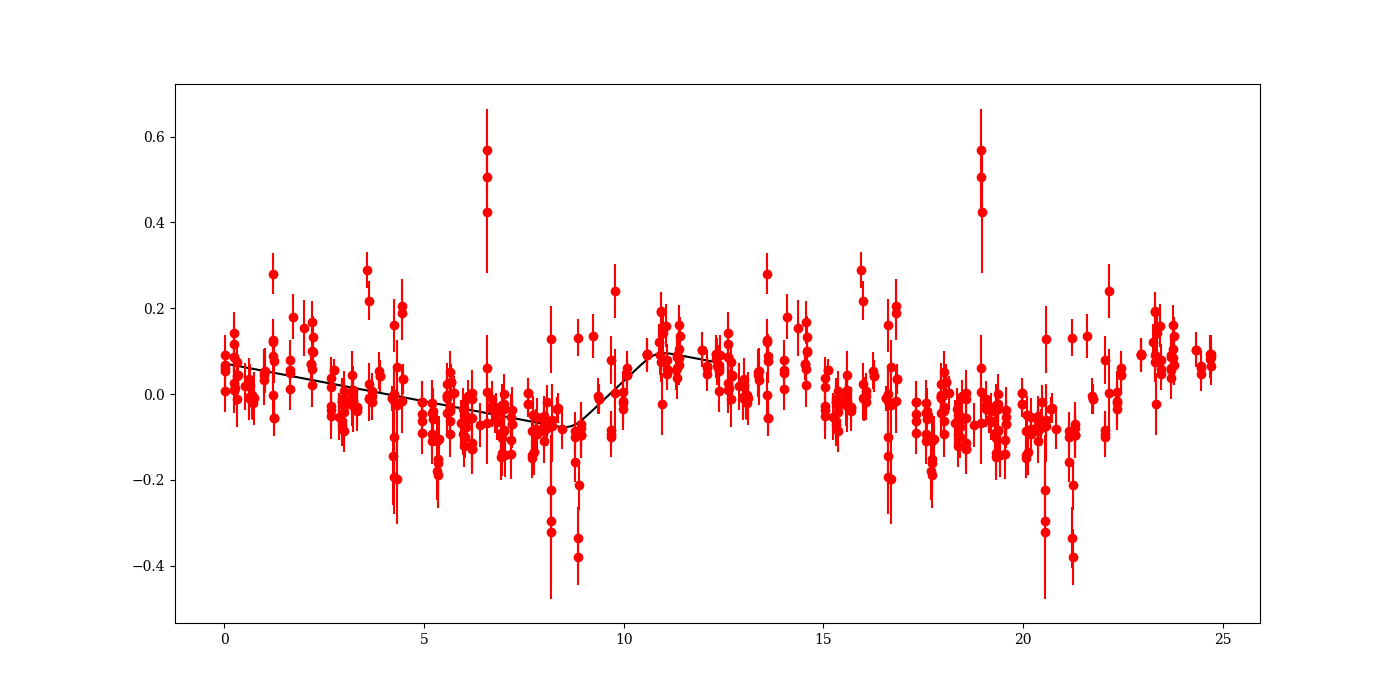

chi2 best fit: 597.9013112957845


<IPython.core.display.Javascript object>


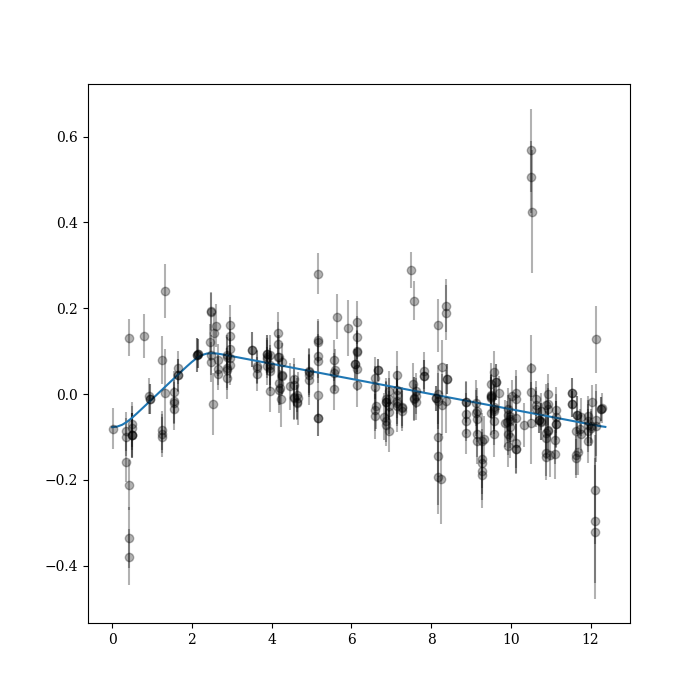

The rise phase duration: 
[2.4989899]


In [79]:

dbfile = "../calculation_output/undulation_profile_emcee/i_undulation_profile_mcmc_fitret_tmp.emcee"
refit = 0
show_corner_plot = 0
show_deviance = 0

parlist = ['rise', 'height', 'xshift', 'yshift']
params0 = {'rise': 2.5, 'height':0.15, 'xshift':4, 'yshift':-0.06}
fminfit = OneDFit2(parlist)


period = 12.37

xs = delta_i[:,0]   #obsJD - 2459700    
ys = delta_i[:,1]
yerrs = delta_i[:,2]
phases = (xs%period)/period

xfit = phases*period
yfit = ys
yerrfit = yerrs


for i,parname in enumerate(parlist):
    fminfit[parname] = params0[parname]


if (not os.path.exists(dbfile)) or refit:
    if os.path.exists(dbfile):
        os.remove(dbfile)

    priors = {}

    parname = 'rise'
    #prior = fuf.FuFPrior("limuniform", lower= -0.5, upper=-0.1) 
    prior = fuf.FuFPrior("gaussian", sig= 0.5, mu=params0[parname])
    priors[parname] = prior

    parname = 'height'
    #prior = fuf.FuFPrior("limuniform", lower= 0.1, upper=0.2) 
    prior = fuf.FuFPrior("gaussian", sig= 0.1, mu=params0[parname])
    priors[parname] = prior

    parname = 'xshift'
    #prior = fuf.FuFPrior("limuniform", lower= 0.5, upper=0.9) 
    prior = fuf.FuFPrior("gaussian", sig= 0.1, mu=params0[parname])
    priors[parname] = prior

    parname = 'yshift'
    #prior = fuf.FuFPrior("limuniform", lower= 0.5, upper=0.9) 
    prior = fuf.FuFPrior("gaussian", sig= 0.1, mu=params0[parname])
    priors[parname] = prior

    sampleArgs = {"iters": 50000, "burn": 10000}

    fminfit.thaw(parlist)
    X0 = fminfit.freeParameters()
    print("starting point for sampling:", X0)

    out = fminfit.fitEMCEE(xfit, yfit, yerr=yerrfit, sampleArgs=sampleArgs, priors=priors, dbfile=dbfile)


ta = fuf.TraceAnalysis(dbfile)
ta.setBurn(10000)


lds, index = ta.parameterSet(prescription="lowestDev")
print("Lowest deviance set: ", lds)
print("  at chain index: ", index)
means = ta.parameterSet(prescription="mean")
print("Set of mean values: ", means)
medians = ta.parameterSet(prescription="median")
print("Set of median values: ", means)


err_rise = ta.hpd('rise', cred=0.68)
err2_rise = ta.std('rise')
print('rise uncertainty:', err_rise, err2_rise)


### get the parameters with lowest deviance
for parname in parlist:
    fminfit[parname] = lds[parname]
    
fminfit.parameterSummary()

# corner plot
if show_corner_plot:
    corner_plot(dbfile)

# show the best-fit model
fig, ax = plt.subplots(figsize=(14,7))
P =12.37
xtemp = np.linspace(0, P, 200)
ax.plot(xtemp, fminfit.evaluate(xtemp), 'k')
ax.errorbar(phases*P, ys, yerr=yerrs, fmt='ro')
ax.errorbar(phases*P+P, ys, yerr=yerrs, fmt='ro')


#calculate chi2min
i2_params_lowestDEV = [lds['rise'], lds['height'],  lds['xshift'],  lds['yshift'], 0.2] 
fitdata = [xfit, yfit, yerrfit]
chi2min = calculate_chi2(i2_params_lowestDEV, fitdata)
print("chi2 best fit:", chi2min)

# deviance chain plot
if show_deviance:
    fig, ax = plt.subplots(figsize=(10,6))
    ax.plot(ta['deviance'])


## show the data and best-fit model in one period between two minima 
fig, ax = plt.subplots(figsize=(7,7))
xs = delta_i[:,0]   #obsJD - 2459700    
ys = delta_i[:,1]
yerrs = delta_i[:,2]
i_xshift = i2_params_lowestDEV[2]
ax.errorbar( (xs+i_xshift)%period , ys, yerr=yerrs, fmt='ko', alpha=0.3)
xs_model = np.linspace(0, P, 100)
ys_model = construct_emperical_bump_model(xs_model, P, i2_params_lowestDEV[0], i2_params_lowestDEV[1], 0, i2_params_lowestDEV[3], i2_params_lowestDEV[4], tbin=0.1)
ax.plot(xs_model, ys_model)

print('The rise phase duration: ')
print(xs_model[ys_model==np.max(ys_model)] - xs_model[ys_model==np.min(ys_model)])

### z band

Lowest deviance set:  {'rise': 2.360581681621005, 'height': 0.15833623786587606, 'xshift': 4.003123315780587, 'yshift': -0.07212712502984636}
  at chain index:  94547
Set of mean values:  {'rise': 2.4136451725976324, 'height': 0.15803081704111094, 'xshift': 3.997344237917242, 'yshift': -0.07193391446547083}
Set of median values:  {'rise': 2.4136451725976324, 'height': 0.15803081704111094, 'xshift': 3.997344237917242, 'yshift': -0.07193391446547083}
rise uncertainty: (2.058145477973692, 2.7253918398260906) 0.33485870378505905
---------------------------------
Parameters for Component: unnamed
---------------------------------
Parameter:   rise  , [  rise], value:      2.36058, free: False, restricted: False, related: False
Parameter: height  , [height], value:     0.158336, free: False, restricted: False, related: False
Parameter: xshift  , [xshift], value:      4.00312, free: False, restricted: False, related: False
Parameter: yshift  , [yshift], value:   -0.0721271, free: False, restr

<IPython.core.display.Javascript object>


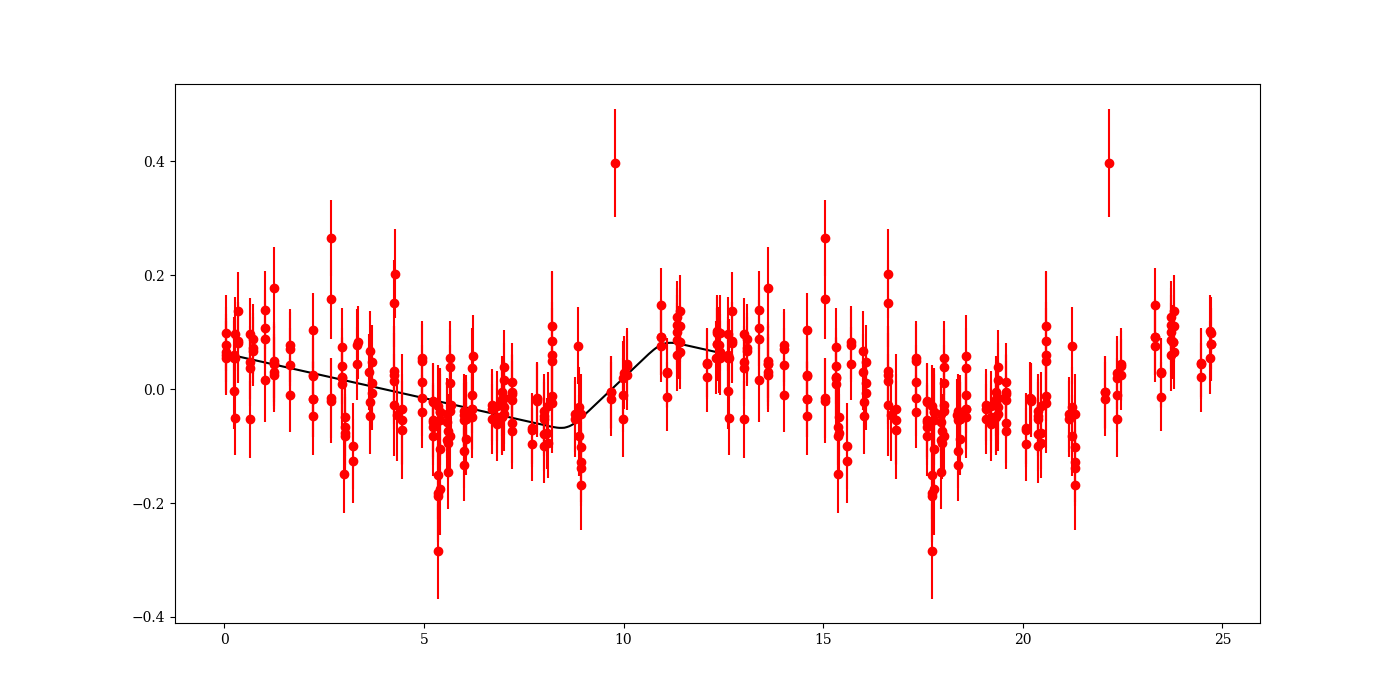

chi2 best fit: 179.23692418209384


<IPython.core.display.Javascript object>


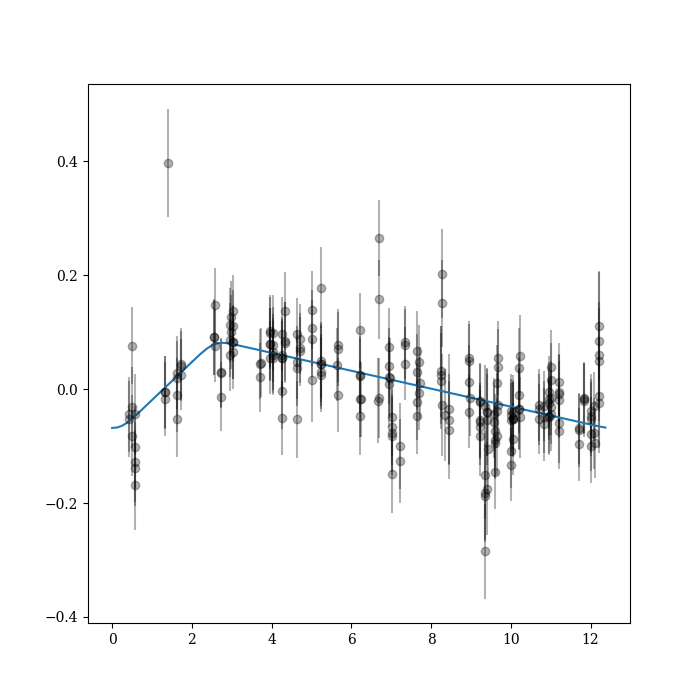

The rise phase duration: 
[2.74888889]


In [80]:

dbfile = "../calculation_output/undulation_profile_emcee/z_undulation_profile_mcmc_fitret_tmp.emcee"
refit = 0
show_corner_plot = 0
show_deviance = 0

parlist = ['rise', 'height', 'xshift', 'yshift']
params0 = {'rise': 2.5, 'height':0.15, 'xshift':4, 'yshift':-0.06}
fminfit = OneDFit2(parlist)


period = 12.37

xs = delta_z[:,0]   #obsJD - 2459700    
ys = delta_z[:,1]
yerrs = delta_z[:,2]
phases = (xs%period)/period

xfit = phases*period
yfit = ys
yerrfit = yerrs


for i,parname in enumerate(parlist):
    fminfit[parname] = params0[parname]


if (not os.path.exists(dbfile)) or refit:
    if os.path.exists(dbfile):
        os.remove(dbfile)

    priors = {}

    parname = 'rise'
    #prior = fuf.FuFPrior("limuniform", lower= -0.5, upper=-0.1) 
    prior = fuf.FuFPrior("gaussian", sig= 0.5, mu=params0[parname])
    priors[parname] = prior

    parname = 'height'
    #prior = fuf.FuFPrior("limuniform", lower= 0.1, upper=0.2) 
    prior = fuf.FuFPrior("gaussian", sig= 0.1, mu=params0[parname])
    priors[parname] = prior

    parname = 'xshift'
    #prior = fuf.FuFPrior("limuniform", lower= 0.5, upper=0.9) 
    prior = fuf.FuFPrior("gaussian", sig= 0.1, mu=params0[parname])
    priors[parname] = prior

    parname = 'yshift'
    #prior = fuf.FuFPrior("limuniform", lower= 0.5, upper=0.9) 
    prior = fuf.FuFPrior("gaussian", sig= 0.1, mu=params0[parname])
    priors[parname] = prior

    sampleArgs = {"iters": 50000, "burn": 10000}

    fminfit.thaw(parlist)
    X0 = fminfit.freeParameters()
    print("starting point for sampling:", X0)

    out = fminfit.fitEMCEE(xfit, yfit, yerr=yerrfit, sampleArgs=sampleArgs, priors=priors, dbfile=dbfile)


ta = fuf.TraceAnalysis(dbfile)
ta.setBurn(10000)


lds, index = ta.parameterSet(prescription="lowestDev")
print("Lowest deviance set: ", lds)
print("  at chain index: ", index)
means = ta.parameterSet(prescription="mean")
print("Set of mean values: ", means)
medians = ta.parameterSet(prescription="median")
print("Set of median values: ", means)


err_rise = ta.hpd('rise', cred=0.68)
err2_rise = ta.std('rise')
print('rise uncertainty:', err_rise, err2_rise)


### get the parameters with lowest deviance
for parname in parlist:
    fminfit[parname] = lds[parname]
    
fminfit.parameterSummary()

# corner plot
if show_corner_plot:
    corner_plot(dbfile)

# show the best-fit model
fig, ax = plt.subplots(figsize=(14,7))
P =12.37
xtemp = np.linspace(0, P, 200)
ax.plot(xtemp, fminfit.evaluate(xtemp), 'k')
ax.errorbar(phases*P, ys, yerr=yerrs, fmt='ro')
ax.errorbar(phases*P+P, ys, yerr=yerrs, fmt='ro')


#calculate chi2min
z2_params_lowestDEV = [lds['rise'], lds['height'],  lds['xshift'],  lds['yshift'], 0.2] 
fitdata = [xfit, yfit, yerrfit]
chi2min = calculate_chi2(z2_params_lowestDEV, fitdata)
print("chi2 best fit:", chi2min)

# deviance chain plot
if show_deviance:
    fig, ax = plt.subplots(figsize=(10,6))
    ax.plot(ta['deviance'])


## show the data and best-fit model in one period between two minima 
fig, ax = plt.subplots(figsize=(7,7))
xs = delta_z[:,0]   #obsJD - 2459700    
ys = delta_z[:,1]
yerrs = delta_z[:,2]
z_xshift = z2_params_lowestDEV[2]
ax.errorbar( (xs+z_xshift)%period , ys, yerr=yerrs, fmt='ko', alpha=0.3)
xs_model = np.linspace(0, P, 100)
ys_model = construct_emperical_bump_model(xs_model, P, z2_params_lowestDEV[0], z2_params_lowestDEV[1], 0, z2_params_lowestDEV[3], z2_params_lowestDEV[4], tbin=0.1)
ax.plot(xs_model, ys_model)

print('The rise phase duration: ')
print(xs_model[ys_model==np.max(ys_model)] - xs_model[ys_model==np.min(ys_model)])

### c band

Lowest deviance set:  {'rise': 1.4153731970240662, 'height': 0.10589822311131797, 'xshift': 3.9320273711233793, 'yshift': -0.05855007457368546}
  at chain index:  289948
Set of mean values:  {'rise': 1.5154507884808903, 'height': 0.10513845882116156, 'xshift': 3.9730410379163748, 'yshift': -0.058244880806014844}
Set of median values:  {'rise': 1.5154507884808903, 'height': 0.10513845882116156, 'xshift': 3.9730410379163748, 'yshift': -0.058244880806014844}
rise uncertainty: (1.2732542845164077, 1.7158652875419653) 0.20868182027723003
---------------------------------
Parameters for Component: unnamed
---------------------------------
Parameter:   rise  , [  rise], value:      1.41537, free: False, restricted: False, related: False
Parameter: height  , [height], value:     0.105898, free: False, restricted: False, related: False
Parameter: xshift  , [xshift], value:      3.93203, free: False, restricted: False, related: False
Parameter: yshift  , [yshift], value:   -0.0585501, free: Fals

<IPython.core.display.Javascript object>


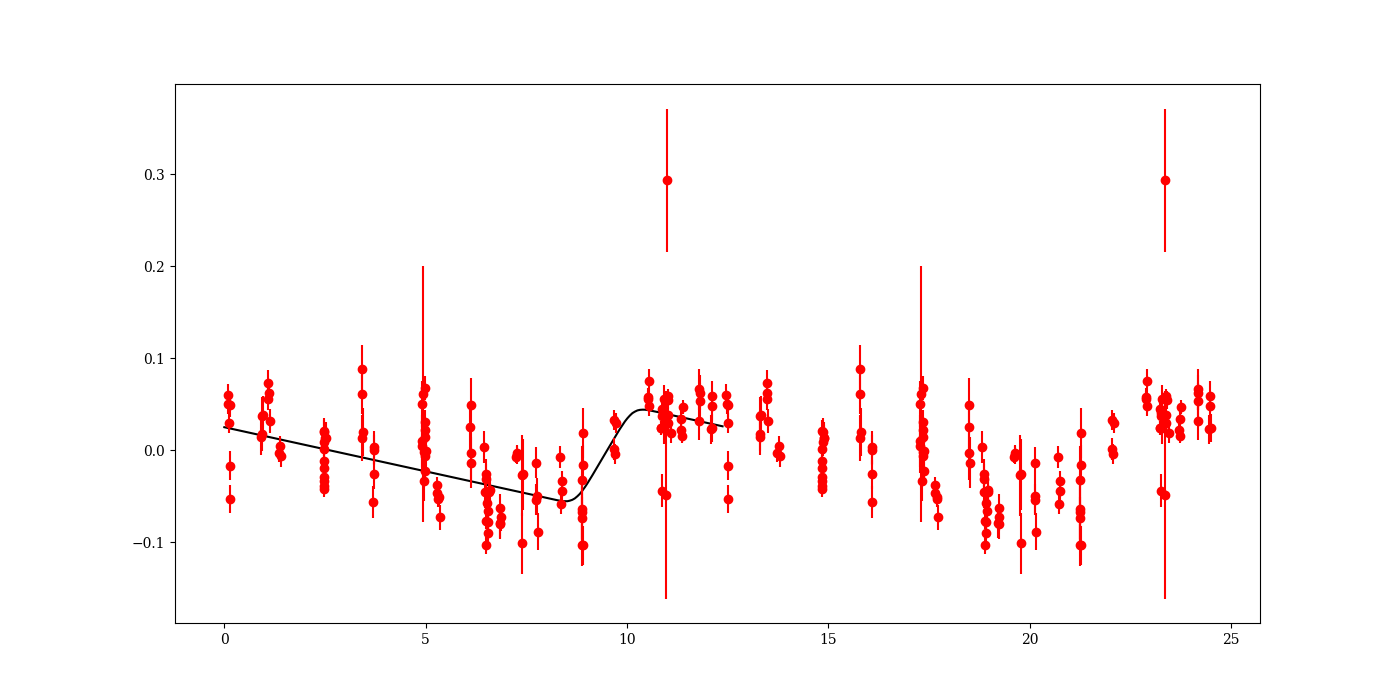

chi2 best fit: 723.0529498332523


<IPython.core.display.Javascript object>


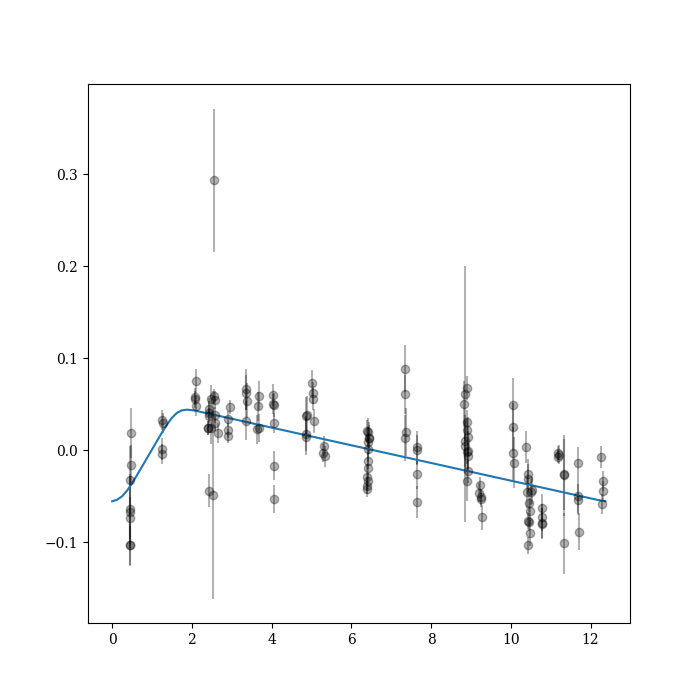

The rise phase duration: 
[1.87424242]


In [81]:

dbfile = "../calculation_output/undulation_profile_emcee/c_undulation_profile_mcmc_fitret_tmp.emcee"
refit = 0
show_corner_plot = 0
show_deviance = 0

parlist = ['rise', 'height', 'xshift', 'yshift']
params0 = {'rise': 2.5, 'height':0.15, 'xshift':4, 'yshift':-0.06}
fminfit = OneDFit2(parlist)


period = 12.37

xs = delta_c[:,0]   #obsJD - 2459700    
ys = delta_c[:,1]
yerrs = delta_c[:,2]
phases = (xs%period)/period

xfit = phases*period
yfit = ys
yerrfit = yerrs


for i,parname in enumerate(parlist):
    fminfit[parname] = params0[parname]


if (not os.path.exists(dbfile)) or refit:
    if os.path.exists(dbfile):
        os.remove(dbfile)

    priors = {}

    parname = 'rise'
    #prior = fuf.FuFPrior("limuniform", lower= -0.5, upper=-0.1) 
    prior = fuf.FuFPrior("gaussian", sig= 0.5, mu=params0[parname])
    priors[parname] = prior

    parname = 'height'
    #prior = fuf.FuFPrior("limuniform", lower= 0.1, upper=0.2) 
    prior = fuf.FuFPrior("gaussian", sig= 0.1, mu=params0[parname])
    priors[parname] = prior

    parname = 'xshift'
    #prior = fuf.FuFPrior("limuniform", lower= 0.5, upper=0.9) 
    prior = fuf.FuFPrior("gaussian", sig= 0.1, mu=params0[parname])
    priors[parname] = prior

    parname = 'yshift'
    #prior = fuf.FuFPrior("limuniform", lower= 0.5, upper=0.9) 
    prior = fuf.FuFPrior("gaussian", sig= 0.1, mu=params0[parname])
    priors[parname] = prior

    sampleArgs = {"iters": 50000, "burn": 10000}

    fminfit.thaw(parlist)
    X0 = fminfit.freeParameters()
    print("starting point for sampling:", X0)

    out = fminfit.fitEMCEE(xfit, yfit, yerr=yerrfit, sampleArgs=sampleArgs, priors=priors, dbfile=dbfile)


ta = fuf.TraceAnalysis(dbfile)
ta.setBurn(10000)


lds, index = ta.parameterSet(prescription="lowestDev")
print("Lowest deviance set: ", lds)
print("  at chain index: ", index)
means = ta.parameterSet(prescription="mean")
print("Set of mean values: ", means)
medians = ta.parameterSet(prescription="median")
print("Set of median values: ", means)


err_rise = ta.hpd('rise', cred=0.68)
err2_rise = ta.std('rise')
print('rise uncertainty:', err_rise, err2_rise)


### get the parameters with lowest deviance
for parname in parlist:
    fminfit[parname] = lds[parname]
    
fminfit.parameterSummary()

# corner plot
if show_corner_plot:
    corner_plot(dbfile)

# show the best-fit model
fig, ax = plt.subplots(figsize=(14,7))
P =12.37
xtemp = np.linspace(0, P, 200)
ax.plot(xtemp, fminfit.evaluate(xtemp), 'k')
ax.errorbar(phases*P, ys, yerr=yerrs, fmt='ro')
ax.errorbar(phases*P+P, ys, yerr=yerrs, fmt='ro')


#calculate chi2min
c2_params_lowestDEV = [lds['rise'], lds['height'],  lds['xshift'],  lds['yshift'], 0.2] 
fitdata = [xfit, yfit, yerrfit]
chi2min = calculate_chi2(c2_params_lowestDEV, fitdata)
print("chi2 best fit:", chi2min)

# deviance chain plot
if show_deviance:
    fig, ax = plt.subplots(figsize=(10,6))
    ax.plot(ta['deviance'])


## show the data and best-fit model in one period between two minima 
fig, ax = plt.subplots(figsize=(7,7))
xs = delta_c[:,0]   #obsJD - 2459700    
ys = delta_c[:,1]
yerrs = delta_c[:,2]
c_xshift = c2_params_lowestDEV[2]
ax.errorbar( (xs+c_xshift)%period , ys, yerr=yerrs, fmt='ko', alpha=0.3)
xs_model = np.linspace(0, P, 100)
ys_model = construct_emperical_bump_model(xs_model, P, c2_params_lowestDEV[0], c2_params_lowestDEV[1], 0, c2_params_lowestDEV[3], c2_params_lowestDEV[4], tbin=0.1)
ax.plot(xs_model, ys_model)

print('The rise phase duration: ')
print(xs_model[ys_model==np.max(ys_model)] - xs_model[ys_model==np.min(ys_model)])

### o band

Lowest deviance set:  {'rise': 1.330755896055802, 'height': 0.12027096437310422, 'xshift': 3.8286953983214222, 'yshift': -0.057807392206952656}
  at chain index:  171767
Set of mean values:  {'rise': 1.316627530016526, 'height': 0.11976000944483542, 'xshift': 3.742712597433147, 'yshift': -0.05736180519080922}
Set of median values:  {'rise': 1.316627530016526, 'height': 0.11976000944483542, 'xshift': 3.742712597433147, 'yshift': -0.05736180519080922}
rise uncertainty: (1.199538137365458, 1.358858019657872) 0.07875361833179709
---------------------------------
Parameters for Component: unnamed
---------------------------------
Parameter:   rise  , [  rise], value:      1.33076, free: False, restricted: False, related: False
Parameter: height  , [height], value:     0.120271, free: False, restricted: False, related: False
Parameter: xshift  , [xshift], value:       3.8287, free: False, restricted: False, related: False
Parameter: yshift  , [yshift], value:   -0.0578074, free: False, restr

<IPython.core.display.Javascript object>


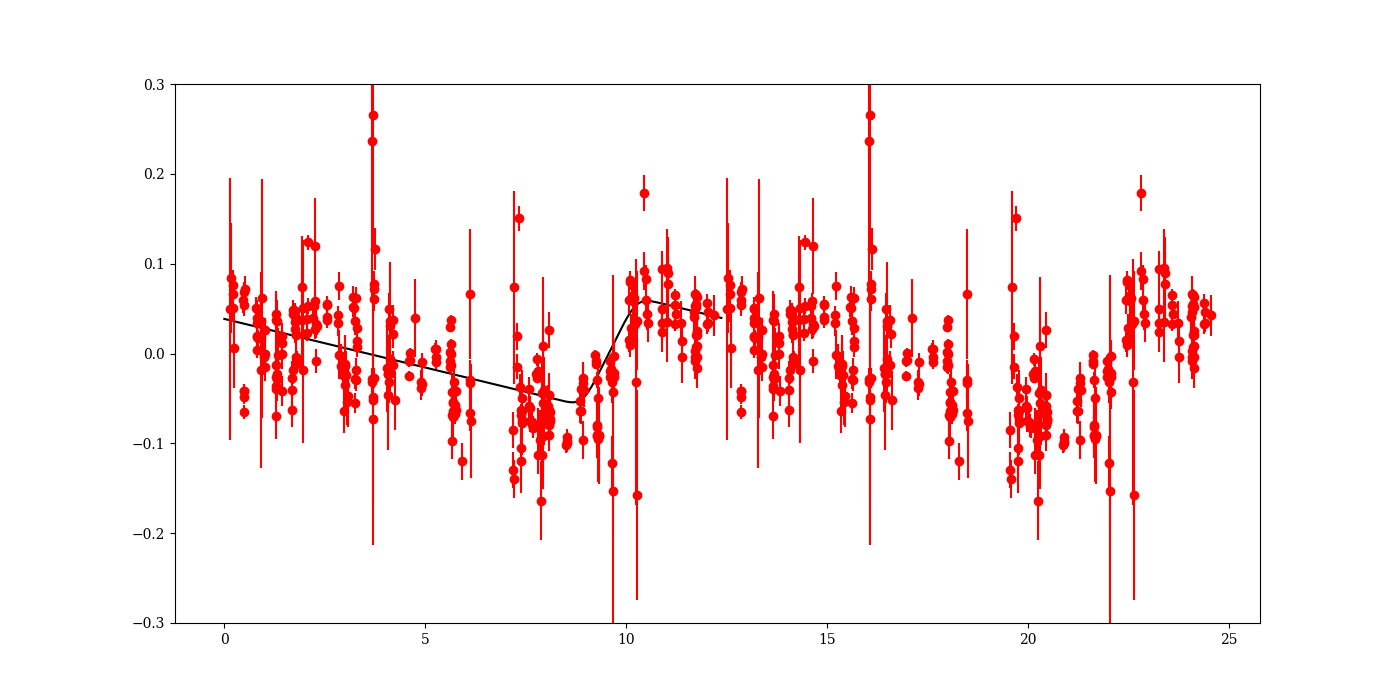

chi2 best fit: 3756.283328691789


<IPython.core.display.Javascript object>


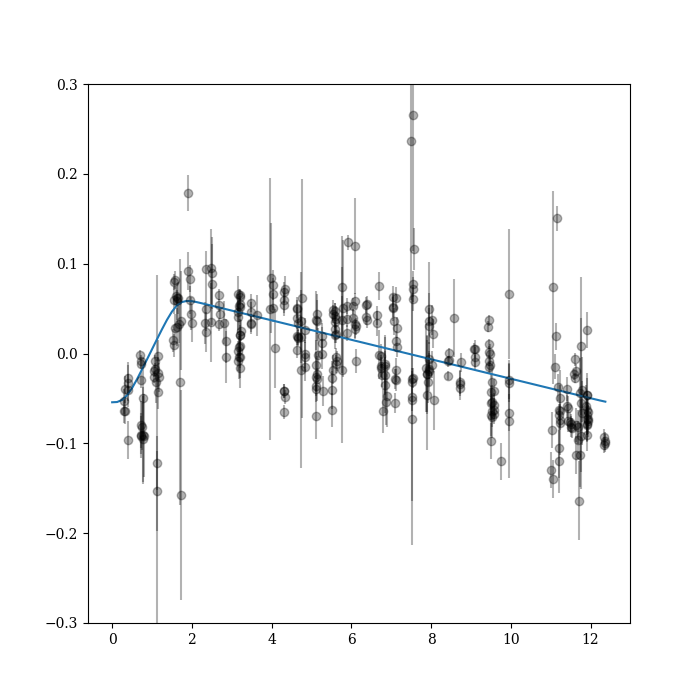

The rise phase duration: 
[1.87424242]


In [85]:

dbfile = "../calculation_output/undulation_profile_emcee/o_undulation_profile_mcmc_fitret_tmp.emcee"
refit = 0
show_corner_plot = 0
show_deviance = 0

parlist = ['rise', 'height', 'xshift', 'yshift']
params0 = {'rise': 2.5, 'height':0.15, 'xshift':4, 'yshift':-0.06}
fminfit = OneDFit2(parlist)


period = 12.37

xs = delta_o[:,0]   #obsJD - 2459700    
ys = delta_o[:,1]
yerrs = delta_o[:,2]
phases = (xs%period)/period

xfit = phases*period
yfit = ys
yerrfit = yerrs


for i,parname in enumerate(parlist):
    fminfit[parname] = params0[parname]


if (not os.path.exists(dbfile)) or refit:
    if os.path.exists(dbfile):
        os.remove(dbfile)

    priors = {}

    parname = 'rise'
    #prior = fuf.FuFPrior("limuniform", lower= -0.5, upper=-0.1) 
    prior = fuf.FuFPrior("gaussian", sig= 0.5, mu=params0[parname])
    priors[parname] = prior

    parname = 'height'
    #prior = fuf.FuFPrior("limuniform", lower= 0.1, upper=0.2) 
    prior = fuf.FuFPrior("gaussian", sig= 0.1, mu=params0[parname])
    priors[parname] = prior

    parname = 'xshift'
    #prior = fuf.FuFPrior("limuniform", lower= 0.5, upper=0.9) 
    prior = fuf.FuFPrior("gaussian", sig= 0.1, mu=params0[parname])
    priors[parname] = prior

    parname = 'yshift'
    #prior = fuf.FuFPrior("limuniform", lower= 0.5, upper=0.9) 
    prior = fuf.FuFPrior("gaussian", sig= 0.1, mu=params0[parname])
    priors[parname] = prior

    sampleArgs = {"iters": 50000, "burn": 10000}

    fminfit.thaw(parlist)
    X0 = fminfit.freeParameters()
    print("starting point for sampling:", X0)

    out = fminfit.fitEMCEE(xfit, yfit, yerr=yerrfit, sampleArgs=sampleArgs, priors=priors, dbfile=dbfile)


ta = fuf.TraceAnalysis(dbfile)
ta.setBurn(10000)


lds, index = ta.parameterSet(prescription="lowestDev")
print("Lowest deviance set: ", lds)
print("  at chain index: ", index)
means = ta.parameterSet(prescription="mean")
print("Set of mean values: ", means)
medians = ta.parameterSet(prescription="median")
print("Set of median values: ", means)


err_rise = ta.hpd('rise', cred=0.68)
err2_rise = ta.std('rise')
print('rise uncertainty:', err_rise, err2_rise)


### get the parameters with lowest deviance
for parname in parlist:
    fminfit[parname] = lds[parname]
    
fminfit.parameterSummary()

# corner plot
if show_corner_plot:
    corner_plot(dbfile)

# show the best-fit model
fig, ax = plt.subplots(figsize=(14,7))
P =12.37
xtemp = np.linspace(0, P, 200)
ax.plot(xtemp, fminfit.evaluate(xtemp), 'k')
ax.errorbar(phases*P, ys, yerr=yerrs, fmt='ro')
ax.errorbar(phases*P+P, ys, yerr=yerrs, fmt='ro')
ax.set_ylim([-0.3, 0.3])

#calculate chi2min
o2_params_lowestDEV = [lds['rise'], lds['height'],  lds['xshift'],  lds['yshift'], 0.2] 
fitdata = [xfit, yfit, yerrfit]
chi2min = calculate_chi2(o2_params_lowestDEV, fitdata)
print("chi2 best fit:", chi2min)

# deviance chain plot
if show_deviance:
    fig, ax = plt.subplots(figsize=(10,6))
    ax.plot(ta['deviance'])


## show the data and best-fit model in one period between two minima 
fig, ax = plt.subplots(figsize=(7,7))
xs = delta_o[:,0]   #obsJD - 2459700    
ys = delta_o[:,1]
yerrs = delta_o[:,2]
o_xshift = o2_params_lowestDEV[2]
ax.errorbar( (xs+o_xshift)%period , ys, yerr=yerrs, fmt='ko', alpha=0.3)
xs_model = np.linspace(0, P, 100)
ys_model = construct_emperical_bump_model(xs_model, P, o2_params_lowestDEV[0], o2_params_lowestDEV[1], 0, o2_params_lowestDEV[3], o2_params_lowestDEV[4], tbin=0.1)
ax.plot(xs_model, ys_model)
ax.set_ylim([-0.3, 0.3])

print('The rise phase duration: ')
print(xs_model[ys_model==np.max(ys_model)] - xs_model[ys_model==np.min(ys_model)])

## Main Fig 1

In [ ]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'serif'


cmap = mpl.cm.coolwarm
Nflt  = 7
norm = mpl.colors.Normalize(vmin=0, vmax=Nflt)


Pfold = 12.4


#fig, (ax, ax2) = plt.subplots(2,1, figsize=(8,10))

fig = plt.figure(figsize=(8,9))
gs0 = GridSpec(25, 1, figure=fig, hspace=0.0, wspace=0, left=0.1, right=0.98, bottom=0.06, top=0.98)

ax = fig.add_subplot(gs0[0:12, 0])

ax2 = fig.add_subplot(gs0[13:15, 0])
ax3 = fig.add_subplot(gs0[15:17, 0], sharex=ax2, sharey=ax2)
ax4 = fig.add_subplot(gs0[17:19, 0], sharex=ax2, sharey=ax2)
ax5 = fig.add_subplot(gs0[19:21, 0], sharex=ax2, sharey=ax2)
ax6 = fig.add_subplot(gs0[21:23, 0], sharex=ax2, sharey=ax2)
ax7 = fig.add_subplot(gs0[23:25, 0])

axins = ax.inset_axes([0.06, 0.06, 0.45, 0.4])


g_color= cmap(0.0)
g_offset = -0.8
RP_g_offset = -0.15
axins.errorbar(RP_g[:,0],  RP_g[:,1]+g_offset+RP_g_offset, yerr=RP_g[:,2], fmt='o', color=g_color,ms=3)
axins.errorbar(ztfg[:,0],  ztfg[:,1]+g_offset, yerr=ztfg[:,2], fmt='o', color=g_color, ms=3, label=r'$g - 0.8$')
axins.errorbar(asas_g[:,0], asas_g[:,1]+g_offset, yerr=asas_g[:,2], fmt='x', color=g_color, mew=3, ms=3) #ASAS-SN  


r_color= cmap(0.2)
r_offset = 0
RP_r_offset = 0
axins.errorbar(RP_r[:,0], RP_r[:,1], yerr=RP_r[:,2], fmt='o', color=r_color, ms=3)
axins.errorbar(ztfr[:,0], ztfr[:,1], yerr=ztfr[:,2], fmt='o', color=r_color, ms=3, label=r'$r$')
axins.errorbar(p60rp[:,0], p60rp[:,1], yerr=p60rp[:,2], fmt='o', mew=3, color=r_color, ms=3)



i_color= cmap(0.6)
i_offset = 1.
RP_i_offset = -0.2
P60_i_offset = -0.35
axins.errorbar(RP_i[:,0],  RP_i[:,1] +i_offset+RP_i_offset, yerr=RP_i[:,2], fmt='o', color=i_color, ms=3)
axins.errorbar(ztfi[:,0],  ztfi[:,1] +i_offset, yerr=ztfi[:,2], fmt='o', color=i_color, ms=3, label=r'$i+1.0$')
axins.errorbar(p60ip[:,0], p60ip[:,1]+i_offset+P60_i_offset, yerr=p60ip[:,2], fmt='o', mew=3, ms=3, color=i_color)


c_color= cmap(0.4)
c_offset = 0.8
axins.errorbar(atlas_c[:,0], atlas_c[:,1]+c_offset, yerr=atlas_c[:,2], fmt='o', color=c_color, ms=3, label=r'$c+0.8$')


o_color= cmap(0.8)
o_offset = 1.5
axins.errorbar(atlas_o[:,0], atlas_o[:,1]+o_offset, yerr=atlas_o[:,2], fmt='o', color=o_color, ms=3, label=r'$o+1.5$')


z_color= cmap(1.0)
z_offset = 3
axins.errorbar(RP_z[:,0], RP_z[:,1]+z_offset, yerr=RP_z[:,2], fmt='o', color=z_color, ms=3, label=r'$z+3.0$')

axins.legend(loc=3, fontsize=8, ncol=2)


#mephitos
show_meph = 0
if show_meph:
    axins.errorbar(meph_u[:,0], meph_u[:,1]+u_offset, yerr=meph_u[:,2], fmt='mo')
    v_offset = -2
    axins.errorbar(meph_v[:,0], meph_v[:,1]+v_offset, yerr=meph_v[:,2], fmt='go', ms=3)

    axins.errorbar(meph_i[:,0], meph_i[:,1]+i_offset, yerr=meph_i[:,2], fmt='yo', ms=3)
    axins.errorbar(meph_z[:,0], meph_z[:,1]+z_offset, yerr=meph_z[:,2], fmt='ro', ms=3)


axins.invert_yaxis()



########################

#### g
xs = np.append(ztfg[:,0], RP_g[:,0]) 
ys = np.append(ztfg[:,1], RP_g[:,1]+RP_g_offset)
yerrs = np.append(ztfg[:,2], RP_g[:,2])



mask = xs<256
xs  = xs[mask]
xs = xs - 150
ys  = ys[mask]
yerrs  = yerrs[mask]
#print(xs)

xmin = np.min(xs)-2
xmax = np.max(xs)+2

polyorder = 6
if polyorder ==2:
    polyfunc = poly2
elif polyorder == 1:
    polyfunc = poly1
elif polyorder == 3:
    polyfunc = poly3
elif polyorder == 4:
    polyfunc = poly4
elif polyorder == 5:
    polyfunc = poly5    
elif polyorder == 6:
    polyfunc = poly6    
    
fitobj = polyfit(xs, ys, yerrs, polyorder)
xsmodel = np.linspace(xmin, xmax, 1000)
ys_fit = polyfunc(fitobj.params, xsmodel)
print(fitobj.params)


ax.errorbar(xs+150, ys+g_offset, yerr=yerrs, fmt='o', color=g_color, alpha=0.2)
ax.plot(xsmodel+150, ys_fit+g_offset, '--', color=g_color, label="g-band polynomial baseline")
ax.text(np.max(xsmodel+150)+5, np.max(ys_fit+g_offset), r'$g$', ha='left', va='center', fontsize=15, color=g_color)

#ax2.errorbar(xs+150, 10**((ys-polyfunc(fitobj.params, xs))/(-2.5))-1, yerr=yerrs, fmt='ro')

delta_g = np.array([xs+150, 10**((ys-polyfunc(fitobj.params, xs))/(-2.5))-1, yerrs]).transpose()

ax2.errorbar(ztfg[:,0], 10**((ztfg[:,1]-polyfunc(fitobj.params, ztfg[:,0]-150))/(-2.5))-1, yerr=ztfg[:,2], fmt='o', color=g_color, alpha=0.2)

mask = RP_g[:,0]<256
ax2.errorbar(RP_g[mask,0], 10**((RP_g[mask,1]+RP_g_offset-polyfunc(fitobj.params, RP_g[mask,0]-150))/(-2.5))-1, yerr=RP_g[mask,2], fmt='o', color=g_color, alpha=0.2)
#ax2.errorbar(xs+150, ys-polyfunc(fitobj.params, xs), yerr=yerrs, fmt='go')


g_period = 12.4
phases_model = np.mod(xsmodel-6.5,Pfold)/g_period
bump_model = gmodel(phases_model)
ax2.plot(xsmodel+150, bump_model, color=g_color)
ax.plot(xsmodel+150, ys_fit +g_offset + np.log10(bump_model+1)*(-2.5), color=g_color)




########## r

xs = np.append(ztfr[:,0], RP_r[:,0])
ys = np.append(ztfr[:,1], RP_r[:,1]+RP_r_offset)
yerrs = np.append(ztfr[:,2], RP_r[:,2])

mask = xs<256
xs  = xs[mask]
xs = xs - 150
ys  = ys[mask]
yerrs  = yerrs[mask]
#print(xs)

xmin = np.min(xs)-2
xmax = np.max(xs)+2

polyorder = 6
if polyorder ==2:
    polyfunc = poly2
elif polyorder == 1:
    polyfunc = poly1
elif polyorder == 3:
    polyfunc = poly3
elif polyorder == 4:
    polyfunc = poly4
elif polyorder == 5:
    polyfunc = poly5    
elif polyorder == 6:
    polyfunc = poly6    
    
fitobj = polyfit(xs, ys, yerrs, polyorder)
xsmodel = np.linspace(xmin, xmax, 1000)
ys_fit = polyfunc(fitobj.params, xsmodel)
print(fitobj.params)

#r_offset = r_offset-1

ax.plot(xsmodel+150, ys_fit+r_offset, '--', color=r_color, label="r-band polynomial baseline")
ax.text(np.max(xsmodel+150)+5, np.max(ys_fit+r_offset), r'$r$', ha='left', va='center', fontsize=15, color=r_color)

delta_r = np.array([xs+150, 10**((ys-polyfunc(fitobj.params, xs))/(-2.5))-1, yerrs]).transpose()
#ax2.errorbar(xs+150, 10**((ys-polyfunc(fitobj.params, xs))/(-2.5))-1, yerr=yerrs, fmt='ro')

ax.errorbar(xs+150, ys+r_offset, yerr=yerrs, fmt='o', color=r_color, alpha=0.2)
mask = ztfr[:,0]<256
ax3.errorbar(ztfr[mask,0], 10**((ztfr[mask,1]-polyfunc(fitobj.params, ztfr[mask,0]-150))/(-2.5))-1 , yerr=ztfr[mask,2], fmt='o', color=r_color, alpha=0.2)
mask = RP_r[:,0]<256
ax3.errorbar(RP_r[mask,0], 10**((RP_r[mask,1]+RP_r_offset-polyfunc(fitobj.params, RP_r[mask,0]-150))/(-2.5))-1, yerr=RP_r[mask,2], fmt='o', color=r_color, alpha=0.2)


phases_model = np.mod(xsmodel-6.5,Pfold)/g_period
bump_model = gmodel(phases_model)
ax3.plot(xsmodel+150, bump_model, color=r_color)
ax.plot(xsmodel+150, ys_fit +r_offset + np.log10(bump_model+1)*(-2.5), color=r_color)




### i

RP_i_temp = RP_i.copy()
p60ip_temp = p60ip.copy()

RP_i_temp[:,1] = RP_i[:,1] + RP_i_offset
p60ip_temp[:,1] = p60ip[:,1] + P60_i_offset
lc_i = np.vstack([ztfi, RP_i_temp, p60ip_temp])

lc_i = lc_i[np.argsort(lc_i[:,0]),:]


xs = lc_i[:,0]
ys = lc_i[:,1]
yerrs = lc_i[:,2]



mask = (xs<256)*(xs>50)
xs  = xs[mask]
xs = xs - 150
ys  = ys[mask]
yerrs  = yerrs[mask]
#print(xs)

xmin = np.min(xs)-2
xmax = np.max(xs)+2

polyorder = 4
if polyorder ==2:
    polyfunc = poly2
elif polyorder == 1:
    polyfunc = poly1
elif polyorder == 3:
    polyfunc = poly3
elif polyorder == 4:
    polyfunc = poly4
elif polyorder == 5:
    polyfunc = poly5    
elif polyorder == 6:
    polyfunc = poly6    
    
fitobj = polyfit(xs, ys, yerrs, polyorder)
xsmodel = np.linspace(xmin, xmax, 1000)
ys_fit = polyfunc(fitobj.params, xsmodel)
print(fitobj.params)

ax.plot(xsmodel+150, ys_fit+i_offset, '--', color=i_color, label="i-band polynomial baseline")
ax.text(np.max(xsmodel+150)+5, np.max(ys_fit+i_offset), r'$i$', ha='left', va='center', fontsize=15, color=i_color)

delta_i = np.array([xs+150, 10**((ys-polyfunc(fitobj.params, xs))/(-2.5))-1, yerrs]).transpose()


ax.errorbar(xs+150, ys+i_offset, yerr=yerrs, fmt='o', color=i_color, alpha=0.2)
ax4.errorbar(xs+150, 10**((ys-polyfunc(fitobj.params, xs))/(-2.5))-1 , yerr=yerrs, fmt='o', color=i_color, alpha=0.4)


phases_model = np.mod(xsmodel-6.5,Pfold)/g_period
bump_model = gmodel(phases_model)
ax4.plot(xsmodel+150, bump_model, color=i_color)
ax.plot(xsmodel+150, ys_fit + i_offset + np.log10(bump_model+1)*(-2.5), color=i_color)




#### atlas-c

xs = atlas_c[:,0]
ys = atlas_c[:,1]
yerrs = atlas_c[:,2]

mask = (xs<256)*(xs>50)
xs  = xs[mask]
xs = xs - 150
ys  = ys[mask]
yerrs  = yerrs[mask]
#print(xs)

xmin = np.min(xs)-2
xmax = np.max(xs)+2

polyorder = 6
if polyorder ==2:
    polyfunc = poly2
elif polyorder == 1:
    polyfunc = poly1
elif polyorder == 3:
    polyfunc = poly3
elif polyorder == 4:
    polyfunc = poly4
elif polyorder == 5:
    polyfunc = poly5    
elif polyorder == 6:
    polyfunc = poly6    
    
fitobj = polyfit(xs, ys, yerrs, polyorder)
xsmodel = np.linspace(xmin, xmax, 1000) 
ys_fit = polyfunc(fitobj.params, xsmodel)
print(fitobj.params)

ax.plot(xsmodel+150, ys_fit+c_offset, '--', color=c_color, label="c-band polynomial baseline")
ax.text(np.max(xsmodel+150)+5+20+3, np.max(ys_fit+c_offset)+0.3, r'$c$', ha='left', va='center', fontsize=15, color=c_color)

ax.errorbar(xs+150, ys+c_offset, yerr=yerrs, fmt='o', color=c_color, alpha=0.2)

ax5.errorbar(xs+150, 10**((ys-polyfunc(fitobj.params, xs))/(-2.5))-1 , yerr=yerrs, fmt='o', color=c_color, alpha=0.2)

delta_c = np.array([xs+150, 10**((ys-polyfunc(fitobj.params, xs))/(-2.5))-1, yerrs]).transpose()

phases_model = np.mod(xsmodel-6.5,Pfold)/g_period
bump_model = gmodel(phases_model)
ax5.plot(xsmodel+150, bump_model, color=c_color)
ax.plot(xsmodel+150, ys_fit + c_offset + np.log10(bump_model+1)*(-2.5), color=c_color)





#### o

xs = atlas_o[:,0]
ys = atlas_o[:,1]
yerrs = atlas_o[:,2]

mask = (xs<256)*(xs>50)
xs  = xs[mask]
xs = xs - 150
ys  = ys[mask]
yerrs  = yerrs[mask]
#print(xs)

xmin = np.min(xs)-2
xmax = np.max(xs)+2

polyorder = 5
if polyorder ==2:
    polyfunc = poly2
elif polyorder == 1:
    polyfunc = poly1
elif polyorder == 3:
    polyfunc = poly3
elif polyorder == 4:
    polyfunc = poly4
elif polyorder == 5:
    polyfunc = poly5    
elif polyorder == 6:
    polyfunc = poly6    
    
fitobj = polyfit(xs, ys, yerrs, polyorder)
xsmodel = np.linspace(xmin, xmax, 1000) 
ys_fit = polyfunc(fitobj.params, xsmodel)
print(fitobj.params)

#o_offset = o_offset-2

ax.plot(xsmodel+150, ys_fit+o_offset, '--', color=o_color, label="o-band polynomial baseline")
ax.text(np.max(xsmodel+150)+5+5, np.max(ys_fit+o_offset)+0.1, r'$o$', ha='left', va='center', fontsize=15, color=o_color)

ax.errorbar(xs+150, ys+o_offset, yerr=yerrs, fmt='o', color=o_color, alpha=0.2)

ax6.errorbar(xs+150, 10**((ys-polyfunc(fitobj.params, xs))/(-2.5))-1 , yerr=yerrs, fmt='o', color=o_color, alpha=0.2)

delta_o = np.array([xs+150, 10**((ys-polyfunc(fitobj.params, xs))/(-2.5))-1, yerrs]).transpose()

phases_model = np.mod(xsmodel-6.5,Pfold)/g_period
bump_model = gmodel(phases_model)
ax6.plot(xsmodel+150, bump_model, color=o_color)
ax.plot(xsmodel+150, ys_fit + o_offset + np.log10(bump_model+1)*(-2.5), color=o_color)




##### z

xs = RP_z[:,0]
ys = RP_z[:,1]
yerrs = RP_z[:,2]

mask = (xs<256)*(xs>50)
xs  = xs[mask]
xs = xs - 150
ys  = ys[mask]
yerrs  = yerrs[mask]
#print(xs)

xmin = np.min(xs)-2
xmax = np.max(xs)+2

polyorder = 4
if polyorder ==2:
    polyfunc = poly2
elif polyorder == 1:
    polyfunc = poly1
elif polyorder == 3:
    polyfunc = poly3
elif polyorder == 4:
    polyfunc = poly4
elif polyorder == 5:
    polyfunc = poly5    
elif polyorder == 6:
    polyfunc = poly6    
    
fitobj = polyfit(xs, ys, yerrs, polyorder)
xsmodel = np.linspace(xmin, xmax, 1000)
ys_fit = polyfunc(fitobj.params, xsmodel)
print(fitobj.params)

ax.plot(xsmodel+150, ys_fit+z_offset, '--', color=z_color, label="i-band polynomial baseline")
ax.text(np.max(xsmodel+150)+5, np.max(ys_fit+z_offset), r'$z$', ha='left', va='center', fontsize=15, color=z_color)

ax.errorbar(xs+150, ys+z_offset, yerr=yerrs, fmt='o', color=z_color, alpha=0.2)


delta_z = np.array([xs+150, 10**((ys-polyfunc(fitobj.params, xs))/(-2.5))-1, yerrs]).transpose()

ax7.errorbar(xs+150, 10**((ys-polyfunc(fitobj.params, xs))/(-2.5))-1 , yerr=yerrs, fmt='o', color=z_color, alpha=0.2)


phases_model = np.mod(xsmodel-6.5,Pfold)/g_period
bump_model = gmodel(phases_model)
ax7.plot(xsmodel+150, bump_model, color=z_color)
ax.plot(xsmodel+150, ys_fit + z_offset + np.log10(bump_model+1)*(-2.5), color=z_color)



ax2.text(262, 0, r'$g$', fontsize=12, va='center', color=g_color)
ax3.text(262, 0, r'$r$', fontsize=12, va='center', color=r_color)
ax4.text(262, 0, r'$i$', fontsize=12, va='center', color=i_color)
ax5.text(262, 0, r'$c$', fontsize=12, va='center', color=c_color)
ax6.text(262, 0, r'$o$', fontsize=12, va='center', color=o_color)
ax7.text(262, 0, r'$z$', fontsize=12, va='center', color=z_color)

ax.set_ylim([14.2,20.5])
ax.set_xlim([48,270])
ax2.set_xlim([48, 270])
ax7.set_xlim([48, 270])
ax2.set_ylim([-0.25, 0.25])
ax7.set_ylim([-0.25, 0.25])

ax2.yaxis.set_major_locator(MultipleLocator(0.2))
ax7.yaxis.set_major_locator(MultipleLocator(0.2))

ax2.set_xticklabels([])


ax.invert_yaxis()

ax.set_ylabel('Magnitude + offset', fontsize=15)
#ax5.set_ylabel(r'$\Delta$ F$_\lambda$/F$_\lambda$', fontsize=15)
ax5.set_ylabel(r'$(F_\lambda-F_{\lambda, base})/F_{\lambda, base}$', fontsize=15)

ax7.set_xlabel('JD - 2459700', fontsize=15)


ax.set_title('a', fontsize=18, loc='left', pad=20, x=-0.09, y=0.9, fontweight='bold')
ax2.set_title('b', fontsize=18, loc='left', pad=20, x=-0.09, y=0.45, fontweight='bold')

#plt.tight_layout()

plt.savefig('./plots/SN2022jli_Fig1.pdf')

## Main Fig2 

8.883624999970195 210.41069201398642


<IPython.core.display.Javascript object>


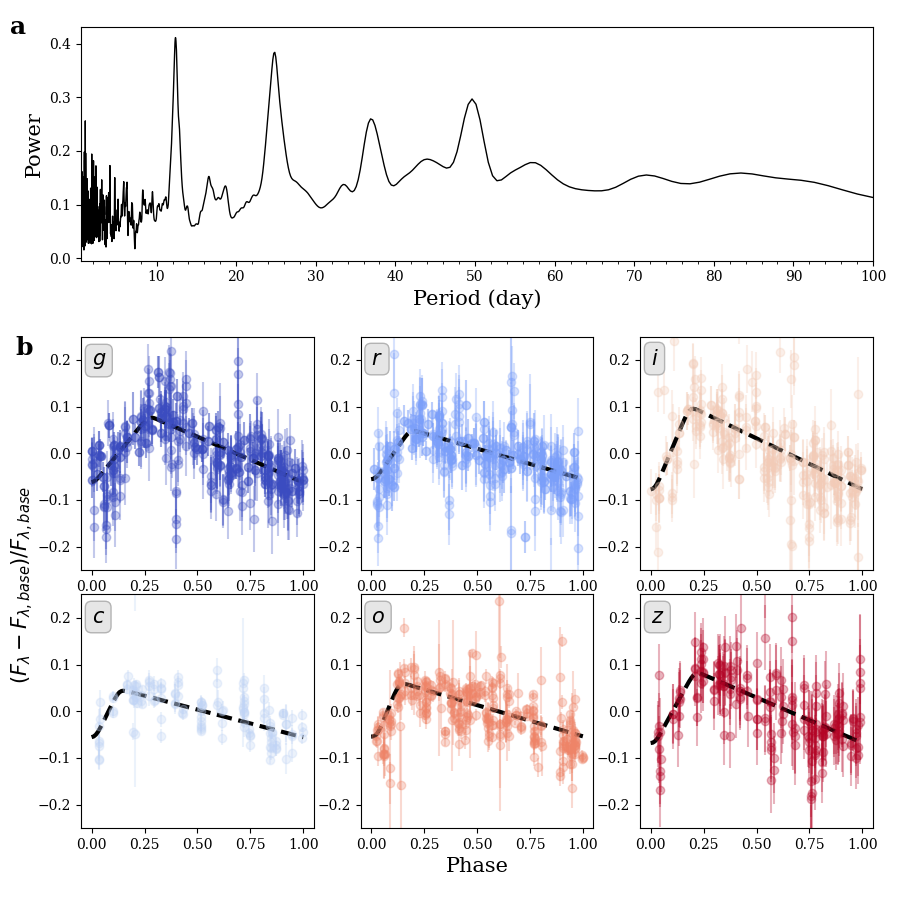

In [86]:
#
period_prior = 12.5
#periods = np.linspace(0.1, 100, 10000)
frequency = np.linspace(0.01, 2, 10000)
periods = 1.0/frequency
power = model.periodogram(periods)


cmap = mpl.cm.seismic
N_period = 16
norm = mpl.colors.Normalize(vmin=0, vmax=N_period)

print(np.min(delta_mag[:,0]), np.max(delta_mag[:,0]))



fig = plt.figure(figsize=(9,9))
gs = GridSpec(16, 3, figure=fig, hspace=0.9, wspace=0.2, left=0.09, right=0.97, bottom=0.08, top=0.97)


ax = ax = fig.add_subplot(gs[0:5, 0:3])

ax.plot(periods, power, lw=1, color='k')
#ax.set_xscale('log')
ax.set_xlim(periods[-1], periods[0])
ax.set_xlabel('Period (day)', fontsize=15)
ax.set_ylabel('Power', fontsize=15)
ax.xaxis.set_minor_locator(MultipleLocator(2))
ax.xaxis.set_major_locator(MultipleLocator(10))

delta_flts = {'g':delta_g, 'r': delta_r, 'i': delta_i, 'c': delta_c, 'o': delta_o, 'z': delta_z}

period = 12.37

axg = fig.add_subplot(gs[6:11, 0])
axr = fig.add_subplot(gs[6:11, 1])
axi = fig.add_subplot(gs[6:11, 2])
axc = fig.add_subplot(gs[11:16, 0])
axo = fig.add_subplot(gs[11:16, 1])
axz = fig.add_subplot(gs[11:16, 2])
axes = {'g': axg, 'r': axr, 'i': axi, 'c': axc, 'o': axo, 'z': axz}
colors = {'g': g_color, 'r': r_color, 'i': i_color, 'c': c_color, 'o': o_color, 'z': z_color}

tfit = np.linspace(0, period, 1000)


flts_plot = np.unique(flts)


params_lowestDEV_dict = {'g': g2_params_lowestDEV, 'r': r2_params_lowestDEV, 'i': i2_params_lowestDEV, 'z': z2_params_lowestDEV, 'c': c2_params_lowestDEV, 'o': o2_params_lowestDEV}


for i, flt in enumerate(['g', 'r', 'i', 'c', 'o', 'z']):
    if flt not in flts_plot:
        continue
    axflt = axes[flt]
    
    flt_params_lowestDEV = params_lowestDEV_dict[flt]
    tshift = flt_params_lowestDEV[2]
    
    delta_fltdata = delta_flts[flt].copy()
    delta_fltdata[:,0] = delta_fltdata[:,0] + tshift
    delta_fltdata = delta_fltdata[delta_fltdata[:,0]<tcut, :]
    
    eb = axflt.errorbar( (delta_fltdata[:,0]%period)/period, delta_fltdata[:,1], yerr=delta_fltdata[:,2], fmt='o', alpha=0.3, color=colors[flt], label=flt)
    yfit = model.predict(tfit, flt, period=period)
    #axflt.plot(tfit/period, yfit, color=eb[0].get_color(), lw=3)
    

    xs_model = np.linspace(0, period, 100)
    ys_model = construct_emperical_bump_model(xs_model, period, flt_params_lowestDEV[0], flt_params_lowestDEV[1], 0, flt_params_lowestDEV[3], flt_params_lowestDEV[4], tbin=0.1)
    axflt.plot(xs_model/period, ys_model, 'k--', lw=3)    
    
    
    axflt.set_ylim([-0.25, 0.25])
    
    axflt.text(0, 0.19, r'$%s$'%flt, fontsize=15, color='k', bbox=dict(boxstyle="round", ec=(0.7, 0.7, 0.7), fc=(0.9, 0.9, 0.9),))

ax.set_title('a', fontsize=18, loc='left', pad=20, x=-0.09, y=0.85, fontweight='bold')
axg.set_title('b', fontsize=18, loc='left', pad=20, x=-0.28, y=0.8, fontweight='bold')

#fig.text(0.025, 0.35, r'$\Delta$ F$_\lambda$/F$_\lambda$', fontsize=15, va='center', ha='center', rotation='vertical')
fig.text(0.025, 0.35, r'$(F_\lambda-F_{\lambda, base})/F_{\lambda, base}$', fontsize=15, va='center', ha='center', rotation='vertical')
axo.set_xlabel('Phase', fontsize=15)

plt.savefig('../plots/sn2022jli_Fig2.pdf')

## test whether there is period variation

210.41069201398642 8.883624999970195
201.5270670140162
Finding optimal frequency:
 - Estimated peak width = 0.0624
 - Using 5 steps per peak; omega_step = 0.0125
 - User-specified period range:  10 to 15
 - Computing periods at 18 steps
Zooming-in on 6 candidate peaks:
 - Computing periods at 1194 steps
[12.24673863 10.12085222 15.46036225]
8.883624999970195 109.63273410005495


<IPython.core.display.Javascript object>


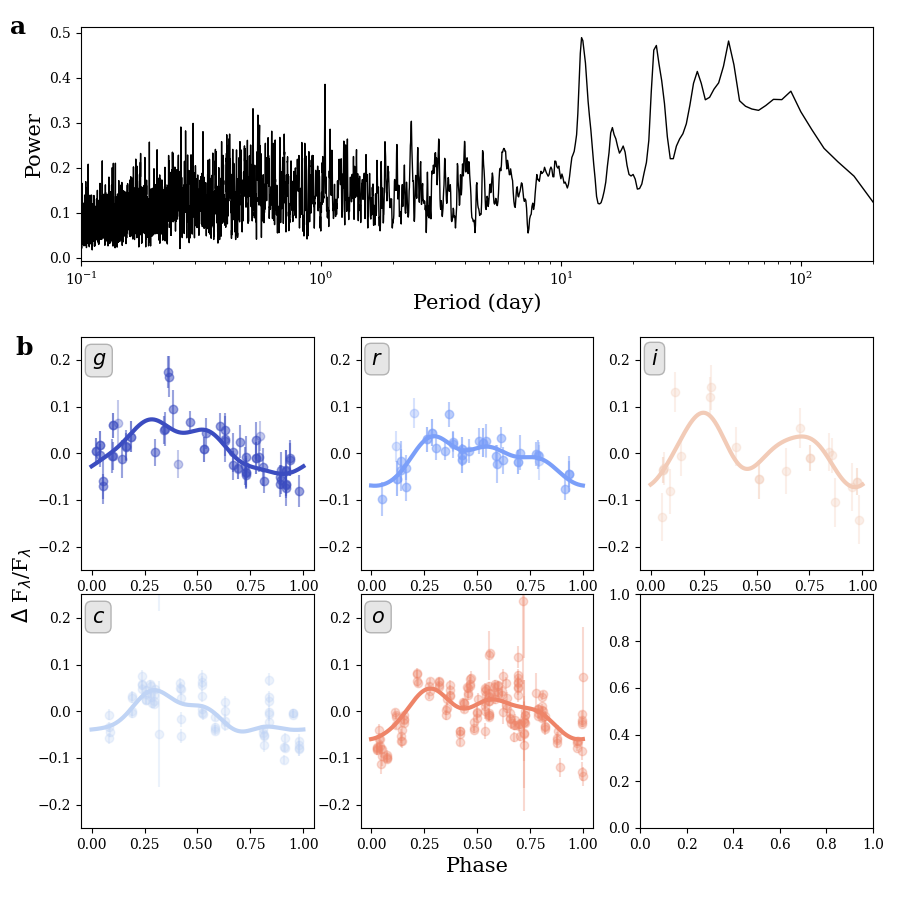

In [76]:
delta_mag = np.vstack([delta_g,  delta_r, delta_i, delta_c, delta_o, delta_z])

tshift = -8 - 12.4*3 
delta_mag[:,0] = delta_mag[:,0] + tshift

print(np.max(delta_mag[:,0]), np.min(delta_mag[:,0]))
trange = np.max(delta_mag[:,0]) - np.min(delta_mag[:,0])
print(np.max(delta_mag[:,0]) - np.min(delta_mag[:,0]))

Ng = len(delta_g)
Nr = len(delta_r)
Ni = len(delta_i)
Nc = len(delta_c)
No = len(delta_o)
Nz = len(delta_z)
flts  = np.hstack([np.array(['g']*Ng), np.array(['r']*Nr), np.array(['i']*Ni), np.array(['c']*Nc), np.array(['o']*No), np.array(['z']*Nz)])

#select part of the data
tcut = np.min(delta_mag[:,0]) + trange/2.0 
flts = flts[delta_mag[:,0]<tcut]
delta_mag = delta_mag[delta_mag[:,0]<tcut,:]


model = LombScargleMultiband(optimizer=None, Nterms_base=4, Nterms_band=2, reg_base=0.05, reg_band=1e-4)  #optimizer not specified, the LinearScanOptimizer will be used
model.fit(delta_mag[:,0], delta_mag[:,1], delta_mag[:,2], flts)

#
period_prior = 12.5
#periods = np.linspace(period_prior - 10, period_prior + 10, 2000)
frequency = np.linspace(0.005, 10, 10000)
periods = 1.0/frequency
power = model.periodogram(periods)


model.optimizer.period_range = (10, 15)
out = model.find_best_periods(n_periods=3)
print(out)


cmap = mpl.cm.seismic
N_period = 16
norm = mpl.colors.Normalize(vmin=0, vmax=N_period)

print(np.min(delta_mag[:,0]), np.max(delta_mag[:,0]))



fig = plt.figure(figsize=(9,9))
gs = GridSpec(16, 3, figure=fig, hspace=0.9, wspace=0.2, left=0.09, right=0.97, bottom=0.08, top=0.97)


ax = ax = fig.add_subplot(gs[0:5, 0:3])

ax.plot(periods, power, lw=1, color='k')
ax.set_xscale('log')
ax.set_xlim(periods[-1], periods[0])
ax.set_xlabel('Period (day)', fontsize=15)
ax.set_ylabel('Power', fontsize=15)

delta_flts = {'g':delta_g, 'r': delta_r, 'i': delta_i, 'c': delta_c, 'o': delta_o, 'z': delta_z}

period_1st = 12.247

axg = fig.add_subplot(gs[6:11, 0])
axr = fig.add_subplot(gs[6:11, 1])
axi = fig.add_subplot(gs[6:11, 2])
axc = fig.add_subplot(gs[11:16, 0])
axo = fig.add_subplot(gs[11:16, 1])
axz = fig.add_subplot(gs[11:16, 2])
axes = {'g': axg, 'r': axr, 'i': axi, 'c': axc, 'o': axo, 'z': axz}
colors = {'g': g_color, 'r': r_color, 'i': i_color, 'c': c_color, 'o': o_color, 'z': z_color}

tfit = np.linspace(0, period_1st, 1000)


flts_plot = np.unique(flts)

for i, flt in enumerate(['g', 'r', 'i', 'c', 'o', 'z']):
    if flt not in flts_plot:
        continue
    axflt = axes[flt]
    delta_fltdata = delta_flts[flt].copy()
    delta_fltdata[:,0] = delta_fltdata[:,0] + tshift
    delta_fltdata = delta_fltdata[delta_fltdata[:,0]<tcut, :]
#     for delta_single_point in delta_fltdata:
#         color = cmap(delta_single_point[0]/period/N_period)
#         ax.errorbar(delta_single_point[0]%period, delta_single_point[1], yerr=delta_single_point[2], fmt='o', color=color, alpha=0.3)
#     ax.plot(tfit, yfit, color='k')
    
    eb = axflt.errorbar( (delta_fltdata[:,0]%period_1st)/period_1st, delta_fltdata[:,1], yerr=delta_fltdata[:,2], fmt='o', alpha=0.3, color=colors[flt], label=flt)
    yfit = model.predict(tfit, flt, period=period_1st)
    axflt.plot(tfit/period_1st, yfit, color=eb[0].get_color(), lw=3)
    axflt.set_ylim([-0.25, 0.25])
    #ax.set_title(flt)
    
    axflt.text(0, 0.19, r'$%s$'%flt, fontsize=15, color='k', bbox=dict(boxstyle="round", ec=(0.7, 0.7, 0.7), fc=(0.9, 0.9, 0.9),))

ax.set_title('a', fontsize=18, loc='left', pad=20, x=-0.09, y=0.85, fontweight='bold')
axg.set_title('b', fontsize=18, loc='left', pad=20, x=-0.28, y=0.8, fontweight='bold')

fig.text(0.025, 0.35, r'$\Delta$ F$_\lambda$/F$_\lambda$', fontsize=15, va='center', ha='center', rotation='vertical')
axo.set_xlabel('Phase', fontsize=15)

plt.savefig('./plots/sn2022jli_first_half_period.pdf')

210.41069201398642 8.883624999970195
201.5270670140162
Finding optimal frequency:
 - Estimated peak width = 0.0624
 - Using 5 steps per peak; omega_step = 0.0125
 - User-specified period range:  10 to 15
 - Computing periods at 18 steps
Zooming-in on 6 candidate peaks:
 - Computing periods at 1200 steps
[12.40703056 11.29562799 10.15562188]
109.78480399977416 210.41069201398642


<IPython.core.display.Javascript object>


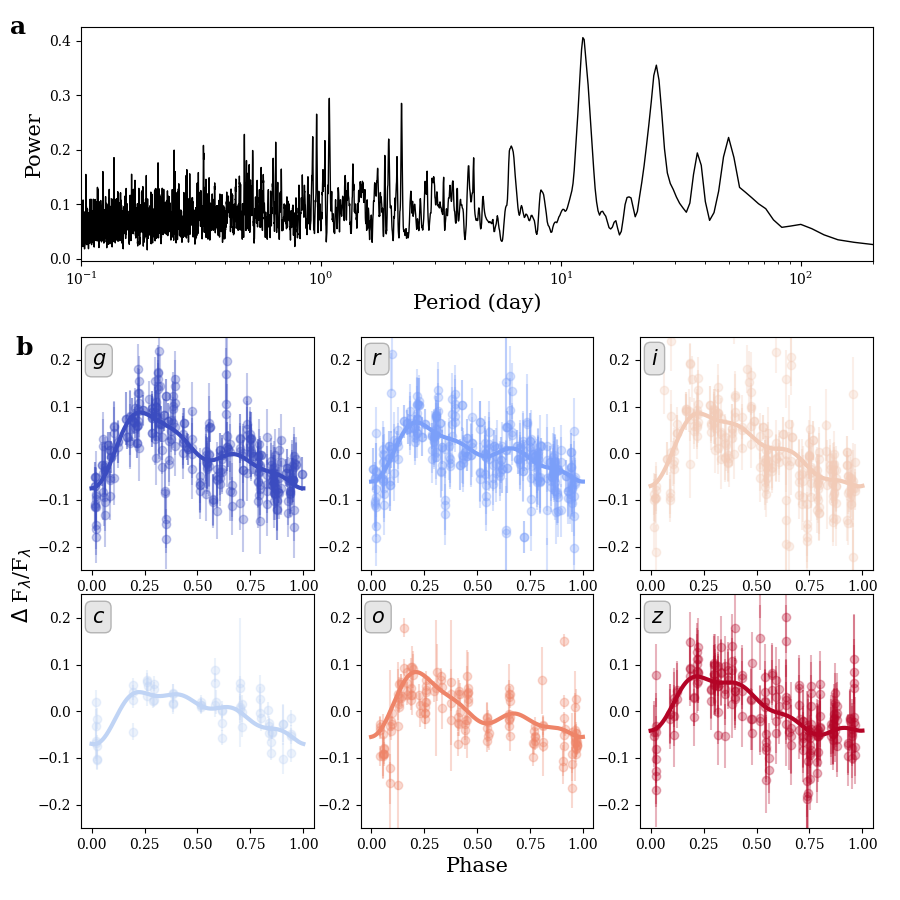

Text(0.5, 0, 'Phase')

In [45]:
delta_mag = np.vstack([delta_g,  delta_r, delta_i, delta_c, delta_o, delta_z])

tshift = -8 - 12.4*3 
delta_mag[:,0] = delta_mag[:,0] + tshift

print(np.max(delta_mag[:,0]), np.min(delta_mag[:,0]))
trange = np.max(delta_mag[:,0]) - np.min(delta_mag[:,0])
print(np.max(delta_mag[:,0]) - np.min(delta_mag[:,0]))

Ng = len(delta_g)
Nr = len(delta_r)
Ni = len(delta_i)
Nc = len(delta_c)
No = len(delta_o)
Nz = len(delta_z)
flts  = np.hstack([np.array(['g']*Ng), np.array(['r']*Nr), np.array(['i']*Ni), np.array(['c']*Nc), np.array(['o']*No), np.array(['z']*Nz)])

#select part of the data
tcut = np.max(delta_mag[:,0]) - trange/2.0 
flts = flts[delta_mag[:,0]>tcut]
delta_mag = delta_mag[delta_mag[:,0]>tcut,:]


model = LombScargleMultiband(optimizer=None, Nterms_base=4, Nterms_band=2, reg_base=0.05, reg_band=1e-4)  #optimizer not specified, the LinearScanOptimizer will be used
model.fit(delta_mag[:,0], delta_mag[:,1], delta_mag[:,2], flts)

#
period_prior = 12.5
#periods = np.linspace(period_prior - 10, period_prior + 10, 2000)
frequency = np.linspace(0.005, 10, 10000)
periods = 1.0/frequency
power = model.periodogram(periods)


model.optimizer.period_range = (10, 15)
out = model.find_best_periods(n_periods=3)
print(out)


cmap = mpl.cm.seismic
N_period = 16
norm = mpl.colors.Normalize(vmin=0, vmax=N_period)

print(np.min(delta_mag[:,0]), np.max(delta_mag[:,0]))

fig = plt.figure(figsize=(9,9))
gs = GridSpec(16, 3, figure=fig, hspace=0.9, wspace=0.2, left=0.09, right=0.97, bottom=0.08, top=0.97)


ax = ax = fig.add_subplot(gs[0:5, 0:3])

ax.plot(periods, power, lw=1, color='k')
ax.set_xscale('log')
ax.set_xlim(periods[-1], periods[0])
ax.set_xlabel('Period (day)', fontsize=15)
ax.set_ylabel('Power', fontsize=15)

delta_flts = {'g':delta_g, 'r': delta_r, 'i': delta_i, 'c': delta_c, 'o': delta_o, 'z': delta_z}

period_2nd = 12.407

axg = fig.add_subplot(gs[6:11, 0])
axr = fig.add_subplot(gs[6:11, 1])
axi = fig.add_subplot(gs[6:11, 2])
axc = fig.add_subplot(gs[11:16, 0])
axo = fig.add_subplot(gs[11:16, 1])
axz = fig.add_subplot(gs[11:16, 2])
axes = {'g': axg, 'r': axr, 'i': axi, 'c': axc, 'o': axo, 'z': axz}
colors = {'g': g_color, 'r': r_color, 'i': i_color, 'c': c_color, 'o': o_color, 'z': z_color}

tfit = np.linspace(0, period_2nd, 1000)


flts_plot = np.unique(flts)

for i, flt in enumerate(['g', 'r', 'i', 'c', 'o', 'z']):
    if flt not in flts_plot:
        continue
    axflt = axes[flt]
    delta_fltdata = delta_flts[flt].copy()
    delta_fltdata[:,0] = delta_fltdata[:,0] + tshift
    delta_fltdata = delta_fltdata[delta_fltdata[:,0]>tcut, :]
#     for delta_single_point in delta_fltdata:
#         color = cmap(delta_single_point[0]/period/N_period)
#         ax.errorbar(delta_single_point[0]%period, delta_single_point[1], yerr=delta_single_point[2], fmt='o', color=color, alpha=0.3)
#     ax.plot(tfit, yfit, color='k')
    
    eb = axflt.errorbar( (delta_fltdata[:,0]%period_2nd)/period_2nd, delta_fltdata[:,1], yerr=delta_fltdata[:,2], fmt='o', alpha=0.3, color=colors[flt], label=flt)
    yfit = model.predict(tfit, flt, period=period_2nd)
    axflt.plot(tfit/period_2nd, yfit, color=eb[0].get_color(), lw=3)
    axflt.set_ylim([-0.25, 0.25])
    #ax.set_title(flt)
    
    axflt.text(0, 0.19, r'$%s$'%flt, fontsize=15, color='k', bbox=dict(boxstyle="round", ec=(0.7, 0.7, 0.7), fc=(0.9, 0.9, 0.9),))

ax.set_title('a', fontsize=18, loc='left', pad=20, x=-0.09, y=0.85, fontweight='bold')
axg.set_title('b', fontsize=18, loc='left', pad=20, x=-0.28, y=0.8, fontweight='bold')

fig.text(0.025, 0.35, r'$\Delta$ F$_\lambda$/F$_\lambda$', fontsize=15, va='center', ha='center', rotation='vertical')
axo.set_xlabel('Phase', fontsize=15)

#plt.savefig('./plots/sn2022jli_second_half_period.pdf')